In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, RepeatVector, TimeDistributed, SimpleRNN
from tensorflow.keras.layers import Reshape, GlobalMaxPool1D, Lambda, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import random

import pickle

from sklearn.metrics import precision_recall_curve, precision_score, recall_score, accuracy_score
from sklearn.metrics import average_precision_score, roc_auc_score

%matplotlib inline

2022-12-29 12:51:41.744098: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, enable=True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-12-29 12:51:46.424972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 12:51:46.676791: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 12:51:46.677038: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
with open('./data/xl.pickle', 'rb') as xl_file:
    xl = (pickle.load(xl_file))

with open('./data/yl.pickle', 'rb') as yl_file:
    yl = pickle.load(yl_file)


In [212]:
y = np.array(yl)


In [210]:
y = np.stack(y, axis=0)

In [213]:
y.shape


(50000, 5)

### Understanding the data
There are 50000 records. Each record is a sequence of outputs from 3 sensors.
Each record is multi-labeled, there are 5 types of defects and they are nonexclusive.


### Issues

#### Training examples vary in length
We can solve this issue with the following approaches:
1. Truncate each training example (then each example has the same lenght and we can easily train our models)
Drawbacks:
- information loss
- labeling errors (if a defect is present in a part of the sequence that has been truncated, then we introduce noise to the data)

2. Write custom data generator that will feed the network with training batches having the same number of samples in each example. (Within a single batch, each training example has to have equal shape, but between batches shapes may vary)

pros:
- during prediction, we may use any sequence length we want



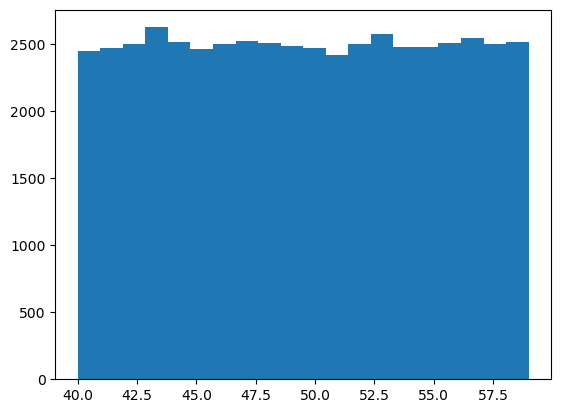

40

In [7]:

lengths = [record.shape[0] for record in xl]

plt.hist(lengths, bins=20, )
plt.show()
min(lengths)

### 1st approach - truncating the training data


In [87]:
xl_trunc = [sample[:40] for sample in xl]

x_trunc = np.array(xl).astype(float)

x_trunc.shape

(50000, 40, 3)

Data split

In [93]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    x_trunc, y, test_size=0.2, random_state=42)


X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42)

Model

In [151]:
model = Sequential()
model.add(LSTM(64, input_shape=(None, 3))) # return_seq = False now
model.add(Dense(5, 'sigmoid'))
model.compile(loss='binary_crossentropy', metrics='acc', optimizer='adam')


In [152]:
early = EarlyStopping(patience=10)

model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=50, callbacks=[early])

Epoch 1/50
438/438 [==============================] - 4s 6ms/step - loss: 0.3989 - acc: 0.3609 - val_loss: 0.3306 - val_acc: 0.4102
Epoch 2/50
438/438 [==============================] - 2s 5ms/step - loss: 0.3153 - acc: 0.4305 - val_loss: 0.2966 - val_acc: 0.4288
Epoch 3/50
438/438 [==============================] - 2s 5ms/step - loss: 0.2866 - acc: 0.4338 - val_loss: 0.2774 - val_acc: 0.4133
Epoch 4/50
438/438 [==============================] - 2s 5ms/step - loss: 0.2709 - acc: 0.4387 - val_loss: 0.2632 - val_acc: 0.4683
Epoch 5/50
438/438 [==============================] - 2s 5ms/step - loss: 0.2532 - acc: 0.4588 - val_loss: 0.2370 - val_acc: 0.4210
Epoch 6/50
438/438 [==============================] - 2s 5ms/step - loss: 0.2355 - acc: 0.4717 - val_loss: 0.2268 - val_acc: 0.4415
Epoch 7/50
438/438 [==============================] - 2s 5ms/step - loss: 0.2232 - acc: 0.4878 - val_loss: 0.2130 - val_acc: 0.4525
Epoch 8/50
438/438 [==============================] - 2s 5ms/step - loss: 0.

In [153]:
y_pred = model.predict(X_test).round().astype(int)
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.1327 - acc: 0.6036


[0.13267064094543457, 0.603600025177002]

In [154]:
from sklearn.metrics import multilabel_confusion_matrix

cf = multilabel_confusion_matrix(y_test.astype(int), y_pred, samplewise=False)
cf

array([[[7457,    8],
        [ 460, 2075]],

       [[7513,    3],
        [ 476, 2008]],

       [[7480,   15],
        [ 450, 2055]],

       [[7434,    0],
        [ 141, 2425]],

       [[7451,    1],
        [ 226, 2322]]])

In [155]:
from sklearn.metrics import classification_report
print(classification_report(y_test.astype(int), y_pred, target_names=['def1','def2','def3','def4','def5'], zero_division=0))

              precision    recall  f1-score   support

        def1       1.00      0.82      0.90      2535
        def2       1.00      0.81      0.89      2484
        def3       0.99      0.82      0.90      2505
        def4       1.00      0.95      0.97      2566
        def5       1.00      0.91      0.95      2548

   micro avg       1.00      0.86      0.92     12638
   macro avg       1.00      0.86      0.92     12638
weighted avg       1.00      0.86      0.92     12638
 samples avg       0.71      0.66      0.68     12638



With this approach we obtain very high precision, but average recall is `0.86`. Low recall may be caused by truncating parts of sequences.

### 2nd approach - Stochastic Gradient Descent

We can try to workaround the problem of varying sample-size by feeding the RNN with just one sample at a time.

> This approach turns out to be extremely time ineficient

In [167]:
x = np.array(xl)


X_train, X_test, y_train, y_test = train_test_split(
    xl, y, test_size=0.2, random_state=42)


X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42)

/tmp/ipykernel_81820/43555385.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(xl)


In [171]:
y_train.shape

(28000, 5)

In [169]:
early = EarlyStopping(patience=10)

model.fit(X_train, y_train, batch_size=1, epochs=50, callbacks=[early])

ValueError: Data cardinality is ambiguous:
  x sizes: 40, 54, 50, 50, 49, 53, 52, 53, 48, 45, 40, 41, 49, 47, 52, 53, 53, 58, 59, 55, 51, 41, 52, 50, 52, 58, 45, 50, 46, 40, 59, 58, 51, 54, 47, 50, 45, 57, 56, 45, 47, 45, 51, 40, 52, 46, 55, 55, 58, 47, 51, 43, 50, 57, 57, 57, 45, 57, 53, 57, 46, 52, 45, 50, 55, 59, 52, 56, 41, 54, 44, 44, 43, 50, 45, 51, 58, 51, 53, 50, 59, 53, 42, 57, 54, 58, 59, 59, 47, 48, 59, 59, 48, 50, 55, 53, 57, 40, 59, 48, 44, 40, 56, 49, 45, 55, 45, 52, 45, 48, 49, 58, 40, 56, 55, 45, 49, 55, 52, 51, 41, 59, 55, 44, 45, 51, 46, 59, 52, 57, 43, 59, 51, 47, 42, 50, 41, 42, 47, 46, 57, 45, 56, 58, 51, 52, 59, 59, 48, 58, 53, 41, 53, 43, 43, 55, 57, 52, 52, 45, 43, 52, 59, 54, 51, 50, 59, 42, 47, 45, 45, 49, 58, 40, 58, 59, 42, 52, 58, 53, 40, 45, 55, 59, 42, 43, 51, 51, 40, 44, 48, 55, 45, 42, 41, 59, 52, 44, 53, 51, 57, 41, 44, 55, 54, 46, 44, 51, 44, 55, 55, 58, 42, 58, 52, 59, 53, 57, 42, 56, 48, 48, 50, 49, 59, 43, 54, 59, 48, 53, 57, 54, 47, 49, 57, 49, 50, 44, 41, 41, 57, 43, 54, 58, 45, 49, 43, 58, 49, 43, 50, 52, 45, 51, 58, 43, 53, 58, 45, 48, 41, 43, 42, 44, 57, 53, 52, 54, 54, 51, 47, 43, 55, 47, 47, 52, 51, 49, 47, 52, 49, 42, 44, 47, 57, 49, 47, 51, 48, 40, 46, 53, 45, 42, 47, 45, 48, 58, 50, 42, 58, 40, 56, 57, 51, 54, 42, 59, 45, 41, 49, 48, 47, 45, 41, 57, 42, 57, 58, 49, 57, 58, 54, 54, 47, 46, 51, 54, 54, 43, 57, 46, 47, 58, 44, 54, 41, 59, 56, 43, 51, 42, 59, 58, 55, 56, 53, 50, 49, 44, 59, 46, 40, 48, 44, 58, 56, 43, 46, 55, 44, 56, 55, 47, 55, 53, 53, 50, 56, 48, 58, 48, 54, 47, 55, 45, 49, 57, 57, 55, 50, 40, 50, 57, 43, 50, 55, 42, 45, 55, 59, 42, 45, 59, 59, 46, 54, 56, 49, 54, 56, 53, 50, 50, 42, 53, 44, 50, 57, 47, 48, 46, 45, 46, 53, 55, 43, 51, 41, 40, 54, 46, 59, 42, 59, 43, 43, 54, 56, 49, 40, 50, 42, 45, 41, 50, 45, 59, 58, 47, 45, 41, 54, 53, 56, 59, 48, 46, 49, 57, 59, 54, 40, 42, 41, 50, 46, 59, 49, 48, 49, 49, 59, 48, 42, 44, 58, 51, 53, 45, 40, 59, 45, 45, 48, 45, 48, 50, 51, 40, 47, 49, 44, 45, 42, 56, 57, 48, 57, 41, 57, 51, 56, 45, 57, 42, 57, 54, 51, 43, 54, 43, 43, 52, 53, 47, 54, 54, 43, 52, 58, 56, 43, 59, 58, 53, 59, 51, 49, 51, 52, 58, 46, 55, 53, 40, 51, 52, 50, 56, 52, 57, 42, 40, 50, 57, 53, 55, 54, 54, 46, 56, 43, 46, 55, 44, 48, 56, 58, 56, 48, 41, 41, 58, 55, 45, 43, 59, 45, 51, 43, 58, 40, 52, 44, 40, 58, 59, 45, 45, 47, 41, 40, 41, 41, 41, 53, 45, 43, 44, 56, 46, 47, 48, 43, 48, 42, 59, 57, 53, 58, 48, 51, 49, 53, 46, 52, 51, 44, 40, 56, 45, 46, 41, 58, 59, 55, 55, 44, 53, 55, 41, 53, 44, 58, 43, 55, 47, 51, 59, 52, 54, 58, 46, 41, 59, 43, 56, 58, 55, 54, 59, 41, 49, 57, 57, 41, 41, 55, 53, 57, 56, 42, 54, 44, 49, 40, 48, 43, 55, 46, 51, 51, 43, 49, 48, 55, 46, 45, 46, 43, 42, 53, 52, 48, 52, 58, 44, 49, 51, 42, 54, 57, 48, 48, 43, 47, 49, 54, 51, 45, 51, 57, 51, 48, 49, 51, 49, 45, 40, 44, 54, 49, 50, 55, 55, 52, 44, 52, 50, 41, 41, 47, 51, 59, 55, 40, 48, 57, 52, 53, 51, 42, 57, 40, 47, 50, 41, 59, 55, 47, 51, 40, 43, 56, 50, 57, 56, 44, 55, 54, 59, 46, 58, 55, 51, 50, 51, 56, 51, 43, 43, 51, 47, 59, 53, 59, 40, 45, 49, 54, 58, 46, 40, 48, 52, 59, 51, 41, 41, 55, 53, 40, 55, 44, 43, 58, 57, 55, 53, 48, 47, 59, 48, 43, 58, 59, 47, 43, 43, 45, 45, 45, 48, 53, 51, 54, 55, 53, 52, 52, 47, 50, 44, 48, 41, 58, 53, 52, 41, 49, 53, 46, 49, 42, 57, 55, 52, 43, 57, 43, 48, 55, 54, 50, 52, 46, 44, 43, 51, 47, 53, 58, 56, 41, 49, 58, 53, 57, 41, 41, 56, 47, 53, 40, 51, 52, 52, 49, 45, 47, 43, 59, 41, 44, 42, 51, 47, 47, 43, 43, 48, 50, 58, 43, 53, 54, 50, 58, 51, 44, 58, 49, 54, 53, 53, 58, 45, 41, 50, 58, 55, 44, 53, 46, 52, 59, 49, 43, 54, 58, 49, 50, 41, 57, 44, 41, 41, 57, 43, 47, 41, 48, 48, 45, 59, 56, 40, 57, 50, 45, 57, 56, 48, 51, 55, 41, 47, 43, 47, 48, 53, 43, 59, 50, 40, 50, 55, 49, 40, 42, 43, 49, 59, 54, 53, 48, 48, 41, 54, 59, 53, 50, 52, 59, 44, 46, 51, 55, 55, 57, 46, 51, 55, 42, 52, 45, 54, 58, 41, 41, 54, 51, 45, 41, 43, 59, 46, 50, 50, 42, 54, 52, 59, 50, 45, 46, 52, 56, 54, 53, 57, 58, 46, 58, 41, 54, 46, 50, 51, 50, 50, 51, 48, 45, 54, 53, 48, 53, 44, 54, 49, 49, 59, 41, 53, 55, 40, 51, 52, 50, 59, 55, 53, 50, 56, 49, 57, 44, 43, 41, 51, 40, 49, 58, 47, 57, 53, 58, 44, 53, 54, 57, 48, 47, 45, 59, 41, 45, 41, 41, 42, 48, 57, 57, 47, 51, 50, 43, 46, 40, 48, 48, 45, 54, 41, 52, 53, 59, 50, 59, 56, 52, 43, 46, 49, 52, 56, 50, 42, 54, 45, 41, 56, 53, 56, 44, 43, 58, 44, 54, 46, 53, 46, 49, 51, 53, 54, 42, 42, 55, 53, 51, 50, 46, 48, 43, 48, 45, 59, 49, 58, 51, 52, 47, 49, 52, 53, 40, 53, 54, 53, 46, 44, 50, 54, 40, 50, 50, 47, 48, 45, 46, 42, 53, 54, 44, 49, 49, 55, 52, 43, 44, 55, 42, 54, 46, 41, 41, 47, 42, 40, 54, 58, 45, 52, 49, 44, 40, 48, 46, 56, 40, 58, 57, 52, 40, 43, 41, 44, 57, 42, 48, 48, 51, 40, 57, 48, 44, 56, 46, 44, 57, 45, 41, 55, 49, 46, 55, 47, 58, 56, 58, 45, 55, 58, 42, 47, 48, 45, 44, 56, 46, 58, 50, 42, 56, 47, 54, 58, 58, 45, 40, 51, 40, 51, 59, 44, 43, 49, 41, 45, 44, 55, 45, 59, 44, 59, 49, 52, 57, 51, 46, 53, 46, 58, 54, 46, 59, 59, 49, 55, 44, 40, 49, 45, 47, 52, 44, 41, 43, 50, 49, 51, 58, 41, 43, 56, 42, 41, 55, 42, 49, 54, 44, 58, 54, 42, 43, 55, 56, 53, 53, 41, 54, 56, 55, 59, 59, 56, 50, 50, 51, 52, 50, 50, 46, 46, 50, 58, 43, 41, 54, 48, 55, 55, 48, 40, 50, 50, 47, 59, 53, 42, 46, 50, 54, 43, 45, 50, 43, 46, 54, 56, 48, 45, 41, 45, 54, 48, 57, 45, 47, 48, 49, 44, 46, 56, 47, 44, 55, 56, 47, 44, 51, 54, 40, 44, 58, 42, 50, 51, 44, 46, 51, 50, 58, 48, 45, 43, 45, 48, 52, 57, 49, 54, 40, 54, 51, 45, 47, 59, 52, 59, 42, 51, 55, 59, 45, 45, 59, 40, 49, 40, 44, 43, 59, 40, 56, 40, 56, 40, 42, 48, 48, 45, 45, 44, 50, 54, 56, 47, 49, 53, 54, 58, 56, 57, 51, 48, 41, 54, 53, 59, 44, 52, 54, 43, 40, 52, 54, 52, 56, 43, 56, 40, 45, 43, 40, 45, 41, 59, 57, 50, 52, 53, 51, 49, 42, 58, 43, 52, 44, 41, 53, 53, 53, 49, 55, 51, 46, 53, 43, 53, 59, 46, 49, 55, 52, 55, 44, 53, 52, 52, 46, 46, 58, 43, 47, 40, 45, 40, 44, 53, 57, 59, 59, 44, 48, 44, 59, 40, 57, 50, 42, 43, 45, 40, 45, 48, 48, 43, 46, 44, 43, 57, 54, 49, 48, 48, 46, 51, 42, 48, 58, 47, 44, 45, 54, 54, 46, 54, 58, 57, 55, 48, 59, 46, 58, 45, 43, 52, 44, 40, 59, 46, 48, 53, 44, 49, 42, 47, 42, 52, 40, 45, 58, 52, 56, 44, 42, 50, 51, 52, 41, 51, 53, 52, 48, 52, 56, 57, 56, 56, 49, 54, 58, 44, 47, 59, 55, 49, 45, 51, 58, 40, 56, 43, 47, 59, 50, 54, 42, 56, 41, 46, 54, 41, 56, 56, 46, 47, 50, 48, 45, 49, 49, 41, 48, 51, 54, 41, 43, 46, 40, 49, 49, 49, 40, 51, 45, 41, 42, 59, 58, 53, 55, 45, 42, 44, 48, 42, 54, 52, 48, 57, 41, 50, 48, 59, 42, 57, 55, 46, 43, 45, 51, 48, 53, 49, 46, 47, 54, 41, 50, 49, 41, 57, 47, 43, 47, 57, 59, 50, 54, 40, 48, 50, 46, 53, 54, 43, 46, 54, 42, 48, 50, 53, 47, 48, 57, 49, 49, 46, 55, 50, 41, 47, 44, 53, 56, 45, 45, 59, 49, 57, 46, 49, 55, 50, 46, 40, 43, 46, 44, 49, 49, 58, 59, 55, 54, 56, 53, 41, 48, 51, 55, 51, 51, 47, 53, 52, 57, 56, 49, 48, 54, 40, 52, 55, 53, 40, 56, 49, 49, 44, 46, 59, 59, 51, 53, 57, 58, 54, 41, 40, 42, 55, 43, 45, 51, 54, 45, 46, 59, 48, 53, 53, 43, 43, 44, 56, 45, 40, 50, 58, 43, 45, 45, 40, 57, 41, 48, 53, 52, 51, 55, 41, 47, 50, 42, 58, 53, 48, 46, 40, 49, 40, 52, 56, 50, 55, 46, 47, 49, 51, 59, 48, 57, 47, 58, 50, 46, 52, 46, 58, 49, 49, 56, 50, 59, 49, 50, 57, 46, 50, 50, 40, 55, 53, 50, 49, 49, 47, 46, 53, 46, 59, 57, 55, 45, 41, 41, 42, 55, 58, 50, 55, 52, 57, 40, 58, 44, 49, 45, 54, 46, 44, 45, 57, 54, 56, 54, 54, 45, 52, 49, 59, 50, 45, 49, 49, 56, 59, 43, 46, 54, 45, 55, 46, 42, 43, 54, 55, 45, 51, 40, 51, 53, 45, 46, 55, 44, 56, 46, 40, 53, 56, 52, 52, 42, 51, 46, 52, 57, 57, 47, 46, 53, 44, 54, 42, 44, 49, 41, 54, 49, 49, 41, 48, 49, 46, 48, 57, 53, 44, 55, 57, 49, 46, 55, 59, 44, 43, 50, 52, 41, 55, 43, 47, 45, 51, 48, 49, 45, 41, 57, 57, 43, 58, 53, 55, 58, 51, 52, 41, 59, 47, 44, 50, 52, 40, 45, 43, 41, 46, 57, 51, 59, 53, 59, 55, 42, 52, 48, 46, 59, 44, 44, 40, 54, 42, 56, 46, 54, 53, 46, 53, 42, 56, 49, 50, 44, 59, 45, 49, 44, 44, 53, 58, 41, 49, 40, 56, 44, 42, 43, 44, 58, 47, 44, 48, 52, 51, 59, 57, 57, 57, 48, 48, 52, 42, 48, 53, 40, 50, 49, 46, 45, 48, 51, 59, 40, 49, 47, 58, 57, 51, 46, 52, 44, 58, 59, 55, 59, 50, 48, 41, 50, 49, 57, 48, 49, 41, 59, 44, 54, 43, 41, 58, 42, 53, 54, 42, 41, 52, 58, 47, 44, 48, 54, 51, 47, 53, 40, 44, 40, 48, 55, 54, 48, 49, 52, 40, 52, 43, 48, 58, 55, 46, 48, 47, 54, 54, 55, 58, 49, 58, 57, 53, 47, 43, 58, 52, 57, 40, 44, 46, 53, 41, 42, 56, 55, 57, 46, 58, 43, 45, 58, 44, 47, 56, 58, 59, 41, 56, 40, 47, 41, 55, 47, 55, 43, 43, 44, 50, 47, 43, 45, 50, 40, 47, 58, 50, 42, 49, 47, 53, 51, 48, 41, 47, 56, 48, 58, 49, 46, 58, 58, 54, 41, 58, 50, 57, 53, 42, 49, 42, 58, 46, 54, 45, 44, 50, 57, 47, 48, 49, 59, 53, 43, 59, 58, 52, 53, 42, 45, 47, 42, 41, 58, 44, 48, 44, 59, 49, 51, 54, 53, 43, 59, 44, 50, 58, 47, 41, 52, 58, 48, 55, 55, 47, 51, 49, 41, 48, 41, 59, 49, 44, 53, 43, 50, 59, 56, 44, 43, 57, 44, 55, 55, 58, 48, 42, 45, 55, 57, 56, 45, 57, 40, 44, 52, 41, 50, 51, 43, 47, 49, 47, 43, 54, 41, 50, 54, 44, 45, 40, 42, 49, 45, 51, 56, 48, 58, 45, 55, 55, 56, 49, 48, 49, 44, 51, 52, 48, 56, 45, 45, 59, 44, 51, 49, 58, 57, 51, 45, 56, 52, 48, 45, 47, 55, 50, 45, 43, 45, 48, 49, 43, 48, 45, 54, 48, 42, 51, 58, 40, 43, 58, 50, 59, 43, 54, 50, 55, 41, 47, 59, 55, 41, 40, 59, 50, 57, 42, 55, 59, 48, 45, 54, 41, 44, 49, 55, 53, 53, 51, 59, 53, 44, 42, 41, 44, 52, 46, 40, 45, 58, 41, 53, 48, 42, 51, 43, 47, 43, 48, 51, 43, 43, 43, 49, 53, 51, 56, 53, 52, 45, 44, 48, 51, 50, 43, 48, 57, 45, 41, 40, 56, 50, 44, 43, 55, 50, 57, 53, 56, 45, 53, 55, 42, 40, 58, 42, 45, 52, 52, 43, 54, 52, 46, 40, 40, 47, 45, 54, 45, 41, 41, 50, 41, 56, 45, 49, 52, 44, 49, 57, 58, 50, 52, 54, 45, 44, 54, 51, 58, 49, 47, 54, 43, 41, 41, 49, 51, 49, 52, 55, 41, 46, 44, 58, 48, 58, 57, 44, 58, 47, 41, 59, 41, 57, 45, 46, 56, 46, 40, 43, 40, 54, 58, 41, 49, 56, 49, 48, 42, 47, 48, 42, 51, 45, 55, 56, 48, 58, 54, 40, 49, 42, 51, 54, 44, 46, 56, 44, 47, 40, 45, 42, 56, 50, 57, 57, 48, 41, 40, 42, 43, 46, 44, 47, 43, 58, 58, 50, 42, 51, 46, 58, 47, 48, 43, 47, 49, 48, 49, 40, 56, 56, 48, 55, 52, 41, 52, 57, 53, 49, 51, 57, 50, 44, 47, 50, 51, 59, 49, 54, 56, 45, 58, 51, 56, 49, 49, 49, 49, 57, 42, 50, 58, 42, 50, 40, 42, 56, 56, 53, 41, 57, 51, 59, 44, 42, 44, 59, 56, 43, 56, 59, 49, 48, 56, 58, 41, 52, 45, 52, 48, 45, 56, 46, 57, 47, 50, 41, 51, 59, 59, 59, 52, 58, 48, 51, 51, 44, 56, 51, 46, 52, 56, 51, 40, 49, 45, 46, 53, 41, 51, 59, 57, 42, 46, 55, 48, 40, 56, 41, 57, 52, 56, 53, 59, 51, 46, 44, 53, 43, 41, 41, 46, 42, 45, 40, 58, 44, 56, 56, 57, 49, 55, 48, 42, 51, 43, 55, 57, 57, 43, 50, 48, 44, 53, 53, 41, 57, 53, 48, 45, 45, 54, 57, 53, 53, 51, 50, 46, 47, 44, 50, 47, 42, 45, 53, 45, 48, 53, 46, 49, 56, 59, 52, 54, 44, 55, 51, 46, 56, 46, 52, 55, 50, 47, 53, 58, 50, 40, 54, 50, 46, 52, 50, 52, 48, 57, 56, 55, 58, 41, 51, 41, 50, 56, 54, 47, 52, 46, 50, 59, 54, 47, 44, 42, 43, 51, 56, 40, 51, 52, 51, 41, 41, 59, 52, 55, 48, 45, 51, 59, 43, 40, 57, 57, 51, 54, 55, 53, 56, 48, 57, 58, 57, 51, 42, 52, 48, 43, 48, 41, 55, 59, 48, 41, 59, 52, 57, 55, 52, 54, 55, 56, 44, 45, 58, 52, 40, 51, 53, 45, 40, 47, 45, 53, 53, 57, 47, 44, 58, 56, 44, 59, 54, 46, 41, 46, 54, 49, 53, 54, 50, 56, 50, 44, 43, 49, 48, 52, 43, 44, 52, 50, 47, 51, 47, 46, 40, 45, 46, 56, 40, 51, 46, 40, 58, 44, 43, 59, 57, 41, 40, 48, 51, 52, 49, 44, 50, 42, 45, 58, 44, 50, 54, 55, 53, 45, 46, 47, 45, 54, 43, 49, 42, 59, 42, 44, 41, 42, 43, 51, 44, 57, 42, 54, 42, 48, 56, 52, 43, 51, 42, 55, 42, 41, 51, 46, 40, 41, 44, 45, 49, 40, 54, 54, 56, 46, 59, 40, 43, 48, 51, 56, 59, 48, 43, 46, 58, 51, 51, 50, 43, 59, 41, 40, 45, 55, 46, 56, 44, 51, 59, 52, 53, 53, 43, 44, 44, 42, 47, 53, 57, 51, 51, 49, 51, 52, 49, 59, 42, 44, 47, 40, 46, 54, 43, 59, 59, 55, 47, 51, 50, 42, 57, 43, 57, 55, 41, 57, 43, 47, 54, 44, 56, 57, 46, 46, 47, 51, 56, 59, 40, 46, 55, 44, 48, 49, 56, 58, 48, 57, 54, 43, 52, 40, 56, 52, 59, 44, 57, 58, 48, 49, 53, 45, 45, 44, 48, 49, 59, 55, 42, 47, 47, 53, 47, 49, 52, 51, 53, 51, 43, 50, 48, 53, 49, 54, 43, 53, 52, 40, 56, 42, 47, 40, 42, 43, 51, 58, 42, 53, 41, 53, 42, 59, 58, 43, 46, 57, 56, 59, 54, 52, 45, 54, 42, 55, 42, 52, 53, 46, 51, 45, 42, 50, 58, 41, 41, 52, 49, 59, 41, 47, 58, 55, 43, 56, 49, 48, 59, 48, 46, 40, 44, 44, 59, 51, 52, 58, 41, 48, 48, 52, 41, 51, 46, 51, 42, 58, 59, 49, 57, 54, 40, 58, 46, 57, 57, 58, 51, 58, 55, 57, 51, 43, 49, 56, 44, 51, 58, 50, 49, 59, 43, 55, 55, 57, 57, 47, 45, 47, 59, 40, 42, 41, 55, 50, 47, 44, 49, 59, 42, 50, 54, 59, 51, 41, 40, 44, 57, 54, 59, 54, 47, 58, 55, 50, 47, 55, 41, 53, 58, 40, 45, 50, 56, 51, 53, 49, 53, 40, 59, 47, 45, 48, 56, 47, 42, 55, 58, 47, 56, 59, 59, 53, 52, 40, 55, 40, 51, 49, 48, 50, 50, 41, 51, 50, 55, 48, 47, 44, 45, 43, 53, 55, 44, 54, 43, 40, 48, 43, 48, 57, 53, 49, 43, 52, 46, 44, 55, 48, 49, 58, 45, 49, 52, 49, 42, 55, 56, 57, 56, 41, 47, 59, 49, 44, 41, 59, 44, 58, 44, 42, 58, 52, 45, 53, 45, 44, 53, 47, 57, 48, 45, 41, 44, 50, 59, 49, 50, 46, 53, 47, 44, 44, 49, 46, 46, 45, 53, 56, 55, 49, 49, 46, 51, 44, 54, 44, 43, 46, 45, 51, 52, 43, 59, 42, 57, 54, 53, 44, 41, 44, 42, 58, 54, 51, 41, 57, 57, 43, 41, 58, 57, 44, 41, 45, 45, 54, 40, 43, 55, 43, 44, 53, 50, 51, 57, 45, 42, 54, 49, 40, 47, 45, 42, 40, 50, 42, 40, 50, 51, 54, 51, 55, 43, 44, 58, 49, 58, 49, 50, 52, 53, 46, 45, 50, 48, 57, 58, 49, 52, 57, 48, 41, 51, 42, 52, 50, 43, 57, 50, 49, 46, 45, 41, 43, 44, 58, 48, 53, 43, 56, 45, 59, 54, 42, 55, 52, 50, 54, 43, 43, 58, 42, 43, 43, 57, 59, 44, 55, 51, 54, 57, 51, 49, 53, 55, 56, 45, 47, 53, 57, 47, 53, 59, 49, 56, 59, 47, 45, 47, 49, 48, 49, 53, 53, 48, 53, 43, 44, 40, 55, 53, 45, 57, 59, 49, 55, 48, 41, 50, 50, 41, 48, 47, 41, 47, 43, 42, 56, 40, 50, 49, 41, 51, 40, 53, 44, 45, 59, 45, 49, 44, 56, 45, 49, 53, 42, 45, 53, 42, 50, 45, 56, 58, 43, 47, 58, 46, 40, 46, 48, 50, 45, 58, 54, 41, 45, 49, 41, 41, 52, 51, 45, 53, 46, 50, 51, 55, 46, 50, 53, 43, 42, 41, 46, 56, 44, 52, 57, 56, 52, 47, 53, 54, 57, 50, 53, 55, 40, 57, 42, 43, 55, 41, 59, 44, 46, 52, 51, 55, 46, 45, 40, 55, 45, 53, 49, 49, 57, 51, 52, 56, 51, 48, 40, 43, 56, 52, 48, 55, 53, 50, 58, 51, 51, 46, 50, 55, 54, 55, 49, 42, 48, 46, 49, 47, 49, 46, 57, 42, 54, 58, 40, 48, 51, 44, 44, 41, 50, 47, 53, 42, 55, 42, 40, 42, 48, 47, 58, 49, 43, 48, 40, 43, 41, 58, 52, 53, 52, 46, 43, 44, 48, 41, 43, 42, 43, 53, 45, 53, 49, 45, 42, 46, 48, 48, 41, 47, 43, 59, 48, 53, 49, 47, 50, 59, 51, 44, 43, 47, 55, 47, 59, 50, 50, 47, 58, 48, 41, 55, 47, 40, 41, 46, 57, 56, 45, 57, 51, 45, 44, 43, 54, 46, 52, 50, 50, 46, 47, 54, 55, 50, 52, 59, 48, 58, 45, 59, 56, 40, 54, 55, 51, 54, 42, 50, 42, 45, 45, 53, 53, 44, 52, 49, 45, 58, 54, 50, 44, 51, 41, 51, 47, 49, 51, 48, 40, 40, 42, 56, 58, 47, 47, 54, 40, 45, 40, 53, 55, 57, 46, 58, 51, 47, 52, 51, 55, 48, 41, 49, 53, 53, 52, 56, 43, 58, 58, 41, 49, 47, 54, 45, 48, 43, 58, 42, 47, 52, 52, 46, 45, 57, 52, 42, 57, 58, 47, 47, 40, 57, 44, 56, 51, 44, 43, 50, 46, 58, 55, 42, 55, 45, 41, 52, 50, 57, 57, 40, 52, 42, 49, 51, 52, 50, 43, 40, 49, 45, 52, 59, 51, 52, 48, 46, 41, 44, 42, 42, 59, 50, 55, 44, 54, 55, 59, 51, 44, 59, 55, 47, 53, 52, 45, 45, 45, 46, 55, 46, 40, 52, 41, 47, 53, 46, 59, 58, 56, 43, 53, 43, 43, 41, 41, 42, 49, 45, 47, 50, 45, 42, 43, 47, 57, 51, 59, 42, 55, 40, 48, 49, 52, 46, 55, 41, 58, 42, 51, 58, 42, 50, 57, 46, 55, 59, 55, 53, 53, 52, 59, 52, 42, 45, 45, 48, 51, 48, 53, 53, 51, 56, 41, 42, 54, 41, 43, 56, 43, 57, 56, 53, 47, 56, 40, 47, 51, 41, 45, 48, 50, 41, 51, 55, 57, 53, 47, 45, 59, 43, 47, 48, 54, 56, 47, 42, 45, 44, 41, 52, 56, 51, 56, 43, 44, 58, 48, 48, 41, 52, 49, 47, 55, 53, 54, 52, 56, 51, 57, 51, 43, 45, 41, 53, 59, 54, 43, 59, 49, 50, 58, 52, 57, 42, 54, 40, 59, 50, 58, 47, 57, 57, 43, 43, 56, 42, 52, 46, 40, 51, 45, 56, 42, 41, 56, 52, 44, 40, 52, 46, 55, 47, 44, 54, 46, 47, 42, 55, 48, 44, 42, 40, 50, 42, 59, 59, 49, 50, 54, 40, 55, 44, 44, 52, 58, 56, 52, 50, 42, 42, 43, 45, 55, 53, 53, 43, 57, 43, 46, 53, 55, 43, 52, 47, 55, 55, 48, 44, 51, 40, 51, 41, 50, 42, 44, 51, 42, 41, 40, 55, 55, 48, 51, 44, 54, 52, 55, 53, 42, 58, 57, 46, 59, 53, 44, 42, 53, 43, 43, 48, 51, 44, 49, 40, 53, 42, 46, 52, 55, 47, 49, 48, 50, 43, 40, 44, 57, 49, 42, 48, 56, 49, 51, 45, 44, 59, 53, 47, 53, 57, 42, 58, 49, 53, 44, 47, 40, 50, 53, 56, 49, 48, 58, 47, 47, 41, 49, 57, 53, 43, 58, 50, 45, 58, 59, 54, 53, 57, 56, 59, 45, 48, 48, 55, 59, 57, 54, 55, 40, 52, 57, 53, 46, 55, 43, 53, 45, 54, 56, 43, 45, 44, 49, 45, 56, 57, 53, 52, 46, 58, 58, 47, 54, 47, 48, 41, 48, 49, 51, 50, 58, 47, 54, 49, 42, 59, 56, 59, 59, 46, 46, 46, 44, 40, 49, 51, 42, 55, 57, 52, 52, 55, 41, 46, 43, 47, 41, 40, 52, 50, 55, 40, 51, 44, 54, 55, 55, 44, 42, 45, 57, 59, 49, 50, 58, 51, 41, 45, 54, 53, 58, 48, 44, 41, 47, 47, 45, 47, 52, 49, 50, 42, 58, 54, 56, 44, 59, 48, 59, 52, 57, 55, 55, 54, 57, 48, 59, 55, 41, 44, 40, 55, 42, 41, 46, 58, 47, 56, 42, 48, 47, 57, 47, 54, 52, 40, 53, 46, 57, 59, 55, 50, 43, 45, 43, 40, 45, 44, 56, 59, 52, 55, 57, 59, 44, 46, 48, 59, 54, 48, 52, 50, 58, 52, 56, 58, 42, 45, 45, 55, 55, 56, 54, 56, 48, 48, 54, 54, 52, 50, 49, 49, 53, 55, 56, 40, 55, 57, 41, 44, 58, 57, 53, 41, 54, 47, 46, 49, 48, 44, 56, 53, 51, 45, 56, 49, 56, 46, 54, 45, 57, 56, 56, 55, 52, 53, 57, 55, 52, 55, 48, 48, 46, 52, 53, 47, 58, 46, 50, 44, 45, 42, 47, 51, 58, 55, 57, 47, 59, 48, 48, 42, 53, 57, 43, 53, 44, 56, 43, 49, 50, 48, 54, 46, 54, 52, 49, 43, 58, 44, 43, 57, 57, 56, 52, 46, 53, 52, 42, 59, 41, 54, 43, 59, 44, 40, 50, 50, 50, 56, 43, 42, 49, 46, 46, 59, 42, 58, 48, 53, 48, 48, 56, 50, 48, 45, 57, 56, 55, 53, 52, 45, 53, 45, 41, 43, 43, 48, 52, 51, 49, 57, 56, 52, 49, 50, 52, 57, 45, 48, 56, 44, 47, 54, 48, 53, 45, 55, 52, 42, 51, 51, 50, 54, 48, 50, 40, 49, 44, 41, 56, 45, 59, 40, 54, 58, 42, 47, 51, 42, 49, 57, 53, 40, 53, 53, 55, 55, 52, 55, 54, 58, 47, 40, 54, 46, 56, 41, 41, 46, 46, 53, 58, 48, 43, 41, 44, 43, 50, 50, 47, 58, 59, 40, 48, 56, 44, 43, 54, 51, 52, 53, 44, 47, 51, 52, 44, 53, 55, 55, 58, 50, 40, 57, 55, 57, 59, 52, 58, 55, 54, 48, 57, 47, 53, 53, 40, 55, 46, 57, 51, 58, 54, 42, 50, 43, 54, 42, 55, 52, 52, 44, 44, 58, 59, 48, 48, 56, 44, 46, 41, 54, 41, 44, 42, 44, 41, 40, 56, 41, 46, 55, 42, 59, 49, 46, 42, 43, 58, 52, 53, 42, 59, 47, 56, 40, 54, 52, 53, 45, 47, 58, 48, 43, 58, 48, 53, 48, 47, 43, 43, 42, 58, 47, 53, 57, 57, 59, 41, 46, 49, 47, 49, 48, 53, 49, 55, 57, 58, 53, 56, 58, 58, 54, 53, 58, 53, 54, 46, 49, 50, 47, 46, 44, 40, 51, 44, 46, 45, 44, 43, 56, 45, 40, 48, 42, 49, 49, 54, 59, 41, 54, 58, 53, 42, 56, 57, 55, 52, 57, 54, 55, 50, 57, 57, 51, 48, 43, 55, 42, 47, 53, 41, 53, 55, 47, 57, 42, 46, 51, 55, 56, 50, 50, 43, 50, 58, 44, 52, 43, 57, 47, 56, 40, 53, 42, 58, 50, 42, 56, 45, 58, 43, 53, 46, 59, 55, 58, 54, 43, 52, 57, 48, 46, 43, 47, 45, 48, 53, 48, 59, 59, 42, 42, 54, 59, 44, 56, 51, 53, 48, 46, 49, 49, 56, 52, 50, 55, 47, 58, 50, 57, 45, 58, 46, 52, 40, 52, 47, 59, 47, 47, 53, 55, 51, 50, 53, 50, 57, 56, 54, 49, 52, 58, 47, 56, 56, 58, 52, 51, 54, 49, 47, 51, 51, 47, 54, 43, 44, 46, 49, 55, 52, 45, 41, 48, 49, 41, 53, 46, 47, 44, 46, 59, 41, 41, 54, 52, 52, 40, 46, 57, 51, 57, 42, 43, 46, 40, 48, 55, 45, 53, 59, 56, 54, 52, 44, 50, 46, 49, 55, 51, 42, 57, 44, 58, 48, 51, 42, 52, 50, 46, 47, 40, 46, 50, 56, 50, 41, 44, 59, 54, 50, 47, 53, 45, 43, 47, 45, 51, 45, 43, 42, 44, 55, 52, 56, 47, 58, 43, 55, 59, 48, 42, 40, 59, 47, 45, 57, 49, 45, 53, 51, 44, 44, 40, 41, 57, 59, 54, 58, 41, 55, 40, 53, 58, 49, 56, 59, 59, 56, 40, 58, 46, 41, 52, 43, 46, 52, 50, 57, 42, 47, 59, 47, 48, 40, 46, 51, 40, 51, 49, 41, 44, 50, 59, 59, 50, 58, 47, 40, 40, 44, 49, 40, 41, 56, 57, 41, 57, 51, 41, 59, 46, 49, 44, 41, 54, 57, 42, 44, 55, 45, 46, 53, 40, 53, 49, 43, 49, 41, 54, 50, 56, 57, 45, 49, 48, 47, 45, 54, 53, 52, 45, 43, 48, 47, 48, 54, 41, 41, 53, 59, 59, 51, 45, 47, 55, 43, 48, 43, 52, 42, 40, 41, 44, 44, 48, 58, 44, 48, 59, 40, 44, 44, 42, 46, 56, 58, 53, 50, 50, 43, 42, 51, 52, 55, 48, 49, 43, 52, 57, 44, 57, 44, 55, 53, 55, 49, 56, 51, 50, 42, 48, 54, 40, 49, 53, 43, 43, 45, 50, 41, 55, 52, 47, 51, 47, 49, 41, 55, 40, 41, 56, 58, 50, 54, 48, 42, 43, 56, 59, 59, 41, 49, 41, 41, 58, 52, 49, 41, 42, 48, 50, 52, 45, 41, 40, 55, 43, 58, 41, 51, 40, 41, 55, 46, 41, 52, 49, 42, 52, 57, 56, 51, 40, 57, 49, 57, 48, 53, 51, 52, 46, 42, 40, 59, 45, 41, 46, 40, 53, 53, 43, 44, 49, 40, 57, 51, 50, 49, 59, 56, 47, 48, 41, 44, 53, 54, 42, 45, 49, 51, 43, 57, 46, 52, 49, 43, 51, 51, 40, 50, 57, 44, 44, 45, 43, 45, 44, 55, 53, 55, 50, 59, 53, 45, 44, 54, 46, 54, 50, 57, 57, 57, 53, 40, 44, 51, 40, 52, 45, 49, 52, 46, 49, 40, 49, 53, 59, 54, 58, 51, 46, 43, 42, 47, 53, 41, 55, 52, 59, 40, 49, 55, 51, 40, 50, 45, 45, 52, 44, 55, 57, 57, 44, 40, 47, 57, 48, 58, 43, 44, 58, 54, 51, 50, 49, 46, 44, 44, 52, 48, 55, 49, 58, 42, 49, 53, 50, 41, 56, 58, 49, 48, 58, 48, 59, 40, 45, 43, 51, 44, 56, 50, 46, 54, 59, 56, 59, 47, 41, 47, 58, 46, 50, 59, 45, 50, 52, 42, 58, 50, 55, 46, 40, 53, 57, 50, 43, 56, 58, 47, 43, 51, 53, 54, 41, 58, 57, 48, 46, 55, 48, 50, 41, 57, 54, 52, 58, 55, 48, 54, 51, 50, 58, 51, 59, 54, 45, 55, 54, 42, 43, 40, 44, 41, 52, 52, 54, 51, 53, 58, 56, 59, 50, 54, 59, 49, 42, 58, 47, 55, 45, 58, 56, 50, 44, 54, 52, 55, 51, 50, 51, 58, 48, 51, 46, 53, 50, 42, 51, 51, 48, 46, 51, 42, 51, 43, 44, 51, 57, 54, 40, 45, 52, 41, 48, 58, 47, 56, 42, 51, 41, 40, 51, 47, 45, 44, 50, 45, 43, 50, 47, 41, 49, 53, 53, 57, 47, 52, 42, 57, 44, 47, 40, 43, 53, 44, 42, 52, 59, 42, 40, 55, 59, 51, 58, 40, 40, 48, 45, 42, 56, 41, 45, 43, 56, 50, 41, 49, 54, 54, 57, 42, 46, 42, 46, 53, 52, 54, 50, 46, 56, 43, 57, 57, 52, 43, 49, 56, 55, 50, 55, 57, 41, 56, 56, 56, 44, 51, 40, 45, 40, 45, 44, 50, 56, 57, 43, 40, 55, 47, 51, 47, 44, 44, 55, 51, 43, 57, 42, 51, 51, 58, 44, 50, 45, 59, 54, 44, 54, 52, 59, 44, 46, 42, 59, 43, 48, 58, 58, 51, 54, 43, 41, 41, 51, 42, 50, 40, 46, 59, 51, 51, 42, 55, 51, 48, 44, 58, 59, 56, 46, 51, 59, 58, 42, 55, 42, 59, 50, 58, 47, 59, 52, 53, 54, 52, 53, 50, 45, 54, 47, 51, 51, 47, 54, 46, 57, 56, 41, 54, 56, 40, 46, 41, 55, 41, 59, 50, 56, 57, 41, 55, 56, 47, 56, 49, 50, 52, 56, 59, 41, 53, 48, 45, 43, 40, 57, 53, 53, 55, 45, 52, 48, 48, 44, 44, 45, 54, 46, 53, 48, 51, 55, 50, 41, 59, 53, 52, 53, 52, 47, 50, 51, 47, 41, 49, 59, 42, 48, 43, 41, 58, 43, 47, 42, 41, 50, 49, 56, 46, 44, 58, 48, 57, 47, 51, 57, 48, 54, 49, 58, 44, 57, 59, 49, 48, 42, 43, 43, 53, 47, 53, 43, 46, 47, 41, 48, 53, 40, 47, 49, 42, 59, 40, 56, 47, 57, 48, 57, 47, 41, 55, 52, 58, 47, 57, 57, 53, 46, 41, 42, 59, 59, 51, 42, 40, 52, 47, 50, 40, 58, 45, 44, 51, 57, 40, 53, 48, 59, 49, 46, 52, 43, 57, 40, 59, 48, 56, 59, 43, 43, 47, 55, 47, 46, 43, 58, 44, 53, 52, 57, 47, 59, 41, 59, 42, 57, 50, 41, 57, 42, 53, 58, 53, 42, 54, 40, 42, 53, 43, 51, 58, 45, 56, 40, 49, 42, 46, 46, 44, 44, 56, 45, 55, 40, 59, 53, 44, 41, 48, 56, 45, 40, 40, 57, 53, 55, 48, 41, 51, 59, 49, 47, 54, 49, 44, 54, 52, 47, 41, 54, 44, 51, 53, 40, 59, 43, 40, 55, 54, 50, 58, 42, 57, 44, 57, 49, 58, 53, 55, 53, 57, 47, 48, 54, 52, 53, 52, 53, 57, 42, 58, 47, 57, 59, 52, 48, 55, 40, 47, 59, 58, 41, 52, 42, 45, 43, 57, 44, 46, 40, 54, 47, 57, 44, 41, 40, 55, 41, 47, 40, 50, 52, 49, 46, 42, 50, 42, 46, 59, 50, 42, 58, 47, 53, 58, 58, 49, 43, 41, 41, 42, 45, 44, 56, 53, 49, 40, 55, 42, 59, 41, 53, 53, 59, 41, 53, 58, 56, 49, 48, 48, 43, 47, 53, 44, 59, 52, 50, 46, 57, 53, 46, 40, 40, 57, 52, 42, 45, 50, 49, 41, 59, 49, 50, 49, 54, 55, 51, 59, 58, 42, 59, 44, 48, 52, 52, 42, 44, 55, 58, 51, 46, 40, 55, 53, 59, 45, 59, 50, 44, 42, 49, 50, 58, 50, 49, 53, 49, 58, 48, 55, 43, 40, 50, 47, 55, 48, 58, 59, 58, 41, 53, 59, 54, 45, 44, 44, 47, 40, 54, 54, 43, 43, 47, 47, 48, 47, 53, 51, 52, 49, 48, 54, 46, 57, 48, 51, 56, 44, 54, 55, 57, 42, 44, 47, 46, 58, 47, 57, 59, 52, 50, 55, 45, 59, 50, 46, 49, 59, 48, 45, 58, 50, 47, 57, 51, 53, 54, 53, 59, 57, 46, 51, 51, 51, 45, 40, 43, 43, 42, 43, 59, 54, 58, 49, 43, 47, 44, 58, 55, 56, 54, 56, 54, 56, 42, 58, 48, 49, 47, 57, 59, 52, 50, 56, 51, 45, 48, 43, 58, 53, 46, 54, 57, 53, 40, 41, 58, 49, 41, 42, 49, 42, 51, 50, 51, 59, 41, 45, 51, 51, 42, 55, 48, 58, 41, 54, 43, 58, 42, 57, 46, 44, 40, 49, 54, 48, 56, 53, 52, 44, 42, 52, 48, 45, 43, 52, 41, 54, 50, 46, 48, 57, 42, 55, 59, 59, 47, 58, 52, 54, 57, 45, 44, 51, 55, 53, 54, 47, 41, 59, 42, 45, 52, 47, 58, 55, 44, 41, 59, 42, 49, 42, 51, 51, 54, 58, 52, 56, 57, 45, 47, 54, 56, 53, 48, 42, 52, 54, 53, 44, 58, 44, 51, 49, 44, 41, 55, 50, 40, 56, 53, 56, 56, 56, 59, 40, 59, 48, 55, 43, 47, 56, 44, 42, 56, 54, 47, 56, 50, 45, 57, 59, 59, 46, 44, 55, 54, 57, 55, 40, 56, 49, 58, 46, 45, 52, 45, 53, 45, 56, 47, 45, 45, 43, 48, 53, 53, 51, 44, 45, 44, 51, 42, 51, 50, 43, 55, 49, 55, 52, 47, 56, 50, 50, 40, 50, 50, 47, 45, 53, 54, 46, 55, 55, 59, 57, 44, 55, 59, 46, 40, 54, 44, 40, 56, 51, 40, 44, 52, 49, 40, 56, 43, 51, 59, 48, 48, 43, 48, 40, 52, 40, 50, 45, 43, 53, 46, 46, 43, 46, 50, 48, 58, 57, 48, 48, 46, 47, 47, 47, 51, 46, 51, 47, 40, 44, 42, 55, 49, 53, 45, 53, 52, 44, 58, 52, 48, 53, 49, 59, 54, 47, 50, 51, 55, 40, 46, 41, 48, 45, 48, 54, 44, 51, 51, 50, 43, 56, 53, 42, 45, 48, 40, 55, 49, 44, 43, 45, 53, 49, 41, 57, 45, 41, 47, 52, 41, 48, 58, 49, 51, 53, 50, 50, 58, 45, 45, 57, 45, 46, 50, 43, 40, 58, 43, 57, 54, 48, 51, 58, 53, 40, 58, 47, 45, 59, 46, 51, 52, 54, 51, 57, 56, 43, 40, 43, 44, 55, 54, 47, 54, 42, 56, 54, 56, 40, 48, 48, 53, 53, 43, 42, 56, 58, 47, 44, 49, 45, 43, 53, 47, 58, 40, 46, 44, 59, 49, 51, 41, 46, 50, 41, 45, 55, 58, 45, 57, 56, 44, 53, 56, 43, 51, 46, 41, 42, 42, 57, 40, 58, 46, 54, 53, 56, 47, 57, 47, 46, 42, 43, 45, 47, 46, 44, 47, 42, 43, 51, 44, 44, 59, 46, 45, 57, 49, 47, 44, 42, 40, 58, 45, 58, 50, 46, 58, 58, 47, 59, 44, 58, 46, 40, 41, 53, 40, 52, 44, 46, 41, 55, 55, 50, 48, 43, 51, 49, 56, 41, 41, 41, 43, 56, 42, 43, 42, 40, 41, 51, 50, 59, 42, 42, 46, 59, 43, 42, 57, 57, 43, 45, 42, 40, 40, 44, 41, 50, 43, 51, 42, 52, 45, 59, 43, 42, 48, 43, 41, 48, 51, 59, 40, 54, 53, 55, 53, 52, 46, 43, 44, 50, 56, 55, 45, 45, 45, 55, 59, 41, 52, 55, 43, 58, 44, 50, 56, 55, 56, 47, 55, 42, 49, 51, 41, 46, 47, 54, 55, 46, 43, 41, 41, 40, 40, 53, 53, 46, 54, 53, 51, 41, 57, 53, 50, 40, 41, 49, 59, 51, 42, 48, 50, 46, 43, 44, 56, 49, 50, 51, 45, 59, 41, 50, 48, 46, 44, 55, 52, 40, 40, 50, 54, 47, 47, 41, 52, 52, 54, 47, 50, 59, 49, 54, 53, 48, 56, 47, 55, 40, 57, 42, 45, 48, 45, 53, 57, 57, 56, 43, 40, 53, 58, 55, 53, 43, 55, 52, 59, 43, 43, 59, 52, 47, 40, 41, 47, 50, 45, 44, 43, 57, 56, 40, 43, 45, 44, 59, 44, 46, 56, 58, 55, 52, 47, 56, 59, 52, 42, 44, 47, 52, 43, 54, 44, 59, 52, 54, 50, 43, 48, 41, 55, 47, 57, 53, 47, 57, 53, 48, 58, 54, 48, 40, 44, 56, 47, 49, 53, 52, 57, 55, 46, 48, 44, 48, 43, 50, 52, 52, 59, 41, 47, 59, 55, 47, 58, 53, 55, 45, 47, 47, 46, 59, 55, 55, 47, 49, 52, 48, 51, 40, 41, 45, 57, 50, 54, 59, 45, 44, 52, 52, 59, 46, 54, 45, 42, 58, 49, 40, 54, 45, 53, 58, 44, 49, 41, 58, 50, 48, 50, 57, 45, 59, 56, 45, 52, 53, 50, 45, 59, 40, 58, 44, 54, 50, 56, 51, 45, 46, 47, 42, 44, 44, 59, 54, 51, 46, 41, 45, 46, 40, 41, 51, 56, 56, 53, 49, 54, 40, 50, 58, 54, 59, 44, 42, 54, 48, 56, 43, 47, 59, 41, 41, 47, 46, 53, 51, 52, 49, 48, 54, 40, 59, 44, 49, 56, 56, 47, 59, 45, 48, 51, 49, 46, 55, 45, 59, 57, 53, 46, 42, 55, 51, 43, 48, 42, 41, 48, 46, 59, 56, 46, 56, 50, 44, 43, 52, 59, 49, 54, 58, 54, 45, 56, 54, 45, 54, 40, 54, 50, 58, 43, 42, 58, 47, 54, 51, 48, 43, 43, 55, 52, 56, 54, 52, 59, 57, 52, 46, 50, 50, 41, 46, 49, 47, 45, 43, 44, 56, 45, 56, 59, 54, 59, 42, 54, 41, 50, 52, 42, 45, 49, 43, 44, 51, 48, 49, 44, 59, 43, 45, 59, 58, 40, 58, 46, 54, 52, 42, 43, 40, 41, 56, 50, 51, 43, 55, 49, 51, 49, 52, 46, 40, 55, 50, 46, 44, 41, 57, 48, 58, 56, 46, 40, 58, 46, 42, 58, 52, 58, 50, 55, 52, 51, 46, 48, 53, 41, 42, 42, 58, 51, 59, 53, 58, 58, 59, 44, 47, 40, 41, 55, 47, 49, 54, 59, 57, 42, 44, 56, 55, 42, 55, 49, 53, 43, 54, 55, 41, 56, 53, 59, 40, 40, 55, 45, 54, 56, 55, 41, 54, 43, 53, 55, 50, 48, 58, 54, 56, 48, 45, 57, 53, 48, 41, 58, 55, 51, 52, 43, 51, 47, 47, 56, 57, 52, 48, 57, 50, 47, 52, 51, 47, 50, 42, 49, 51, 57, 55, 54, 45, 58, 52, 47, 50, 50, 44, 53, 48, 45, 46, 53, 41, 51, 42, 53, 40, 40, 46, 40, 52, 51, 40, 46, 46, 52, 56, 55, 53, 57, 43, 47, 52, 53, 55, 44, 43, 52, 46, 54, 55, 46, 55, 42, 47, 58, 51, 55, 49, 59, 47, 59, 57, 47, 53, 53, 55, 52, 48, 43, 42, 52, 52, 53, 52, 57, 58, 40, 48, 45, 58, 43, 41, 58, 40, 54, 42, 59, 43, 45, 48, 40, 42, 57, 58, 41, 43, 43, 40, 46, 42, 48, 41, 41, 53, 51, 43, 58, 52, 43, 45, 44, 57, 45, 54, 53, 52, 59, 59, 56, 45, 56, 45, 56, 41, 57, 53, 58, 40, 41, 50, 50, 46, 46, 56, 54, 59, 42, 59, 41, 53, 40, 47, 57, 55, 52, 44, 47, 50, 44, 43, 45, 45, 56, 40, 57, 53, 42, 59, 40, 56, 46, 40, 58, 41, 57, 50, 56, 49, 56, 56, 43, 52, 52, 53, 44, 57, 56, 43, 52, 59, 43, 47, 56, 41, 54, 59, 44, 51, 49, 50, 44, 55, 45, 41, 53, 48, 50, 42, 43, 48, 55, 45, 56, 44, 41, 46, 53, 45, 55, 57, 59, 44, 52, 46, 47, 56, 40, 56, 49, 56, 58, 52, 42, 58, 52, 40, 44, 47, 56, 53, 48, 40, 42, 56, 54, 49, 49, 42, 44, 49, 56, 56, 43, 44, 59, 57, 58, 49, 47, 45, 46, 52, 43, 48, 58, 47, 57, 48, 53, 56, 43, 49, 59, 53, 43, 44, 59, 44, 53, 48, 53, 41, 41, 43, 53, 41, 45, 53, 47, 45, 46, 44, 53, 51, 44, 43, 58, 47, 46, 43, 52, 54, 45, 48, 51, 48, 46, 40, 40, 57, 55, 41, 56, 49, 42, 59, 51, 54, 56, 55, 54, 44, 47, 48, 59, 59, 52, 56, 43, 58, 57, 55, 40, 46, 52, 47, 54, 49, 47, 57, 57, 43, 46, 47, 44, 51, 58, 53, 45, 51, 41, 59, 41, 41, 46, 55, 49, 51, 43, 50, 59, 46, 51, 42, 56, 43, 59, 55, 47, 43, 58, 53, 55, 59, 43, 54, 50, 51, 42, 53, 47, 57, 53, 49, 42, 52, 50, 50, 45, 59, 43, 49, 42, 58, 51, 40, 53, 42, 57, 57, 53, 54, 48, 44, 46, 57, 54, 51, 42, 52, 40, 46, 55, 53, 48, 52, 55, 59, 55, 57, 41, 44, 45, 46, 42, 56, 49, 53, 55, 44, 54, 49, 49, 56, 57, 57, 44, 45, 54, 53, 45, 48, 41, 50, 42, 40, 43, 45, 54, 57, 41, 43, 49, 48, 40, 46, 57, 40, 59, 55, 58, 44, 59, 53, 46, 43, 47, 49, 50, 44, 56, 47, 52, 46, 46, 40, 47, 55, 45, 59, 47, 54, 47, 55, 57, 51, 58, 47, 44, 49, 46, 40, 48, 45, 48, 52, 44, 54, 52, 41, 52, 59, 56, 55, 50, 59, 41, 49, 58, 49, 41, 41, 45, 52, 40, 55, 52, 42, 57, 56, 57, 52, 59, 45, 48, 56, 42, 40, 46, 59, 54, 58, 51, 45, 46, 59, 49, 40, 47, 43, 48, 55, 57, 50, 54, 41, 56, 40, 54, 54, 48, 50, 48, 52, 58, 54, 53, 52, 59, 41, 55, 55, 51, 49, 55, 56, 42, 50, 45, 54, 59, 56, 55, 57, 49, 46, 53, 45, 53, 53, 50, 43, 56, 59, 43, 48, 52, 56, 58, 50, 53, 44, 41, 58, 44, 44, 48, 55, 57, 42, 46, 41, 43, 44, 41, 42, 51, 49, 54, 55, 50, 51, 44, 45, 49, 47, 42, 46, 48, 40, 43, 58, 58, 41, 43, 50, 56, 46, 46, 56, 59, 43, 47, 53, 51, 57, 49, 40, 43, 43, 55, 45, 53, 44, 47, 42, 52, 53, 50, 42, 56, 42, 55, 40, 48, 53, 43, 54, 42, 48, 49, 43, 52, 48, 58, 45, 54, 40, 50, 44, 43, 46, 51, 47, 57, 55, 49, 47, 57, 53, 59, 45, 42, 44, 46, 57, 56, 51, 57, 40, 51, 56, 52, 58, 55, 40, 47, 57, 42, 47, 59, 44, 47, 54, 42, 50, 41, 56, 47, 56, 55, 53, 40, 46, 49, 56, 47, 44, 42, 55, 40, 48, 58, 43, 45, 47, 40, 42, 47, 47, 47, 58, 47, 40, 56, 57, 54, 57, 40, 41, 47, 52, 43, 45, 55, 55, 43, 41, 45, 56, 46, 58, 55, 40, 52, 58, 54, 44, 45, 44, 59, 41, 49, 56, 51, 56, 46, 57, 49, 47, 40, 44, 44, 45, 57, 53, 53, 53, 49, 57, 59, 59, 44, 40, 54, 52, 53, 54, 41, 41, 51, 50, 56, 58, 57, 47, 50, 49, 45, 51, 40, 57, 43, 59, 49, 43, 42, 45, 46, 52, 47, 48, 58, 49, 54, 41, 42, 43, 58, 40, 47, 59, 51, 46, 50, 57, 47, 52, 41, 59, 46, 59, 59, 44, 54, 53, 50, 53, 48, 52, 52, 45, 43, 54, 46, 52, 56, 59, 59, 50, 58, 59, 45, 51, 58, 49, 45, 47, 43, 48, 44, 41, 43, 52, 59, 45, 41, 51, 47, 45, 48, 51, 41, 50, 57, 44, 44, 59, 42, 48, 51, 41, 52, 49, 53, 42, 53, 52, 52, 49, 55, 47, 51, 43, 58, 56, 43, 52, 54, 57, 43, 51, 47, 50, 57, 55, 46, 47, 41, 50, 41, 49, 55, 49, 41, 51, 43, 57, 49, 48, 59, 56, 42, 59, 58, 42, 59, 47, 46, 59, 52, 52, 45, 45, 51, 58, 47, 56, 49, 40, 42, 42, 44, 44, 53, 47, 46, 40, 49, 49, 57, 44, 52, 54, 48, 55, 45, 55, 57, 58, 58, 58, 54, 53, 42, 45, 59, 45, 48, 52, 40, 44, 53, 41, 41, 54, 59, 44, 46, 54, 46, 54, 50, 46, 45, 43, 48, 44, 40, 44, 59, 51, 52, 45, 54, 41, 42, 53, 54, 57, 48, 55, 42, 44, 55, 44, 40, 42, 42, 42, 40, 43, 55, 54, 45, 53, 45, 46, 54, 57, 48, 48, 56, 50, 46, 59, 49, 50, 41, 45, 59, 44, 55, 41, 48, 57, 45, 57, 48, 40, 51, 55, 43, 51, 42, 56, 51, 43, 58, 42, 46, 40, 49, 59, 43, 56, 43, 41, 59, 54, 52, 52, 49, 47, 41, 46, 53, 42, 45, 54, 47, 43, 52, 52, 44, 43, 40, 50, 49, 52, 50, 45, 54, 52, 54, 58, 45, 49, 46, 45, 42, 55, 42, 58, 48, 42, 43, 51, 44, 55, 58, 56, 58, 59, 52, 57, 49, 47, 44, 45, 43, 48, 52, 43, 44, 50, 57, 53, 41, 51, 58, 40, 50, 56, 45, 41, 55, 58, 42, 46, 52, 51, 59, 46, 51, 51, 56, 41, 47, 46, 45, 49, 46, 53, 53, 54, 53, 53, 57, 41, 45, 55, 50, 55, 56, 49, 45, 44, 53, 51, 49, 55, 46, 53, 41, 50, 45, 53, 41, 40, 46, 52, 57, 42, 59, 59, 59, 54, 48, 55, 51, 50, 49, 56, 47, 56, 55, 50, 52, 40, 55, 47, 48, 58, 40, 40, 46, 42, 46, 48, 46, 51, 47, 54, 42, 48, 43, 47, 48, 45, 57, 41, 43, 43, 59, 44, 58, 52, 41, 55, 52, 48, 48, 46, 41, 52, 46, 55, 46, 48, 55, 50, 48, 42, 54, 58, 46, 44, 49, 42, 49, 53, 49, 58, 44, 52, 51, 40, 40, 48, 52, 56, 40, 43, 40, 58, 56, 52, 49, 45, 47, 52, 47, 44, 48, 44, 59, 41, 43, 55, 48, 44, 49, 44, 52, 55, 49, 42, 58, 46, 43, 52, 57, 41, 59, 48, 41, 47, 51, 44, 40, 58, 41, 54, 55, 54, 42, 48, 47, 50, 41, 49, 48, 56, 52, 48, 45, 48, 50, 40, 43, 52, 55, 45, 53, 59, 47, 42, 49, 45, 53, 47, 58, 42, 51, 40, 42, 49, 57, 43, 58, 52, 52, 47, 55, 57, 54, 43, 50, 50, 41, 57, 47, 52, 46, 40, 58, 42, 53, 44, 58, 56, 45, 54, 51, 46, 59, 57, 48, 50, 53, 54, 50, 58, 54, 57, 42, 57, 40, 52, 50, 59, 44, 57, 51, 51, 50, 46, 56, 53, 42, 54, 51, 51, 57, 46, 55, 47, 50, 48, 51, 54, 46, 55, 58, 43, 57, 55, 43, 59, 55, 56, 42, 46, 53, 51, 58, 48, 44, 43, 50, 48, 48, 53, 52, 43, 52, 53, 56, 47, 56, 58, 49, 42, 54, 40, 49, 51, 44, 43, 58, 42, 52, 52, 51, 56, 54, 55, 42, 45, 59, 52, 57, 45, 59, 50, 53, 52, 58, 54, 46, 52, 54, 42, 52, 42, 42, 43, 49, 46, 40, 48, 59, 46, 59, 57, 44, 42, 43, 56, 47, 50, 46, 55, 58, 54, 59, 40, 45, 49, 45, 59, 56, 59, 42, 51, 49, 49, 41, 59, 50, 53, 52, 40, 42, 43, 40, 51, 44, 42, 51, 51, 56, 57, 54, 55, 50, 40, 53, 58, 51, 59, 56, 48, 57, 55, 53, 57, 59, 56, 46, 57, 59, 56, 53, 54, 41, 47, 53, 42, 51, 52, 43, 40, 53, 49, 51, 54, 53, 40, 40, 45, 40, 50, 46, 52, 59, 46, 55, 49, 56, 59, 45, 43, 43, 48, 40, 49, 58, 44, 52, 52, 51, 46, 59, 51, 50, 48, 41, 58, 47, 57, 42, 42, 44, 54, 53, 40, 54, 54, 57, 57, 53, 56, 51, 54, 51, 57, 56, 44, 47, 44, 40, 45, 41, 42, 50, 42, 59, 50, 54, 42, 55, 47, 59, 43, 49, 44, 53, 42, 53, 47, 57, 55, 53, 40, 40, 59, 46, 41, 47, 45, 46, 54, 49, 48, 42, 58, 40, 42, 41, 55, 43, 40, 58, 52, 55, 41, 56, 41, 50, 51, 47, 48, 40, 50, 51, 48, 50, 53, 58, 51, 59, 54, 42, 58, 49, 52, 43, 44, 45, 53, 57, 49, 46, 51, 52, 56, 45, 48, 42, 44, 55, 51, 55, 56, 57, 48, 58, 41, 52, 42, 59, 45, 43, 55, 42, 49, 50, 41, 57, 41, 45, 43, 56, 46, 48, 53, 53, 52, 47, 52, 42, 44, 53, 45, 48, 41, 40, 48, 59, 41, 40, 55, 49, 57, 50, 46, 54, 55, 54, 57, 45, 55, 48, 54, 45, 58, 57, 55, 46, 49, 52, 59, 55, 53, 40, 45, 42, 57, 50, 53, 50, 56, 41, 42, 56, 50, 56, 49, 48, 43, 41, 51, 57, 54, 46, 44, 53, 57, 52, 40, 43, 51, 58, 44, 54, 52, 40, 47, 55, 47, 44, 46, 44, 51, 55, 56, 49, 56, 46, 58, 49, 47, 49, 49, 57, 44, 49, 57, 42, 58, 57, 40, 45, 51, 43, 49, 42, 44, 46, 48, 46, 46, 54, 46, 46, 44, 43, 42, 56, 52, 56, 58, 41, 45, 48, 46, 58, 59, 48, 57, 42, 44, 47, 49, 42, 48, 45, 49, 47, 59, 41, 41, 57, 45, 42, 52, 43, 48, 46, 50, 40, 51, 52, 42, 41, 52, 43, 43, 50, 49, 48, 44, 42, 44, 56, 46, 48, 50, 56, 52, 57, 53, 41, 45, 41, 45, 50, 49, 45, 59, 54, 59, 55, 44, 56, 51, 46, 46, 46, 56, 42, 44, 51, 45, 48, 42, 40, 54, 49, 53, 59, 53, 52, 50, 58, 41, 46, 52, 46, 52, 46, 53, 51, 51, 40, 56, 52, 44, 56, 42, 59, 43, 45, 52, 59, 45, 53, 49, 49, 47, 50, 59, 54, 49, 51, 44, 58, 49, 42, 42, 50, 53, 57, 57, 42, 58, 57, 49, 42, 51, 45, 50, 52, 51, 47, 44, 47, 46, 58, 42, 50, 52, 43, 51, 48, 58, 41, 59, 53, 55, 47, 46, 41, 40, 57, 43, 52, 48, 47, 41, 46, 49, 41, 47, 45, 56, 47, 49, 48, 54, 47, 40, 42, 45, 42, 58, 52, 50, 45, 57, 54, 56, 43, 44, 43, 57, 42, 49, 49, 46, 45, 51, 41, 55, 41, 59, 44, 45, 47, 58, 44, 53, 49, 46, 43, 55, 54, 41, 50, 56, 43, 45, 46, 47, 57, 55, 53, 56, 40, 41, 43, 48, 41, 58, 41, 47, 57, 59, 59, 53, 51, 53, 54, 49, 52, 48, 56, 40, 45, 54, 48, 54, 43, 54, 56, 50, 58, 58, 44, 41, 45, 57, 41, 50, 43, 43, 49, 53, 48, 42, 42, 47, 52, 53, 59, 48, 59, 57, 47, 54, 47, 45, 43, 46, 48, 46, 42, 41, 45, 48, 43, 53, 58, 46, 53, 53, 58, 59, 53, 40, 54, 41, 45, 58, 48, 53, 58, 55, 49, 40, 49, 57, 43, 45, 43, 43, 46, 45, 49, 56, 53, 41, 43, 43, 47, 47, 43, 40, 58, 59, 55, 50, 51, 58, 54, 54, 52, 59, 51, 59, 49, 57, 43, 55, 59, 54, 57, 48, 46, 48, 42, 57, 57, 52, 48, 41, 55, 51, 57, 55, 59, 52, 51, 49, 45, 57, 43, 47, 59, 58, 47, 55, 45, 57, 43, 58, 52, 49, 56, 52, 45, 50, 52, 56, 53, 57, 44, 47, 44, 48, 41, 43, 46, 58, 57, 48, 43, 48, 52, 50, 50, 52, 57, 57, 41, 44, 52, 42, 46, 44, 42, 41, 44, 59, 49, 46, 50, 41, 46, 49, 54, 59, 50, 42, 52, 47, 45, 51, 49, 44, 52, 44, 42, 43, 43, 52, 47, 46, 58, 53, 51, 49, 43, 44, 59, 58, 53, 58, 43, 57, 46, 47, 53, 55, 57, 45, 49, 44, 45, 41, 55, 46, 46, 40, 41, 47, 42, 57, 40, 42, 57, 56, 50, 57, 40, 50, 46, 55, 59, 50, 44, 52, 56, 52, 52, 47, 40, 51, 40, 46, 44, 44, 43, 57, 46, 58, 42, 50, 43, 47, 49, 54, 55, 44, 44, 49, 41, 43, 46, 48, 47, 54, 43, 56, 41, 55, 46, 43, 48, 59, 56, 54, 54, 54, 52, 53, 58, 53, 59, 47, 55, 59, 42, 44, 51, 41, 57, 44, 41, 54, 54, 56, 55, 58, 48, 54, 42, 59, 45, 53, 40, 52, 59, 43, 58, 43, 49, 49, 45, 59, 49, 48, 57, 49, 46, 43, 42, 51, 52, 48, 50, 44, 54, 49, 53, 56, 41, 40, 47, 45, 50, 42, 50, 43, 41, 42, 48, 59, 43, 58, 48, 59, 43, 40, 52, 52, 41, 55, 57, 50, 40, 52, 40, 57, 42, 40, 43, 56, 41, 46, 50, 49, 44, 49, 57, 55, 41, 56, 54, 43, 51, 44, 42, 43, 49, 57, 40, 57, 55, 47, 59, 49, 42, 44, 43, 58, 45, 56, 57, 59, 42, 51, 45, 40, 56, 58, 49, 53, 46, 40, 51, 52, 58, 41, 51, 56, 48, 46, 57, 51, 51, 52, 41, 57, 45, 46, 49, 47, 58, 40, 45, 50, 49, 59, 44, 43, 53, 58, 52, 59, 46, 47, 40, 54, 40, 40, 48, 41, 54, 53, 50, 48, 51, 54, 42, 44, 56, 47, 53, 54, 48, 50, 49, 54, 56, 54, 57, 44, 55, 48, 45, 45, 45, 41, 55, 52, 43, 48, 40, 59, 51, 41, 47, 53, 53, 50, 57, 59, 51, 50, 45, 54, 59, 40, 57, 54, 59, 49, 44, 52, 52, 55, 47, 46, 44, 47, 44, 53, 57, 44, 50, 58, 42, 49, 54, 56, 48, 54, 40, 57, 52, 43, 43, 46, 40, 48, 56, 48, 52, 46, 56, 50, 58, 50, 50, 44, 45, 55, 47, 45, 52, 54, 46, 48, 49, 43, 53, 49, 41, 47, 44, 56, 43, 57, 45, 54, 46, 42, 58, 47, 47, 59, 55, 43, 42, 50, 54, 44, 46, 49, 59, 46, 45, 47, 55, 56, 44, 47, 47, 55, 53, 54, 46, 45, 53, 53, 48, 40, 40, 59, 58, 41, 41, 48, 45, 50, 58, 57, 49, 57, 55, 43, 44, 48, 50, 56, 41, 46, 55, 43, 48, 47, 58, 40, 41, 49, 51, 47, 55, 42, 42, 53, 58, 43, 54, 55, 58, 50, 43, 40, 53, 53, 57, 43, 47, 41, 41, 54, 58, 49, 57, 57, 59, 40, 58, 41, 54, 48, 49, 56, 53, 42, 48, 57, 43, 58, 54, 59, 46, 54, 41, 57, 47, 48, 56, 42, 59, 42, 48, 45, 57, 45, 56, 42, 42, 47, 51, 48, 43, 51, 45, 55, 43, 59, 51, 57, 45, 43, 52, 44, 57, 56, 50, 44, 58, 46, 51, 46, 54, 59, 51, 40, 44, 43, 55, 41, 53, 48, 49, 47, 57, 49, 59, 55, 40, 55, 57, 57, 48, 56, 57, 54, 42, 43, 53, 57, 59, 40, 44, 48, 53, 55, 45, 47, 48, 48, 56, 47, 57, 59, 55, 56, 59, 48, 51, 57, 41, 57, 55, 41, 43, 44, 42, 59, 48, 44, 46, 59, 53, 48, 51, 54, 51, 55, 43, 59, 45, 49, 51, 50, 45, 42, 40, 51, 48, 48, 51, 56, 44, 55, 41, 43, 58, 50, 49, 42, 51, 51, 47, 42, 53, 54, 49, 40, 53, 44, 55, 42, 57, 57, 41, 47, 40, 50, 56, 57, 50, 53, 59, 44, 57, 42, 43, 45, 41, 53, 51, 57, 47, 55, 52, 56, 46, 59, 51, 53, 49, 58, 47, 40, 56, 55, 47, 50, 58, 42, 44, 53, 58, 47, 40, 51, 42, 43, 58, 59, 57, 51, 46, 42, 40, 54, 43, 42, 51, 57, 50, 55, 44, 58, 44, 54, 56, 51, 42, 48, 46, 48, 59, 49, 44, 47, 54, 58, 42, 58, 52, 51, 49, 46, 42, 56, 48, 51, 56, 59, 59, 49, 41, 53, 40, 51, 40, 46, 42, 40, 57, 41, 43, 45, 47, 41, 57, 55, 53, 57, 58, 48, 45, 48, 54, 59, 47, 45, 53, 57, 45, 45, 50, 44, 56, 51, 59, 56, 57, 45, 41, 47, 58, 58, 50, 47, 56, 59, 56, 46, 45, 54, 55, 41, 43, 50, 49, 41, 58, 55, 45, 52, 51, 59, 48, 52, 58, 41, 43, 44, 47, 51, 47, 51, 41, 48, 55, 43, 44, 53, 46, 54, 53, 42, 40, 54, 45, 42, 56, 57, 57, 59, 45, 47, 49, 46, 56, 45, 45, 50, 46, 57, 55, 41, 45, 59, 45, 52, 50, 47, 47, 43, 49, 55, 53, 53, 53, 55, 46, 40, 48, 57, 44, 44, 48, 59, 47, 42, 47, 43, 44, 52, 44, 54, 43, 47, 53, 54, 45, 57, 46, 42, 53, 40, 56, 42, 45, 46, 50, 54, 57, 40, 55, 53, 50, 41, 41, 43, 44, 57, 56, 40, 55, 56, 50, 58, 51, 54, 41, 51, 43, 57, 50, 50, 50, 40, 42, 56, 49, 54, 48, 45, 49, 58, 43, 51, 43, 55, 45, 53, 46, 57, 55, 57, 57, 48, 56, 52, 46, 59, 58, 51, 50, 41, 46, 43, 58, 47, 46, 53, 49, 46, 46, 42, 53, 56, 45, 59, 52, 47, 46, 54, 52, 43, 54, 57, 49, 47, 41, 43, 55, 50, 50, 57, 42, 58, 52, 53, 47, 52, 42, 58, 40, 53, 54, 42, 44, 51, 59, 47, 44, 52, 41, 42, 55, 51, 42, 46, 59, 53, 46, 45, 48, 43, 47, 51, 40, 48, 53, 40, 45, 42, 59, 44, 53, 49, 50, 50, 40, 48, 43, 58, 43, 41, 57, 57, 47, 47, 46, 56, 49, 56, 41, 54, 50, 43, 43, 40, 50, 58, 40, 57, 54, 51, 46, 53, 59, 51, 47, 42, 47, 49, 49, 40, 53, 58, 54, 56, 51, 46, 43, 45, 50, 46, 48, 53, 42, 49, 53, 52, 54, 42, 41, 51, 58, 43, 59, 51, 47, 46, 50, 56, 53, 43, 58, 43, 59, 59, 41, 50, 48, 46, 41, 58, 45, 50, 49, 56, 50, 58, 54, 59, 49, 45, 47, 53, 53, 52, 56, 43, 51, 53, 40, 42, 56, 56, 56, 59, 42, 55, 42, 45, 52, 52, 58, 55, 50, 48, 55, 42, 49, 55, 58, 47, 50, 56, 43, 45, 50, 55, 45, 40, 43, 54, 48, 40, 40, 45, 59, 55, 59, 45, 49, 51, 57, 42, 58, 51, 49, 41, 50, 56, 50, 47, 44, 41, 52, 43, 59, 46, 40, 44, 53, 43, 41, 40, 46, 48, 47, 47, 57, 48, 55, 55, 57, 42, 44, 48, 56, 40, 40, 49, 56, 52, 52, 45, 57, 52, 53, 45, 51, 44, 55, 53, 53, 52, 50, 55, 59, 47, 42, 59, 56, 53, 43, 54, 47, 57, 59, 55, 54, 44, 43, 46, 49, 46, 40, 55, 53, 50, 40, 44, 47, 58, 58, 47, 55, 45, 52, 45, 57, 47, 47, 44, 45, 47, 59, 47, 56, 47, 41, 47, 59, 48, 49, 59, 46, 51, 45, 40, 59, 53, 57, 49, 51, 53, 46, 55, 42, 55, 40, 52, 46, 44, 47, 53, 46, 46, 40, 46, 59, 47, 50, 44, 51, 40, 40, 44, 45, 55, 52, 59, 51, 40, 53, 48, 45, 49, 41, 50, 53, 43, 45, 42, 40, 42, 56, 59, 52, 45, 52, 51, 46, 57, 57, 44, 58, 48, 43, 52, 57, 49, 42, 43, 46, 58, 42, 46, 54, 42, 48, 57, 40, 54, 49, 50, 53, 58, 58, 42, 48, 49, 59, 50, 47, 55, 47, 48, 53, 56, 45, 45, 42, 48, 45, 56, 43, 49, 43, 43, 45, 50, 44, 45, 41, 40, 53, 57, 52, 45, 57, 40, 54, 50, 56, 41, 41, 43, 57, 55, 52, 45, 53, 42, 57, 58, 41, 52, 52, 52, 46, 42, 55, 45, 47, 53, 42, 43, 49, 47, 44, 53, 56, 46, 59, 55, 51, 42, 55, 58, 51, 41, 49, 55, 55, 56, 52, 45, 55, 49, 50, 58, 56, 50, 55, 41, 55, 53, 47, 47, 43, 44, 44, 40, 51, 54, 43, 41, 54, 46, 50, 54, 48, 44, 48, 57, 57, 55, 51, 58, 56, 42, 43, 54, 43, 55, 51, 48, 41, 55, 44, 52, 52, 45, 47, 43, 46, 51, 42, 43, 47, 48, 45, 52, 46, 48, 52, 55, 52, 49, 50, 53, 56, 50, 40, 41, 48, 56, 56, 49, 40, 56, 40, 52, 40, 57, 48, 50, 51, 56, 55, 53, 53, 43, 58, 47, 59, 58, 43, 54, 56, 55, 49, 54, 46, 52, 58, 46, 49, 57, 47, 43, 48, 48, 52, 54, 40, 51, 56, 58, 41, 56, 47, 58, 57, 42, 51, 55, 50, 49, 41, 49, 45, 40, 58, 41, 52, 43, 49, 41, 56, 46, 41, 55, 53, 48, 51, 50, 51, 55, 58, 59, 49, 57, 41, 41, 40, 42, 57, 54, 42, 42, 42, 55, 44, 44, 56, 48, 43, 40, 40, 56, 50, 53, 49, 50, 55, 57, 48, 45, 41, 57, 44, 51, 51, 56, 45, 53, 59, 41, 44, 49, 48, 50, 52, 53, 56, 55, 53, 43, 57, 58, 53, 56, 42, 56, 42, 44, 53, 59, 57, 58, 53, 40, 57, 52, 48, 42, 59, 54, 40, 43, 58, 45, 42, 43, 45, 52, 56, 54, 59, 46, 46, 42, 49, 52, 44, 54, 47, 44, 43, 49, 46, 51, 57, 53, 54, 41, 56, 54, 43, 50, 58, 44, 49, 56, 47, 51, 43, 52, 45, 41, 47, 56, 46, 50, 55, 54, 54, 50, 43, 42, 43, 50, 58, 48, 44, 42, 44, 47, 53, 56, 51, 44, 50, 45, 54, 43, 59, 46, 48, 43, 41, 51, 52, 45, 45, 57, 53, 55, 40, 44, 55, 58, 50, 43, 47, 57, 47, 58, 46, 45, 50, 48, 49, 47, 57, 49, 59, 53, 59, 44, 50, 47, 56, 47, 44, 44, 42, 44, 53, 52, 53, 47, 45, 49, 57, 41, 57, 41, 50, 53, 45, 46, 48, 51, 51, 43, 51, 46, 44, 40, 55, 51, 40, 57, 57, 54, 58, 58, 47, 51, 46, 47, 40, 42, 43, 48, 40, 43, 50, 50, 43, 54, 57, 46, 51, 51, 43, 57, 45, 47, 49, 49, 51, 52, 53, 59, 51, 42, 51, 56, 50, 58, 43, 46, 49, 47, 52, 41, 51, 57, 41, 58, 58, 49, 43, 53, 51, 51, 50, 58, 42, 52, 41, 52, 49, 53, 42, 59, 56, 47, 57, 52, 56, 51, 46, 51, 43, 59, 47, 51, 43, 47, 53, 44, 47, 45, 58, 40, 42, 55, 43, 52, 52, 47, 59, 43, 48, 56, 50, 54, 54, 58, 43, 42, 49, 49, 50, 42, 43, 48, 52, 43, 57, 44, 57, 51, 46, 58, 56, 48, 57, 50, 45, 42, 41, 55, 48, 42, 52, 58, 56, 52, 59, 40, 42, 59, 59, 51, 43, 44, 51, 57, 52, 50, 56, 43, 52, 49, 49, 51, 56, 42, 56, 40, 53, 47, 53, 43, 47, 49, 47, 45, 57, 50, 41, 57, 53, 59, 57, 59, 51, 53, 47, 49, 50, 58, 55, 59, 41, 56, 55, 53, 46, 44, 47, 44, 57, 58, 58, 47, 59, 42, 43, 44, 51, 47, 57, 55, 49, 55, 45, 46, 42, 59, 57, 57, 43, 51, 56, 53, 50, 53, 51, 43, 48, 47, 43, 56, 53, 43, 52, 57, 47, 59, 59, 56, 42, 47, 57, 52, 41, 46, 58, 54, 45, 55, 40, 57, 51, 46, 54, 43, 40, 55, 44, 42, 43, 52, 51, 42, 52, 55, 40, 46, 55, 59, 56, 48, 59, 53, 44, 49, 50, 55, 48, 59, 45, 49, 45, 47, 42, 55, 51, 55, 50, 48, 56, 48, 51, 40, 50, 54, 51, 42, 42, 52, 44, 41, 43, 47, 40, 49, 44, 56, 56, 54, 52, 56, 59, 50, 54, 52, 49, 55, 40, 58, 57, 41, 49, 41, 51, 49, 41, 51, 51, 52, 48, 42, 47, 45, 52, 55, 42, 47, 41, 54, 59, 42, 49, 50, 44, 55, 41, 51, 47, 58, 59, 44, 50, 51, 54, 42, 55, 51, 50, 48, 45, 45, 51, 52, 50, 48, 52, 49, 50, 49, 57, 46, 55, 48, 54, 57, 40, 44, 50, 55, 49, 43, 40, 42, 44, 55, 54, 49, 58, 50, 40, 40, 56, 53, 55, 45, 44, 56, 59, 54, 46, 45, 56, 45, 49, 57, 45, 47, 40, 44, 52, 59, 41, 58, 46, 55, 54, 59, 54, 47, 57, 48, 58, 45, 53, 47, 42, 47, 54, 54, 57, 59, 52, 46, 48, 59, 45, 40, 41, 52, 40, 47, 50, 57, 59, 41, 54, 48, 49, 50, 46, 42, 57, 52, 44, 53, 57, 44, 41, 46, 56, 57, 56, 55, 41, 52, 52, 44, 42, 56, 57, 44, 40, 50, 55, 49, 44, 54, 51, 56, 55, 47, 41, 52, 53, 53, 46, 53, 53, 55, 43, 46, 40, 51, 41, 53, 56, 56, 53, 59, 55, 48, 53, 45, 43, 43, 46, 43, 49, 42, 48, 47, 42, 52, 49, 58, 56, 49, 52, 57, 58, 40, 49, 49, 40, 54, 44, 44, 52, 59, 55, 48, 42, 48, 42, 53, 41, 57, 58, 40, 50, 58, 44, 43, 57, 44, 55, 45, 44, 51, 46, 57, 55, 43, 45, 47, 47, 49, 58, 50, 53, 43, 50, 58, 40, 50, 48, 50, 53, 47, 57, 56, 52, 59, 49, 44, 50, 55, 46, 56, 42, 44, 59, 43, 47, 43, 45, 47, 43, 54, 53, 43, 49, 49, 57, 40, 53, 49, 55, 51, 41, 42, 46, 59, 55, 42, 50, 54, 51, 54, 43, 48, 40, 54, 55, 59, 53, 59, 45, 52, 48, 57, 44, 44, 59, 50, 57, 51, 53, 56, 58, 50, 47, 45, 47, 53, 43, 46, 54, 47, 48, 59, 40, 55, 46, 40, 54, 55, 43, 46, 58, 53, 44, 44, 46, 40, 43, 53, 52, 59, 47, 55, 50, 56, 42, 49, 59, 49, 50, 57, 42, 44, 41, 53, 59, 57, 45, 58, 56, 43, 51, 46, 43, 58, 54, 52, 43, 51, 51, 46, 42, 46, 43, 53, 51, 45, 47, 41, 50, 50, 46, 49, 51, 51, 42, 59, 51, 46, 45, 41, 53, 53, 42, 41, 45, 55, 48, 50, 46, 41, 53, 43, 46, 54, 40, 44, 43, 44, 56, 58, 55, 47, 55, 54, 51, 58, 58, 48, 44, 44, 45, 42, 42, 49, 59, 48, 54, 46, 44, 47, 49, 47, 43, 53, 41, 56, 49, 59, 59, 40, 52, 42, 46, 53, 40, 45, 53, 45, 44, 59, 43, 40, 42, 51, 59, 54, 44, 40, 51, 56, 47, 48, 54, 47, 59, 45, 41, 58, 44, 54, 46, 47, 46, 56, 44, 48, 55, 41, 41, 47, 51, 46, 59, 45, 50, 54, 52, 50, 48, 58, 58, 43, 46, 50, 47, 44, 59, 45, 52, 48, 55, 47, 49, 55, 56, 54, 58, 41, 46, 56, 49, 58, 45, 46, 43, 43, 52, 44, 59, 49, 43, 50, 42, 55, 53, 42, 52, 58, 43, 41, 57, 51, 58, 56, 51, 53, 41, 49, 41, 49, 42, 41, 52, 43, 53, 50, 53, 53, 41, 55, 46, 40, 56, 49, 50, 45, 44, 52, 53, 44, 45, 43, 47, 40, 42, 41, 46, 40, 46, 42, 49, 45, 50, 43, 57, 40, 50, 48, 48, 40, 55, 44, 47, 51, 53, 53, 59, 42, 40, 54, 58, 48, 58, 40, 46, 51, 52, 48, 56, 59, 47, 42, 40, 47, 56, 48, 46, 55, 49, 43, 44, 57, 59, 55, 47, 46, 50, 50, 53, 42, 44, 55, 46, 55, 48, 51, 51, 45, 49, 55, 44, 44, 48, 49, 43, 40, 56, 41, 48, 44, 46, 57, 53, 47, 59, 56, 55, 49, 52, 56, 56, 43, 40, 43, 42, 50, 59, 49, 45, 44, 46, 59, 50, 55, 57, 43, 43, 43, 59, 48, 55, 52, 49, 55, 40, 56, 48, 42, 55, 50, 46, 58, 49, 57, 51, 41, 42, 42, 47, 40, 45, 43, 57, 44, 50, 49, 56, 49, 58, 52, 52, 47, 47, 55, 44, 47, 53, 47, 40, 45, 49, 40, 55, 45, 57, 59, 53, 44, 57, 42, 56, 53, 58, 58, 49, 53, 52, 59, 55, 48, 48, 59, 44, 55, 50, 46, 41, 53, 46, 54, 40, 55, 53, 57, 48, 54, 44, 53, 52, 45, 43, 52, 58, 49, 54, 59, 54, 40, 59, 42, 59, 50, 50, 57, 44, 51, 49, 43, 57, 42, 41, 43, 59, 54, 55, 56, 50, 44, 52, 54, 59, 58, 45, 46, 44, 43, 58, 47, 56, 45, 41, 43, 52, 52, 48, 48, 47, 47, 45, 45, 48, 59, 54, 51, 44, 43, 48, 44, 40, 59, 45, 45, 44, 57, 43, 41, 42, 40, 57, 41, 54, 56, 48, 42, 56, 46, 40, 44, 48, 44, 40, 42, 57, 55, 53, 57, 42, 54, 48, 50, 43, 49, 54, 54, 59, 50, 52, 46, 41, 59, 48, 48, 50, 46, 43, 42, 48, 53, 40, 44, 42, 46, 50, 50, 42, 50, 56, 52, 47, 53, 47, 42, 53, 43, 55, 49, 43, 43, 49, 47, 59, 52, 57, 58, 47, 49, 40, 49, 52, 41, 56, 50, 46, 44, 57, 59, 55, 43, 59, 40, 50, 49, 53, 46, 51, 50, 50, 40, 48, 51, 45, 57, 55, 44, 52, 40, 57, 54, 55, 48, 59, 58, 48, 57, 50, 50, 52, 44, 54, 48, 48, 50, 53, 45, 56, 53, 57, 50, 46, 40, 51, 55, 47, 59, 55, 47, 49, 49, 49, 58, 40, 59, 49, 55, 43, 45, 58, 48, 44, 59, 48, 54, 42, 52, 55, 48, 54, 51, 40, 54, 55, 57, 54, 52, 45, 59, 45, 50, 59, 44, 57, 50, 43, 59, 48, 43, 59, 54, 55, 58, 45, 41, 54, 40, 41, 41, 44, 45, 53, 57, 40, 53, 57, 47, 59, 51, 49, 54, 53, 49, 51, 42, 51, 55, 50, 59, 47, 55, 44, 57, 57, 53, 57, 45, 43, 57, 55, 57, 50, 45, 44, 49, 41, 57, 40, 58, 47, 48, 45, 52, 45, 44, 48, 41, 59, 50, 47, 51, 58, 54, 53, 42, 58, 59, 55, 45, 46, 45, 48, 50, 48, 56, 54, 57, 50, 56, 40, 40, 56, 49, 49, 50, 45, 58, 46, 55, 49, 44, 53, 47, 52, 55, 58, 43, 47, 49, 53, 52, 50, 40, 44, 51, 42, 52, 59, 59, 45, 47, 58, 41, 49, 57, 54, 53, 51, 58, 54, 41, 59, 54, 48, 58, 47, 43, 53, 40, 40, 57, 45, 52, 40, 42, 40, 58, 40, 52, 46, 46, 49, 58, 58, 53, 57, 54, 57, 43, 53, 46, 54, 42, 54, 40, 40, 54, 41, 42, 43, 43, 42, 40, 56, 50, 40, 55, 50, 54, 59, 43, 57, 41, 54, 45, 57, 55, 52, 52, 58, 50, 54, 48, 41, 45, 43, 41, 43, 52, 44, 58, 42, 51, 50, 54, 52, 51, 44, 46, 59, 48, 41, 53, 55, 45, 56, 45, 59, 40, 59, 45, 58, 42, 43, 55, 51, 48, 57, 51, 42, 45, 46, 42, 53, 42, 51, 44, 46, 49, 51, 52, 44, 47, 41, 42, 54, 56, 40, 46, 50, 50, 59, 45, 55, 45, 52, 42, 45, 43, 44, 45, 41, 50, 55, 57, 54, 56, 51, 47, 40, 46, 56, 42, 47, 45, 41, 54, 46, 42, 49, 49, 55, 41, 47, 50, 44, 59, 57, 48, 50, 46, 58, 58, 40, 40, 55, 51, 42, 49, 57, 42, 41, 59, 56, 50, 44, 48, 59, 43, 49, 50, 49, 59, 46, 52, 56, 48, 55, 55, 49, 57, 40, 56, 50, 44, 52, 52, 56, 48, 49, 41, 53, 59, 57, 42, 50, 46, 42, 57, 45, 56, 58, 42, 48, 43, 56, 53, 48, 44, 40, 44, 43, 54, 48, 52, 53, 59, 58, 49, 53, 56, 40, 59, 48, 48, 41, 59, 43, 51, 48, 53, 52, 56, 44, 55, 59, 48, 47, 58, 45, 44, 54, 43, 57, 57, 48, 43, 45, 43, 46, 44, 52, 43, 55, 56, 58, 52, 48, 49, 44, 56, 45, 41, 46, 51, 57, 44, 41, 51, 47, 56, 49, 42, 48, 48, 43, 52, 57, 54, 43, 47, 44, 45, 49, 53, 51, 58, 48, 48, 44, 52, 46, 49, 50, 50, 40, 41, 44, 45, 49, 47, 53, 42, 50, 54, 55, 48, 50, 46, 53, 53, 48, 50, 51, 57, 50, 52, 50, 54, 56, 57, 41, 42, 47, 59, 49, 56, 48, 47, 57, 55, 44, 51, 53, 44, 55, 55, 50, 44, 53, 58, 50, 55, 56, 59, 50, 57, 47, 57, 56, 49, 50, 41, 59, 51, 52, 44, 48, 57, 43, 53, 54, 43, 54, 44, 47, 45, 52, 47, 50, 49, 46, 46, 50, 40, 50, 49, 44, 44, 55, 54, 58, 55, 58, 41, 46, 54, 42, 40, 51, 55, 51, 56, 52, 51, 46, 44, 48, 48, 51, 51, 54, 41, 42, 46, 47, 58, 42, 51, 47, 44, 54, 50, 45, 51, 58, 51, 56, 40, 48, 47, 49, 52, 52, 55, 59, 56, 50, 41, 50, 45, 40, 46, 49, 53, 56, 58, 50, 57, 57, 44, 46, 54, 57, 58, 49, 50, 45, 47, 48, 45, 42, 42, 55, 45, 57, 46, 43, 44, 42, 47, 45, 48, 58, 59, 43, 52, 46, 47, 50, 50, 57, 40, 42, 48, 56, 40, 58, 51, 47, 55, 41, 49, 45, 48, 44, 42, 58, 43, 55, 52, 43, 48, 40, 53, 54, 50, 44, 48, 44, 45, 56, 53, 56, 44, 49, 56, 54, 56, 56, 53, 48, 59, 52, 41, 57, 55, 42, 53, 51, 56, 46, 44, 45, 50, 44, 47, 44, 41, 52, 50, 43, 58, 41, 50, 41, 40, 56, 47, 56, 49, 45, 48, 40, 57, 53, 57, 55, 48, 44, 42, 41, 44, 42, 46, 46, 48, 45, 56, 59, 49, 53, 58, 48, 42, 42, 41, 59, 58, 40, 54, 55, 54, 45, 53, 43, 42, 57, 49, 49, 55, 44, 47, 47, 43, 56, 54, 43, 59, 49, 59, 54, 42, 54, 42, 43, 59, 55, 58, 46, 44, 46, 54, 40, 45, 59, 51, 42, 45, 47, 56, 41, 47, 55, 48, 48, 51, 59, 44, 54, 54, 59, 59, 48, 41, 44, 40, 57, 43, 45, 51, 54, 56, 51, 43, 51, 42, 43, 56, 40, 44, 45, 47, 52, 51, 43, 57, 41, 46, 53, 59, 50, 47, 57, 53, 57, 51, 55, 44, 43, 49, 45, 50, 51, 45, 53, 42, 54, 49, 42, 42, 50, 57, 40, 54, 47, 57, 48, 47, 52, 49, 48, 55, 49, 53, 54, 47, 52, 55, 42, 57, 48, 49, 41, 52, 41, 50, 55, 56, 43, 54, 56, 44, 40, 57, 51, 43, 45, 56, 47, 55, 50, 57, 49, 56, 47, 44, 44, 42, 44, 54, 47, 47, 43, 47, 53, 45, 40, 58, 52, 42, 48, 53, 50, 46, 43, 55, 56, 43, 55, 47, 43, 50, 51, 42, 43, 56, 58, 59, 53, 48, 58, 55, 40, 42, 54, 47, 40, 55, 50, 47, 44, 44, 56, 53, 41, 43, 42, 49, 41, 52, 40, 50, 43, 42, 54, 43, 46, 45, 58, 43, 59, 58, 44, 53, 58, 40, 48, 56, 59, 41, 43, 52, 48, 55, 50, 59, 40, 56, 52, 49, 48, 53, 55, 44, 52, 47, 42, 48, 47, 41, 57, 40, 55, 47, 53, 47, 41, 41, 42, 58, 40, 50, 47, 40, 47, 49, 47, 57, 45, 47, 50, 43, 48, 42, 54, 51, 56, 52, 44, 53, 52, 48, 53, 55, 59, 42, 41, 58, 46, 43, 46, 58, 52, 56, 55, 54, 56, 44, 57, 48, 46, 48, 43, 41, 54, 46, 44, 42, 52, 52, 49, 53, 50, 57, 56, 50, 50, 41, 49, 42, 58, 57, 44, 54, 46, 44, 59, 45, 46, 41, 53, 55, 45, 57, 41, 49, 44, 47, 47, 57, 48, 47, 46, 47, 41, 54, 53, 40, 51, 48, 52, 59, 44, 50, 45, 51, 57, 56, 48, 56, 58, 52, 59, 54, 56, 40, 40, 44, 59, 44, 55, 47, 58, 48, 46, 53, 48, 51, 48, 52, 43, 46, 57, 45, 42, 48, 48, 59, 46, 41, 40, 47, 42, 53, 43, 53, 59, 42, 41, 57, 45, 45, 47, 49, 55, 43, 51, 55, 45, 58, 57, 50, 53, 44, 51, 49, 40, 48, 51, 56, 41, 40, 50, 59, 50, 58, 42, 54, 48, 46, 47, 48, 41, 52, 53, 57, 51, 44, 55, 48, 43, 44, 41, 54, 55, 52, 58, 59, 52, 44, 50, 56, 55, 40, 58, 58, 47, 42, 58, 56, 59, 45, 45, 40, 42, 43, 47, 56, 45, 57, 52, 53, 43, 48, 40, 41, 51, 44, 41, 52, 48, 44, 51, 58, 43, 41, 47, 56, 48, 41, 40, 52, 43, 40, 49, 53, 51, 53, 57, 48, 50, 43, 58, 57, 43, 52, 56, 45, 56, 48, 45, 50, 58, 59, 40, 43, 51, 53, 46, 59, 55, 56, 54, 48, 41, 41, 49, 45, 57, 59, 55, 49, 42, 47, 51, 49, 43, 57, 53, 49, 56, 42, 45, 55, 47, 55, 48, 52, 48, 53, 58, 55, 44, 59, 48, 42, 54, 46, 58, 58, 58, 53, 49, 56, 58, 44, 40, 51, 45, 57, 54, 41, 51, 51, 40, 48, 40, 53, 47, 49, 46, 52, 55, 49, 49, 53, 55, 51, 46, 46, 51, 40, 55, 49, 56, 55, 45, 42, 54, 46, 53, 41, 58, 58, 49, 57, 49, 44, 48, 45, 49, 59, 52, 40, 51, 57, 49, 43, 43, 51, 58, 57, 40, 47, 46, 50, 57, 51, 57, 59, 58, 51, 55, 50, 59, 43, 50, 41, 49, 43, 43, 52, 43, 56, 44, 54, 57, 46, 40, 49, 44, 40, 55, 56, 40, 44, 57, 57, 47, 48, 52, 46, 48, 40, 51, 47, 43, 51, 54, 48, 43, 53, 55, 42, 53, 56, 53, 40, 54, 49, 51, 43, 57, 53, 55, 44, 51, 46, 43, 42, 43, 48, 49, 40, 55, 45, 58, 58, 56, 59, 42, 54, 54, 43, 51, 57, 57, 49, 43, 43, 59, 57, 54, 48, 42, 46, 40, 50, 43, 45, 51, 40, 56, 40, 56, 57, 54, 54, 41, 59, 49, 50, 55, 59, 48, 40, 52, 43, 44, 54, 44, 58, 46, 58, 58, 50, 57, 46, 56, 59, 49, 52, 47, 49, 45, 58, 49, 54, 40, 54, 55, 57, 49, 52, 48, 48, 53, 54, 48, 53, 59, 58, 53, 58, 40, 53, 45, 53, 47, 54, 48, 45, 40, 44, 50, 42, 59, 43, 49, 55, 51, 50, 48, 53, 40, 53, 41, 42, 56, 43, 53, 46, 54, 40, 48, 53, 49, 48, 52, 50, 43, 59, 57, 47, 57, 42, 51, 40, 53, 57, 48, 47, 52, 49, 53, 57, 41, 50, 53, 41, 59, 48, 42, 45, 54, 58, 59, 54, 55, 52, 58, 53, 53, 43, 43, 46, 45, 44, 52, 40, 49, 58, 46, 44, 41, 47, 59, 54, 41, 58, 56, 52, 58, 47, 44, 42, 56, 59, 59, 52, 58, 43, 49, 55, 50, 44, 54, 43, 40, 41, 59, 45, 55, 42, 59, 48, 56, 49, 45, 47, 45, 47, 56, 57, 46, 58, 53, 46, 56, 42, 53, 46, 50, 51, 42, 45, 56, 47, 45, 50, 54, 44, 54, 45, 56, 47, 42, 40, 51, 50, 45, 53, 52, 50, 53, 58, 55, 49, 48, 55, 54, 46, 40, 45, 57, 49, 56, 49, 44, 51, 50, 41, 58, 55, 51, 51, 48, 40, 40, 49, 43, 42, 40, 55, 40, 40, 41, 59, 58, 54, 55, 46, 56, 42, 47, 56, 56, 46, 58, 53, 49, 52, 56, 47, 41, 59, 56, 52, 41, 43, 45, 40, 51, 48, 54, 46, 42, 47, 40, 58, 59, 49, 54, 44, 41, 43, 47, 55, 56, 54, 50, 44, 52, 52, 49, 51, 53, 58, 43, 49, 49, 43, 42, 47, 58, 49, 56, 45, 41, 44, 45, 58, 50, 50, 48, 48, 55, 55, 50, 47, 42, 43, 56, 49, 43, 46, 51, 44, 47, 48, 59, 56, 52, 56, 41, 45, 56, 57, 56, 53, 55, 44, 55, 45, 52, 50, 45, 49, 59, 50, 49, 57, 52, 48, 49, 50, 48, 56, 42, 52, 43, 57, 47, 40, 42, 51, 44, 58, 48, 41, 50, 50, 57, 52, 58, 55, 43, 45, 44, 49, 52, 54, 43, 59, 58, 50, 44, 49, 52, 41, 56, 48, 51, 55, 59, 58, 54, 46, 47, 59, 52, 46, 49, 43, 44, 42, 51, 41, 57, 40, 53, 58, 43, 51, 50, 43, 44, 50, 48, 41, 49, 59, 49, 58, 40, 58, 48, 51, 44, 46, 54, 49, 51, 58, 49, 42, 58, 50, 44, 51, 43, 47, 41, 55, 53, 44, 49, 59, 57, 45, 41, 59, 46, 49, 48, 56, 50, 58, 57, 48, 59, 46, 51, 51, 57, 53, 47, 48, 52, 45, 41, 58, 57, 58, 46, 51, 49, 59, 50, 58, 47, 42, 54, 57, 41, 44, 41, 44, 44, 59, 53, 58, 50, 51, 44, 56, 51, 47, 46, 59, 57, 52, 50, 53, 51, 50, 43, 50, 46, 50, 42, 43, 48, 50, 50, 42, 44, 55, 51, 52, 59, 43, 53, 45, 54, 49, 59, 52, 49, 55, 49, 49, 58, 45, 48, 48, 51, 56, 54, 54, 46, 51, 42, 56, 51, 50, 47, 49, 50, 40, 44, 51, 52, 46, 44, 56, 50, 46, 49, 53, 43, 50, 48, 42, 42, 54, 48, 42, 43, 42, 53, 57, 41, 56, 48, 58, 43, 40, 55, 59, 46, 46, 43, 43, 52, 43, 57, 56, 58, 43, 40, 52, 53, 40, 51, 55, 43, 47, 57, 46, 55, 47, 50, 58, 53, 41, 55, 53, 56, 48, 52, 56, 47, 40, 46, 40, 41, 53, 54, 52, 53, 56, 44, 58, 53, 58, 45, 42, 41, 50, 54, 51, 47, 57, 44, 52, 58, 56, 42, 42, 50, 42, 48, 40, 52, 53, 58, 54, 41, 52, 43, 55, 44, 40, 56, 43, 49, 47, 59, 47, 47, 53, 59, 55, 46, 48, 59, 43, 49, 57, 41, 52, 45, 54, 55, 49, 57, 40, 41, 41, 44, 59, 54, 41, 43, 58, 47, 58, 51, 42, 42, 54, 55, 53, 56, 43, 52, 51, 58, 50, 56, 59, 55, 54, 57, 46, 51, 51, 44, 40, 54, 54, 42, 56, 52, 46, 41, 51, 51, 40, 49, 49, 48, 49, 43, 47, 45, 44, 56, 59, 42, 47, 52, 45, 53, 46, 56, 54, 58, 59, 40, 45, 51, 58, 43, 54, 40, 48, 45, 53, 44, 53, 55, 48, 58, 59, 49, 41, 48, 52, 52, 52, 45, 40, 56, 47, 43, 43, 52, 56, 45, 40, 59, 56, 49, 58, 48, 57, 50, 42, 59, 40, 59, 42, 44, 42, 58, 47, 59, 57, 54, 54, 54, 49, 41, 42, 47, 48, 58, 55, 46, 45, 48, 53, 49, 59, 45, 53, 47, 49, 55, 44, 57, 59, 56, 44, 56, 55, 44, 59, 46, 50, 56, 41, 47, 44, 51, 50, 48, 49, 49, 40, 40, 40, 50, 48, 51, 50, 53, 45, 49, 48, 43, 50, 54, 42, 45, 44, 49, 48, 47, 41, 55, 54, 50, 42, 53, 49, 53, 46, 53, 59, 43, 41, 42, 44, 53, 53, 41, 47, 55, 53, 53, 59, 44, 47, 46, 42, 58, 48, 49, 40, 42, 48, 57, 44, 55, 47, 49, 58, 45, 46, 48, 40, 58, 54, 52, 41, 53, 50, 56, 45, 52, 46, 42, 44, 41, 59, 51, 42, 49, 58, 58, 40, 42, 51, 45, 42, 41, 45, 47, 57, 54, 59, 55, 57, 46, 57, 59, 56, 41, 48, 54, 41, 44, 58, 56, 41, 51, 47, 41, 44, 59, 43, 45, 42, 58, 58, 51, 57, 49, 54, 58, 45, 43, 49, 49, 56, 50, 47, 56, 40, 58, 54, 54, 48, 49, 41, 58, 58, 46, 48, 49, 58, 49, 50, 54, 55, 58, 45, 59, 43, 40, 53, 45, 58, 57, 50, 54, 48, 49, 58, 55, 59, 59, 48, 47, 59, 45, 52, 58, 51, 42, 54, 57, 42, 44, 48, 58, 54, 52, 42, 56, 50, 46, 56, 47, 49, 50, 52, 58, 54, 49, 47, 45, 50, 47, 52, 42, 47, 45, 59, 50, 55, 56, 47, 40, 40, 58, 56, 50, 57, 47, 46, 58, 54, 54, 47, 56, 53, 40, 48, 57, 58, 50, 47, 50, 42, 57, 43, 54, 59, 41, 41, 59, 57, 54, 56, 40, 41, 42, 54, 45, 45, 52, 47, 48, 55, 56, 43, 51, 51, 44, 51, 55, 48, 40, 50, 55, 52, 55, 41, 58, 42, 45, 53, 55, 42, 56, 45, 48, 50, 42, 53, 44, 44, 49, 46, 51, 44, 44, 46, 42, 53, 58, 55, 48, 45, 52, 57, 50, 43, 45, 56, 43, 52, 52, 47, 52, 46, 54, 54, 51, 54, 43, 56, 54, 53, 50, 58, 54, 45, 40, 50, 40, 49, 42, 53, 53, 49, 44, 56, 44, 57, 51, 49, 51, 48, 45, 58, 41, 41, 51, 54, 48, 41, 43, 48, 57, 45, 49, 50, 40, 42, 55, 43, 59, 54, 56, 59, 48, 57, 43, 53, 52, 52, 56, 42, 41, 41, 52, 56, 52, 50, 50, 58, 55, 57, 40, 49, 40, 43, 51, 46, 40, 59, 54, 40, 57, 51, 52, 52, 47, 40, 51, 49, 41, 56, 59, 52, 55, 49, 43, 46, 42, 48, 40, 44, 42, 45, 48, 54, 47, 46, 52, 53, 45, 48, 48, 58, 40, 40, 40, 47, 42, 48, 55, 48, 40, 47, 48, 52, 47, 44, 58, 58, 59, 55, 49, 52, 54, 50, 52, 41, 57, 58, 44, 43, 47, 49, 44, 49, 41, 41, 43, 46, 48, 52, 51, 54, 48, 43, 59, 48, 45, 53, 42, 59, 59, 47, 40, 56, 42, 47, 56, 45, 50, 54, 47, 53, 57, 52, 59, 56, 46, 47, 54, 46, 42, 51, 48, 41, 40, 57, 43, 48, 42, 42, 46, 57, 40, 44, 48, 55, 40, 49, 48, 46, 49, 56, 47, 43, 58, 56, 44, 46, 48, 42, 49, 42, 45, 59, 43, 47, 52, 55, 56, 54, 52, 46, 47, 42, 41, 52, 40, 50, 48, 53, 46, 58, 59, 45, 52, 56, 44, 55, 58, 45, 48, 57, 45, 41, 48, 44, 54, 51, 40, 49, 54, 42, 58, 43, 47, 55, 41, 59, 40, 49, 48, 55, 50, 56, 47, 53, 41, 50, 42, 41, 59, 53, 45, 44, 45, 52, 41, 57, 53, 54, 58, 51, 45, 44, 54, 40, 46, 48, 49, 40, 49, 45, 47, 47, 57, 56, 46, 54, 47, 43, 56, 50, 57, 49, 44, 45, 58, 55, 43, 59, 49, 44, 40, 45, 58, 54, 52, 46, 40, 53, 46, 55, 56, 56, 40, 59, 43, 50, 50, 47, 57, 55, 47, 57, 45, 47, 50, 40, 40, 51, 41, 57, 49, 54, 59, 56, 55, 49, 43, 58, 44, 40, 46, 47, 48, 56, 41, 44, 41, 41, 49, 44, 40, 56, 50, 47, 44, 53, 53, 51, 45, 55, 47, 56, 45, 50, 57, 45, 45, 53, 55, 57, 46, 47, 45, 44, 59, 47, 52, 48, 58, 42, 57, 40, 47, 42, 48, 55, 57, 40, 49, 56, 44, 42, 54, 51, 51, 50, 46, 47, 45, 50, 51, 49, 43, 54, 48, 52, 49, 44, 41, 56, 47, 43, 53, 41, 57, 47, 48, 57, 57, 54, 44, 56, 50, 44, 52, 52, 58, 47, 45, 47, 49, 53, 51, 47, 47, 45, 45, 47, 55, 58, 42, 57, 53, 49, 44, 53, 53, 48, 53, 44, 55, 54, 52, 42, 44, 55, 53, 59, 46, 45, 41, 50, 45, 49, 51, 58, 45, 50, 52, 49, 43, 54, 52, 41, 41, 46, 59, 52, 59, 47, 56, 43, 57, 50, 56, 51, 49, 40, 58, 49, 44, 51, 46, 41, 43, 58, 46, 42, 51, 52, 59, 58, 41, 43, 48, 52, 58, 42, 50, 56, 47, 45, 55, 59, 41, 41, 56, 55, 41, 40, 44, 51, 41, 41, 44, 48, 52, 58, 55, 42, 40, 50, 58, 58, 51, 46, 44, 47, 55, 54, 57, 53, 46, 45, 50, 59, 51, 51, 57, 56, 52, 41, 46, 44, 50, 56, 48, 46, 44, 51, 58, 48, 46, 46, 57, 49, 49, 42, 56, 55, 43, 52, 56, 46, 47, 41, 47, 41, 40, 57, 42, 51, 55, 54, 57, 53, 45, 57, 42, 42, 44, 53, 55, 54, 49, 45, 56, 58, 41, 50, 43, 42, 44, 59, 58, 49, 57, 51, 53, 53, 43, 57, 47, 45, 54, 41, 42, 41, 46, 40, 48, 53, 43, 51, 54, 44, 48, 46, 54, 51, 51, 55, 50, 54, 42, 58, 42, 40, 44, 58, 55, 57, 53, 50, 40, 40, 43, 55, 52, 48, 47, 42, 50, 57, 44, 53, 41, 51, 44, 51, 57, 52, 55, 53, 50, 55, 52, 59, 40, 41, 58, 45, 53, 51, 50, 50, 53, 55, 48, 53, 57, 55, 58, 53, 42, 49, 58, 46, 49, 42, 51, 42, 52, 41, 42, 53, 45, 44, 44, 52, 55, 57, 40, 57, 40, 41, 49, 54, 40, 50, 41, 49, 56, 53, 41, 50, 58, 47, 48, 56, 56, 43, 53, 56, 56, 44, 55, 42, 58, 53, 47, 46, 56, 49, 42, 44, 57, 53, 56, 50, 47, 42, 43, 46, 55, 53, 51, 46, 56, 47, 58, 49, 41, 42, 58, 43, 40, 51, 49, 59, 57, 48, 41, 46, 53, 52, 41, 53, 59, 46, 55, 59, 42, 40, 46, 57, 55, 51, 41, 56, 59, 43, 40, 54, 51, 56, 43, 52, 52, 47, 55, 44, 53, 50, 55, 53, 53, 52, 42, 42, 41, 48, 50, 57, 58, 44, 43, 43, 41, 59, 42, 53, 56, 42, 51, 47, 42, 52, 46, 59, 58, 48, 45, 44, 41, 50, 52, 50, 40, 52, 56, 59, 44, 40, 51, 41, 50, 45, 41, 44, 45, 58, 40, 44, 43, 41, 44, 56, 46, 40, 42, 47, 58, 58, 56, 51, 45, 55, 46, 53, 43, 51, 59, 48, 59, 52, 42, 40, 54, 53, 44, 44, 45, 43, 50, 59, 46, 57, 47, 43, 51, 55, 59, 41, 48, 53, 59, 57, 49, 57, 50, 44, 56, 58, 59, 46, 40, 43, 53, 56, 40, 47, 57, 53, 48, 57, 46, 46, 58, 53, 57, 55, 57, 53, 55, 55, 59, 47, 52, 58, 52, 40, 51, 50, 42, 52, 41, 53, 41, 52, 59, 59, 56, 58, 56, 48, 49, 43, 54, 45, 57, 42, 59, 46, 58, 40, 54, 46, 59, 50, 54, 41, 43, 57, 50, 59, 43, 59, 55, 58, 59, 54, 52, 59, 55, 51, 53, 51, 45, 42, 52, 57, 40, 47, 55, 47, 50, 46, 45, 48, 42, 55, 58, 40, 46, 57, 58, 57, 45, 42, 40, 47, 54, 50, 44, 47, 41, 40, 57, 54, 40, 43, 54, 56, 41, 41, 48, 54, 47, 52, 43, 55, 46, 44, 59, 40, 52, 53, 40, 43, 49, 41, 45, 59, 50, 48, 59, 43, 48, 41, 53, 55, 45, 43, 45, 52, 46, 49, 41, 44, 59, 44, 43, 43, 41, 48, 42, 56, 44, 45, 55, 55, 53, 53, 54, 58, 42, 41, 45, 41, 56, 40, 57, 56, 50, 47, 44, 46, 54, 52, 53, 49, 48, 49, 56, 40, 49, 59, 50, 48, 43, 40, 56, 53, 46, 46, 50, 46, 48, 53, 57, 43, 49, 45, 52, 55, 47, 49, 56, 41, 56, 47, 55, 48, 53, 58, 42, 49, 59, 53, 50, 52, 48, 55, 52, 48, 45, 51, 54, 58, 45, 46, 52, 49, 45, 52, 53, 41, 50, 58, 54, 46, 40, 43, 48, 50, 49, 50, 49, 44, 49, 41, 45, 53, 58, 59, 49, 57, 45, 59, 44, 40, 53, 49, 47, 52, 52, 50, 47, 41, 53, 58, 49, 47, 43, 49, 46, 41, 42, 40, 59, 46, 48, 49, 41, 50, 42, 58, 52, 40, 50, 42, 44, 58, 55, 53, 54, 46, 41, 56, 50, 48, 52, 59, 59, 40, 44, 41, 59, 47, 42, 45, 40, 45, 47, 59, 43, 43, 47, 59, 49, 50, 52, 49, 51, 41, 50, 57, 59, 48, 57, 53, 40, 52, 49, 48, 42, 46, 58, 43, 50, 56, 46, 45, 45, 40, 47, 55, 41, 42, 42, 49, 57, 42, 55, 57, 49, 40, 51, 45, 41, 43, 55, 51, 53, 44, 53, 42, 40, 51, 42, 46, 40, 44, 47, 52, 51, 42, 43, 41, 47, 47, 47, 49, 50, 56, 40, 44, 46, 41, 48, 45, 44, 44, 49, 46, 51, 45, 51, 55, 49, 58, 59, 42, 58, 58, 50, 40, 46, 40, 43, 40, 53, 55, 55, 53, 45, 58, 41, 41, 56, 42, 57, 56, 49, 54, 43, 49, 54, 53, 54, 59, 47, 54, 49, 50, 59, 57, 59, 55, 54, 49, 44, 41, 46, 49, 43, 44, 41, 56, 52, 52, 55, 49, 59, 46, 59, 55, 52, 42, 46, 55, 59, 49, 46, 45, 58, 55, 44, 57, 45, 53, 40, 45, 44, 44, 58, 40, 44, 42, 54, 52, 45, 58, 51, 42, 43, 43, 56, 47, 49, 55, 53, 59, 42, 43, 50, 41, 56, 58, 48, 48, 48, 50, 58, 44, 48, 47, 46, 44, 58, 54, 56, 57, 57, 44, 57, 42, 54, 54, 41, 59, 52, 43, 51, 41, 47, 42, 41, 52, 59, 53, 46, 54, 44, 57, 57, 59, 42, 55, 58, 58, 52, 48, 56, 45, 48, 56, 43, 50, 56, 55, 58, 41, 48, 41, 49, 44, 44, 50, 54, 59, 40, 40, 45, 48, 53, 55, 50, 56, 41, 48, 55, 56, 46, 55, 55, 52, 51, 52, 41, 52, 51, 55, 44, 42, 56, 56, 43, 40, 58, 54, 47, 56, 56, 50, 54, 53, 48, 59, 42, 49, 59, 40, 46, 52, 53, 47, 57, 58, 47, 55, 59, 58, 40, 49, 48, 57, 53, 43, 52, 54, 52, 48, 52, 49, 41, 51, 40, 41, 43, 48, 50, 49, 50, 42, 42, 54, 56, 50, 56, 48, 43, 53, 57, 42, 50, 54, 56, 54, 57, 42, 53, 42, 50, 54, 54, 55, 42, 58, 43, 44, 51, 41, 44, 45, 48, 45, 50, 46, 42, 56, 40, 41, 54, 44, 47, 40, 43, 42, 57, 46, 55, 48, 44, 57, 40, 54, 44, 42, 49, 59, 46, 57, 58, 54, 58, 45, 43, 42, 52, 57, 43, 43, 57, 57, 56, 54, 54, 51, 55, 59, 49, 57, 55, 50, 51, 54, 52, 43, 43, 41, 40, 45, 56, 47, 51, 55, 45, 46, 54, 58, 47, 47, 56, 56, 59, 46, 54, 57, 46, 52, 51, 50, 40, 56, 45, 59, 57, 41, 51, 40, 55, 59, 59, 47, 58, 42, 46, 55, 41, 52, 45, 47, 44, 41, 51, 48, 43, 58, 41, 48, 58, 42, 54, 43, 49, 44, 40, 56, 52, 45, 40, 43, 49, 46, 50, 57, 59, 59, 46, 49, 40, 47, 50, 40, 48, 50, 48, 41, 47, 46, 48, 57, 53, 57, 40, 41, 42, 51, 53, 49, 54, 51, 40, 53, 46, 45, 59, 55, 59, 48, 51, 43, 52, 51, 56, 58, 56, 47, 53, 55, 49, 44, 49, 55, 47, 51, 40, 58, 54, 46, 56, 59, 44, 41, 58, 47, 51, 48, 45, 51, 43, 56, 46, 49, 59, 51, 44, 50, 53, 52, 55, 43, 44, 47, 47, 46, 47, 48, 47, 47, 53, 53, 51, 44, 45, 51, 46, 41, 59, 45, 43, 45, 51, 51, 49, 55, 54, 47, 51, 54, 44, 40, 40, 44, 41, 57, 47, 59, 57, 44, 46, 58, 50, 40, 50, 51, 53, 47, 51, 53, 55, 41, 51, 53, 50, 46, 55, 57, 54, 56, 41, 53, 40, 54, 40, 59, 49, 52, 55, 51, 58, 55, 43, 40, 48, 55, 45, 51, 53, 41, 54, 59, 43, 40, 51, 52, 59, 41, 51, 49, 43, 52, 51, 46, 45, 59, 56, 54, 51, 54, 59, 56, 52, 52, 50, 53, 49, 49, 54, 42, 56, 42, 46, 53, 48, 51, 49, 58, 49, 47, 55, 51, 42, 47, 57, 40, 55, 47, 53, 56, 57, 59, 57, 56, 59, 55, 58, 52, 47, 53, 55, 48, 48, 58, 45, 55, 57, 41, 53, 41, 54, 46, 49, 59, 55, 43, 57, 45, 41, 51, 52, 55, 42, 50, 52, 56, 40, 44, 51, 52, 56, 53, 48, 46, 50, 52, 52, 54, 52, 42, 45, 56, 58, 41, 54, 59, 41, 52, 56, 59, 54, 41, 49, 51, 56, 53, 52, 51, 40, 42, 46, 42, 54, 43, 47, 54, 41, 50, 44, 53, 46, 43, 42, 56, 57, 46, 51, 54, 51, 50, 41, 47, 52, 56, 41, 45, 45, 59, 46, 57, 53, 42, 44, 53, 40, 48, 55, 43, 49, 49, 57, 51, 44, 44, 55, 45, 56, 50, 46, 48, 55, 58, 50, 44, 47, 51, 55, 49, 44, 59, 50, 57, 50, 59, 53, 59, 47, 49, 55, 57, 41, 43, 46, 41, 44, 52, 59, 53, 41, 55, 57, 57, 59, 47, 56, 49, 41, 55, 53, 45, 54, 57, 51, 46, 45, 57, 50, 53, 51, 52, 42, 58, 53, 54, 57, 52, 43, 53, 41, 47, 46, 55, 56, 52, 40, 45, 54, 59, 40, 57, 48, 52, 41, 41, 49, 40, 43, 55, 40, 46, 47, 53, 53, 58, 48, 45, 45, 50, 50, 56, 50, 52, 46, 53, 54, 49, 40, 59, 52, 41, 46, 46, 52, 57, 46, 51, 41, 47, 55, 55, 45, 57, 43, 42, 53, 45, 47, 53, 44, 58, 56, 52, 58, 46, 59, 49, 58, 54, 49, 44, 50, 42, 57, 43, 41, 50, 49, 59, 45, 44, 52, 58, 41, 45, 43, 45, 56, 40, 59, 51, 40, 42, 59, 40, 41, 44, 45, 43, 51, 58, 57, 56, 59, 41, 55, 58, 46, 47, 54, 58, 59, 47, 49, 49, 47, 52, 43, 58, 49, 59, 53, 53, 43, 50, 50, 52, 41, 46, 51, 58, 43, 43, 58, 58, 48, 51, 56, 48, 50, 42, 44, 40, 46, 57, 58, 57, 53, 43, 42, 56, 59, 52, 57, 43, 43, 42, 43, 44, 40, 43, 56, 54, 45, 47, 59, 54, 53, 41, 43, 45, 42, 59, 53, 42, 43, 50, 49, 42, 57, 50, 53, 58, 50, 43, 51, 45, 42, 46, 53, 41, 42, 41, 40, 58, 52, 55, 48, 57, 50, 52, 42, 41, 42, 55, 54, 41, 48, 52, 43, 50, 40, 50, 46, 47, 40, 44, 47, 44, 43, 55, 48, 57, 42, 45, 42, 48, 52, 51, 53, 50, 48, 44, 49, 56, 52, 48, 48, 53, 42, 54, 57, 59, 42, 43, 53, 59, 53, 47, 49, 51, 50, 54, 43, 40, 59, 48, 48, 53, 46, 49, 40, 40, 54, 43, 42, 50, 47, 49, 45, 57, 53, 44, 49, 49, 50, 43, 52, 47, 43, 55, 43, 41, 44, 43, 56, 58, 46, 46, 47, 43, 44, 44, 44, 40, 56, 54, 54, 46, 45, 40, 55, 48, 49, 56, 56, 55, 43, 41, 57, 58, 43, 44, 56, 51, 43, 45, 53, 56, 58, 41, 54, 54, 41, 40, 48, 51, 58, 55, 57, 59, 45, 58, 44, 50, 55, 59, 41, 55, 48, 46, 46, 56, 49, 55, 41, 51, 54, 49, 52, 59, 46, 57, 49, 58, 49, 58, 41, 51, 55, 51, 56, 52, 59, 55, 55, 51, 41, 53, 41, 46, 48, 55, 47, 47, 49, 55, 57, 59, 45, 47, 56, 45, 50, 42, 58, 57, 55, 53, 46, 58, 55, 57, 51, 49, 53, 56, 46, 51, 53, 44, 58, 43, 56, 43, 51, 47, 52, 50, 55, 43, 57, 52, 44, 46, 42, 40, 55, 57, 42, 48, 54, 54, 53, 54, 53, 51, 55, 58, 51, 57, 40, 40, 47, 41, 59, 42, 57, 52, 40, 43, 55, 54, 53, 43, 50, 59, 59, 50, 44, 48, 57, 54, 49, 45, 45, 55, 53, 54, 54, 49, 44, 40, 51, 42, 46, 41, 57, 51, 41, 58, 43, 40, 41, 46, 53, 49, 51, 41, 56, 41, 58, 47, 47, 50, 44, 58, 57, 47, 47, 50, 48, 55, 42, 46, 41, 52, 40, 42, 49, 49, 59, 52, 44, 56, 57, 53, 40, 53, 50, 53, 45, 45, 47, 54, 45, 49, 49, 44, 40, 51, 44, 48, 42, 41, 59, 51, 51, 56, 40, 44, 43, 58, 45, 44, 46, 58, 51, 52, 46, 52, 56, 43, 52, 54, 51, 54, 53, 41, 49, 45, 59, 44, 42, 51, 45, 54, 57, 50, 53, 47, 52, 58, 57, 50, 56, 57, 45, 50, 59, 49, 43, 54, 59, 49, 45, 52, 49, 49, 53, 57, 46, 51, 58, 45, 52, 55, 46, 57, 44, 52, 56, 51, 55, 48, 55, 43, 54, 58, 43, 42, 43, 42, 44, 45, 45, 44, 45, 55, 47, 41, 56, 55, 57, 53, 50, 48, 49, 50, 58, 56, 58, 40, 47, 58, 42, 55, 58, 44, 47, 59, 40, 46, 49, 59, 52, 56, 40, 46, 55, 56, 46, 45, 57, 40, 53, 49, 43, 58, 47, 52, 41, 42, 42, 44, 44, 54, 58, 52, 40, 48, 55, 52, 49, 54, 41, 50, 58, 57, 42, 40, 47, 50, 42, 57, 55, 50, 48, 43, 55, 55, 44, 52, 40, 43, 57, 54, 54, 58, 41, 43, 46, 52, 48, 43, 48, 50, 47, 51, 51, 51, 42, 57, 49, 44, 57, 44, 47, 52, 50, 42, 47, 43, 45, 56, 45, 50, 58, 41, 52, 54, 57, 53, 40, 45, 46, 47, 51, 46, 57, 51, 42, 51, 53, 52, 59, 42, 46, 57, 49, 40, 40, 40, 58, 49, 42, 51, 51, 43, 40, 43, 50, 46, 49, 45, 48, 42, 51, 56, 41, 55, 58, 49, 53, 51, 40, 49, 43, 42, 51, 45, 48, 52, 49, 48, 50, 50, 47, 56, 45, 56, 51, 42, 51, 41, 47, 44, 46, 54, 48, 42, 51, 46, 56, 51, 41, 59, 51, 42, 56, 57, 45, 59, 47, 42, 55, 53, 53, 42, 55, 45, 40, 54, 44, 46, 53, 40, 53, 51, 41, 50, 47, 54, 51, 50, 50, 53, 59, 57, 47, 49, 46, 48, 59, 45, 41, 53, 44, 40, 57, 45, 53, 50, 45, 58, 56, 53, 46, 43, 52, 46, 49, 56, 53, 56, 54, 57, 40, 59, 48, 49, 51, 48, 49, 56, 46, 46, 59, 49, 46, 47, 47, 43, 51, 44, 49, 42, 41, 44, 41, 55, 46, 52, 51, 48, 49, 42, 42, 45, 54, 44, 49, 43, 52, 53, 56, 58, 53, 52, 45, 51, 47, 53, 55, 43, 49, 47, 52, 42, 57, 53, 51, 49, 40, 48, 49, 42, 54, 48, 41, 51, 53, 59, 44, 48, 45, 43, 53, 42, 44, 53, 56, 58, 46, 50, 52, 41, 40, 51, 57, 56, 54, 56, 58, 53, 43, 46, 58, 52, 54, 40, 44, 56, 52, 54, 52, 42, 48, 54, 49, 56, 55, 48, 46, 53, 55, 43, 54, 47, 53, 48, 54, 56, 51, 52, 49, 56, 40, 40, 51, 49, 45, 47, 55, 41, 41, 44, 51, 58, 43, 56, 44, 47, 41, 46, 50, 52, 49, 50, 40, 54, 52, 43, 54, 57, 58, 59, 56, 51, 48, 52, 42, 45, 47, 40, 53, 50, 40, 56, 47, 44, 57, 59, 57, 50, 42, 49, 44, 58, 48, 59, 52, 47, 48, 52, 57, 54, 46, 56, 42, 41, 51, 58, 40, 56, 50, 43, 49, 58, 50, 54, 51, 40, 43, 47, 44, 54, 44, 45, 52, 46, 57, 40, 50, 52, 48, 44, 54, 59, 48, 58, 41, 59, 49, 48, 50, 56, 45, 57, 50, 47, 41, 57, 42, 46, 50, 42, 47, 42, 42, 41, 42, 43, 43, 52, 58, 46, 52, 41, 49, 57, 43, 50, 45, 59, 40, 59, 53, 48, 56, 42, 55, 43, 40, 40, 48, 59, 49, 47, 52, 44, 43, 50, 43, 55, 49, 57, 53, 43, 56, 48, 59, 57, 41, 49, 47, 49, 56, 54, 55, 40, 48, 44, 51, 56, 55, 50, 43, 50, 52, 56, 42, 43, 50, 53, 57, 40, 40, 58, 53, 41, 45, 52, 49, 40, 52, 54, 57, 46, 56, 44, 49, 57, 53, 53, 46, 42, 47, 59, 50, 46, 53, 58, 43, 42, 56, 55, 52, 58, 49, 54, 45, 55, 46, 54, 50, 59, 45, 52, 40, 56, 59, 47, 56, 57, 58, 50, 46, 53, 54, 48, 40, 42, 57, 55, 52, 53, 56, 53, 56, 50, 58, 42, 49, 53, 58, 48, 48, 43, 42, 42, 42, 56, 52, 45, 47, 49, 43, 40, 46, 52, 54, 51, 42, 50, 47, 42, 43, 53, 48, 45, 49, 59, 49, 55, 42, 52, 55, 46, 57, 52, 54, 45, 46, 49, 40, 57, 58, 58, 45, 47, 59, 44, 43, 44, 53, 48, 53, 46, 44, 57, 41, 53, 51, 57, 56, 44, 50, 52, 42, 57, 47, 54, 53, 52, 53, 58, 49, 47, 45, 50, 54, 44, 55, 57, 58, 42, 59, 40, 42, 54, 42, 51, 41, 58, 47, 58, 56, 42, 51, 40, 49, 42, 55, 44, 54, 54, 54, 49, 45, 51, 57, 54, 56, 44, 43, 42, 46, 58, 51, 56, 43, 43, 46, 57, 57, 45, 42, 47, 53, 48, 58, 53, 40, 46, 55, 43, 40, 50, 45, 48, 57, 40, 47, 58, 53, 50, 47, 45, 52, 52, 42, 48, 49, 55, 56, 45, 48, 50, 49, 48, 59, 42, 49, 43, 54, 42, 52, 53, 51, 48, 53, 49, 58, 53, 43, 43, 45, 59, 50, 55, 57, 56, 43, 55, 40, 44, 46, 41, 46, 49, 56, 59, 55, 51, 53, 58, 46, 46, 47, 57, 44, 56, 47, 51, 43, 57, 40, 41, 50, 43, 55, 51, 42, 44, 44, 42, 41, 47, 43, 47, 55, 56, 56, 40, 42, 46, 49, 46, 45, 56, 54, 42, 57, 59, 48, 53, 50, 48, 58, 49, 46, 59, 57, 51, 49, 51, 52, 47, 49, 46, 54, 44, 45, 53, 55, 45, 57, 58, 47, 56, 45, 52, 53, 53, 53, 59, 56, 57, 43, 47, 53, 43, 57, 41, 46, 48, 57, 51, 45, 47, 46, 51, 43, 47, 46, 44, 56, 47, 58, 48, 57, 46, 44, 46, 43, 52, 43, 54, 42, 49, 47, 40, 48, 56, 44, 40, 43, 52, 42, 48, 59, 53, 52, 48, 57, 51, 46, 40, 53, 46, 44, 57, 45, 56, 55, 56, 56, 56, 47, 49, 53, 41, 44, 48, 53, 46, 46, 46, 40, 57, 56, 45, 43, 53, 53, 46, 55, 40, 57, 47, 40, 57, 44, 53, 51, 54, 50, 47, 53, 56, 44, 54, 45, 54, 47, 56, 53, 51, 51, 42, 57, 44, 56, 51, 45, 47, 58, 41, 55, 43, 45, 41, 50, 54, 55, 57, 43, 57, 48, 52, 40, 40, 40, 46, 47, 51, 44, 46, 47, 43, 43, 48, 59, 55, 57, 54, 55, 53, 59, 41, 45, 58, 48, 49, 49, 54, 41, 53, 50, 42, 50, 58, 54, 58, 53, 46, 48, 45, 45, 54, 48, 59, 47, 52, 47, 43, 58, 51, 49, 46, 56, 41, 53, 54, 57, 56, 55, 53, 55, 50, 54, 53, 40, 59, 44, 46, 52, 56, 48, 43, 53, 53, 56, 55, 53, 42, 54, 48, 54, 51, 44, 58, 52, 55, 42, 57, 56, 56, 42, 59, 47, 57, 45, 51, 40, 50, 44, 47, 57, 53, 47, 45, 50, 52, 53, 45, 49, 49, 59, 57, 50, 43, 46, 50, 45, 50, 46, 40, 48, 48, 49, 43, 59, 45, 45, 46, 44, 54, 50, 50, 51, 57, 47, 42, 58, 53, 57, 41, 42, 52, 55, 51, 58, 49, 48, 59, 58, 50, 46, 51, 54, 44, 49, 59, 55, 46, 49, 57, 57, 41, 49, 44, 59, 59, 49, 59, 56, 55, 45, 41, 51, 48, 46, 57, 40, 57, 52, 52, 53, 58, 52, 51, 58, 44, 43, 55, 54, 58, 50, 40, 58, 42, 42, 57, 59, 57, 53, 57, 49, 51, 42, 56, 52, 40, 55, 40, 55, 58, 42, 47, 50, 41, 49, 51, 45, 48, 41, 59, 57, 45, 42, 44, 40, 51, 49, 43, 40, 42, 54, 54, 59, 56, 42, 56, 44, 46, 52, 51, 54, 59, 44, 53, 49, 42, 44, 44, 57, 50, 41, 42, 50, 42, 59, 54, 50, 52, 47, 50, 45, 41, 54, 54, 59, 51, 46, 52, 46, 42, 56, 50, 47, 54, 52, 40, 52, 54, 50, 45, 54, 52, 48, 59, 57, 41, 58, 45, 54, 53, 57, 46, 57, 52, 41, 51, 54, 41, 53, 45, 48, 57, 47, 42, 48, 47, 47, 59, 52, 42, 54, 51, 44, 53, 45, 56, 41, 47, 45, 51, 45, 57, 45, 55, 48, 40, 49, 51, 40, 55, 42, 56, 43, 59, 57, 43, 53, 54, 55, 56, 47, 55, 42, 53, 44, 45, 59, 57, 47, 52, 40, 42, 58, 43, 48, 56, 44, 55, 46, 58, 53, 59, 52, 57, 55, 55, 54, 51, 51, 50, 42, 44, 54, 55, 47, 41, 52, 58, 40, 48, 46, 56, 48, 48, 51, 42, 49, 58, 54, 40, 40, 41, 47, 43, 43, 54, 55, 59, 47, 53, 47, 40, 40, 51, 50, 45, 51, 46, 50, 44, 47, 49, 57, 43, 59, 51, 41, 52, 53, 42, 51, 55, 51, 40, 59, 44, 44, 58, 40, 49, 45, 46, 45, 44, 43, 45, 51, 52, 57, 58, 45, 47, 59, 54, 49, 53, 51, 45, 46, 57, 50, 55, 50, 47, 41, 48, 46, 41, 59, 44, 41, 52, 55, 43, 54, 56, 57, 56, 42, 54, 53, 51, 43, 56, 50, 59, 48, 49, 44, 44, 47, 48, 57, 56, 53, 43, 47, 50, 50, 56, 55, 53, 43, 40, 41, 55, 54, 51, 49, 51, 47, 44, 43, 47, 43, 55, 56, 50, 40, 56, 51, 50, 57, 56, 57, 47, 58, 45, 59, 58, 45, 40, 44, 44, 43, 40, 50, 51, 48, 47, 48, 49, 50, 49, 59, 57, 44, 48, 45, 50, 49, 50, 41, 59, 59, 49, 47, 48, 55, 58, 58, 52, 57, 51, 51, 59, 59, 44, 45, 59, 41, 56, 54, 50, 48, 40, 54, 40, 56, 48, 51, 53, 44, 51, 48, 43, 56, 42, 58, 43, 58, 46, 54, 55, 43, 48, 55, 50, 48, 45, 56, 52, 43, 41, 45, 52, 41, 40, 58, 53, 51, 44, 57, 40, 49, 58, 58, 59, 44, 45, 41, 56, 48, 58, 48, 41, 54, 54, 48, 45, 53, 58, 52, 44, 59, 45, 58, 58, 55, 49, 46, 54, 45, 48, 43, 52, 40, 40, 40, 47, 58, 58, 48, 50, 51, 45, 57, 50, 52, 52, 40, 48, 48, 48, 47, 51, 43, 50, 53, 44, 52, 47, 51, 57, 58, 49, 43, 48, 51, 41, 50, 45, 48, 43, 40, 41, 56, 57, 52, 45, 44, 58, 52, 45, 40, 47, 44, 57, 57, 46, 45, 40, 58, 48, 41, 52, 42, 55, 56, 59, 55, 47, 53, 59, 57, 41, 41, 59, 48, 47, 49, 54, 58, 44, 41, 53, 45, 57, 53, 58, 57, 57, 48, 52, 56, 57, 55, 58, 59, 49, 46, 52, 50, 43, 47, 54, 55, 54, 57, 51, 55, 58, 43, 43, 51, 56, 57, 58, 47, 42, 45, 55, 43, 46, 41, 50, 59, 59, 59, 42, 54, 54, 57, 57, 49, 52, 54, 59, 55, 43, 50, 52, 42, 48, 44, 48, 44, 52, 57, 40, 49, 40, 53, 57, 45, 41, 52, 55, 54, 49, 45, 46, 57, 41, 43, 57, 42, 47, 56, 54, 45, 43, 50, 40, 47, 42, 51, 43, 52, 41, 51, 59, 49, 42, 42, 45, 52, 50, 41, 58, 42, 41, 52, 41, 58, 55, 44, 54, 45, 58, 51, 52, 59, 56, 55, 53, 54, 45, 56, 48, 54, 45, 55, 49, 48, 47, 45, 44, 48, 57, 46, 45, 40, 51, 51, 58, 53, 49, 42, 50, 57, 41, 49, 48, 40, 56, 44, 47, 55, 54, 54, 52, 43, 53, 40, 49, 43, 40, 44, 52, 47, 48, 57, 48, 42, 43, 46, 45, 56, 57, 51, 52, 52, 53, 58, 47, 42, 53, 48, 47, 57, 50, 53, 40, 54, 51, 43, 55, 54, 52, 54, 46, 56, 48, 55, 48, 58, 46, 51, 54, 49, 43, 55, 57, 46, 53, 55, 41, 45, 49, 46, 58, 50, 52, 41, 50, 45, 56, 53, 56, 59, 54, 56, 50, 48, 52, 59, 54, 44, 48, 40, 59, 40, 50, 59, 40, 47, 50, 47, 50, 47, 51, 57, 58, 56, 55, 49, 56, 59, 53, 44, 55, 59, 52, 49, 49, 51, 55, 45, 50, 48, 44, 51, 42, 46, 52, 40, 56, 53, 43, 57, 54, 49, 56, 41, 50, 48, 59, 44, 47, 51, 40, 40, 43, 52, 41, 48, 55, 43, 40, 46, 40, 43, 50, 51, 42, 45, 50, 41, 41, 40, 58, 48, 52, 40, 41, 51, 53, 44, 40, 52, 44, 58, 49, 46, 49, 52, 45, 43, 59, 41, 51, 40, 57, 45, 44, 50, 44, 59, 46, 41, 41, 46, 52, 40, 43, 58, 49, 50, 45, 51, 43, 55, 58, 57, 53, 48, 43, 58, 45, 46, 55, 44, 52, 50, 46, 46, 58, 53, 59, 50, 46, 54, 42, 55, 57, 42, 55, 53, 43, 57, 43, 53, 43, 55, 45, 52, 56, 44, 43, 48, 54, 56, 48, 55, 51, 44, 53, 47, 59, 43, 58, 41, 42, 48, 57, 56, 56, 46, 49, 59, 57, 53, 49, 45, 58, 59, 49, 50, 58, 52, 47, 58, 50, 41, 40, 58, 42, 57, 57, 43, 46, 40, 49, 52, 56, 53, 53, 45, 42, 47, 54, 51, 54, 52, 42, 52, 43, 50, 47, 51, 44, 54, 58, 49, 45, 48, 48, 54, 53, 40, 41, 49, 58, 47, 53, 43, 50, 40, 59, 57, 45, 41, 59, 45, 47, 42, 41, 58, 54, 40, 56, 41, 53, 42, 58, 59, 44, 48, 58, 48, 57, 41, 53, 56, 42, 45, 57, 57, 54, 50, 42, 56, 54, 44, 48, 55, 40, 50, 55, 48, 40, 45, 49, 53, 53, 41, 48, 43, 42, 51, 47, 43, 41, 43, 53, 55, 43, 59, 50, 54, 57, 49, 40, 56, 54, 48, 49, 54, 51, 42, 42, 57, 55, 42, 41, 56, 41, 40, 46, 53, 43, 47, 47, 56, 54, 49, 58, 51, 59, 56, 58, 50, 54, 52, 44, 46, 49, 49, 52, 47, 43, 48, 57, 40, 49, 44, 56, 44, 58, 46, 58, 56, 49, 54, 55, 55, 53, 49, 52, 51, 40, 40, 56, 41, 59, 42, 55, 45, 44, 44, 40, 52, 49, 49, 49, 47, 51, 44, 56, 59, 43, 55, 47, 40, 55, 51, 57, 49, 53, 48, 59, 43, 59, 47, 40, 57, 41, 40, 54, 49, 52, 59, 41, 52, 51, 41, 51, 54, 51, 47, 54, 54, 44, 58, 53, 55, 40, 51, 51, 52, 59, 49, 40, 43, 51, 59, 49, 53, 52, 56, 55, 52, 52, 43, 40, 44, 45, 57, 57, 48, 55, 51, 55, 59, 48, 54, 57, 40, 41, 40, 49, 49, 56, 55, 42, 49, 54, 59, 57, 40, 55, 42, 52, 46, 48, 51, 52, 59, 43, 40, 59, 46, 44, 45, 57, 59, 41, 46, 50, 45, 59, 48, 45, 55, 49, 42, 42, 43, 42, 48, 50, 45, 54, 51, 48, 59, 45, 41, 42, 46, 47, 49, 54, 46, 48, 51, 44, 58, 52, 58, 56, 44, 57, 52, 54, 44, 59, 51, 40, 55, 53, 50, 54, 53, 46, 50, 46, 44, 41, 46, 55, 55, 46, 42, 54, 54, 54, 59, 47, 47, 53, 50, 59, 49, 54, 51, 49, 56, 48, 52, 50, 59, 40, 54, 57, 42, 45, 49, 57, 50, 55, 43, 50, 51, 41, 55, 44, 52, 47, 43, 44, 56, 43, 42, 52, 46, 49, 56, 44, 56, 58, 42, 46, 45, 52, 54, 49, 47, 44, 55, 40, 52, 46, 55, 55, 58, 54, 59, 52, 59, 41, 53, 43, 54, 58, 45, 42, 49, 55, 53, 40, 59, 56, 42, 56, 46, 47, 54, 53, 43, 44, 44, 43, 50, 48, 59, 56, 55, 57, 58, 49, 45, 57, 50, 56, 43, 51, 58, 40, 46, 47, 52, 41, 45, 52, 45, 48, 57, 44, 46, 59, 42, 57, 51, 56, 48, 52, 53, 48, 54, 43, 56, 45, 51, 57, 56, 56, 46, 50, 51, 57, 43, 52, 47, 44, 53, 56, 52, 41, 56, 43, 44, 42, 49, 45, 51, 50, 54, 50, 53, 59, 50, 50, 48, 59, 46, 52, 58, 46, 42, 45, 56, 54, 56, 49, 55, 50, 47, 45, 53, 44, 51, 41, 50, 43, 51, 46, 54, 57, 53, 54, 46, 44, 54, 42, 50, 56, 45, 40, 41, 55, 48, 56, 47, 56, 49, 50, 45, 48, 52, 49, 56, 53, 52, 56, 45, 44, 44, 51, 42, 59, 51, 51, 49, 44, 41, 59, 54, 49, 47, 49, 44, 50, 56, 56, 40, 40, 41, 50, 40, 41, 55, 51, 53, 41, 42, 43, 53, 48, 53, 52, 53, 47, 56, 45, 54, 59, 50, 55, 45, 58, 58, 40, 58, 48, 40, 45, 48, 51, 57, 44, 59, 46, 59, 55, 41, 42, 50, 43, 56, 47, 40, 45, 55, 50, 56, 40, 46, 43, 46, 46, 48, 45, 56, 52, 40, 53, 57, 54, 51, 41, 51, 55, 46, 47, 57, 40, 58, 59, 48, 48, 42, 40, 57, 50, 41, 50, 40, 46, 57, 46, 54, 58, 41, 50, 48, 51, 53, 56, 40, 51, 42, 53, 56, 42, 54, 56, 51, 41, 59, 59, 54, 53, 53, 51, 57, 57, 42, 47, 40, 59, 59, 48, 47, 57, 44, 40, 47, 45, 51, 41, 41, 48, 52, 59, 57, 44, 53, 44, 53, 45, 51, 47, 46, 43, 42, 54, 54, 40, 43, 55, 41, 46, 57, 47, 40, 41, 57, 49, 56, 45, 46, 58, 59, 41, 58, 47, 44, 53, 41, 41, 42, 40, 49, 41, 47, 48, 57, 44, 47, 47, 49, 58, 53, 45, 55, 53, 52, 56, 47, 41, 53, 47, 51, 56, 51, 48, 54, 40, 58, 44, 52, 44, 42, 54, 56, 47, 44, 42, 57, 52, 40, 57, 48, 56, 54, 51, 58, 49, 46, 49, 57, 58, 40, 54, 47, 49, 47, 50, 51, 57, 47, 44, 56, 57, 52, 44, 58, 51, 52, 44, 44, 54, 48, 49, 47, 59, 47, 41, 47, 51, 49, 49, 47, 44, 50, 43, 49, 46, 41, 59, 57, 54, 47, 55, 54, 59, 40, 57, 50, 44, 47, 57, 59, 46, 49, 59, 55, 55, 48, 41, 40, 49, 56, 43, 54, 41, 40, 58, 56, 49, 45, 59, 42, 53, 53, 42, 49, 59, 46, 55, 56, 43, 56, 43, 45, 40, 53, 53, 43, 45, 46, 51, 55, 46, 55, 48, 53, 49, 50, 49, 47, 50, 47, 43, 43, 56, 47, 46, 43, 47, 58, 59, 54, 50, 45, 44, 45, 58, 54, 40, 52, 58, 40, 40, 41, 44, 44, 48, 40, 50, 51, 57, 45, 49, 57, 55, 45, 41, 49, 50, 41, 43, 43, 58, 40, 58, 46, 53, 44, 46, 53, 56, 58, 49, 48, 44, 58, 52, 55, 47, 52, 47, 51, 50, 46, 53, 48, 55, 42, 49, 52, 57, 54, 54, 55, 54, 44, 41, 53, 51, 55, 49, 46, 56, 52, 42, 51, 58, 51, 59, 57, 43, 46, 40, 50, 43, 53, 57, 59, 57, 57, 49, 45, 57, 45, 40, 40, 52, 58, 55, 48, 41, 44, 47, 42, 44, 51, 45, 59, 43, 40, 51, 54, 45, 50, 50, 54, 51, 52, 59, 47, 56, 47, 51, 52, 42, 54, 59, 47, 41, 43, 52, 45, 42, 55, 54, 49, 54, 52, 50, 48, 57, 41, 52, 54, 55, 50, 53, 55, 50, 41, 58, 43, 56, 41, 45, 59, 42, 51, 50, 46, 53, 50, 46, 59, 54, 43, 44, 54, 57, 40, 59, 56, 41, 59, 42, 56, 53, 44, 53, 47, 45, 47, 41, 42, 48, 49, 47, 45, 49, 51, 57, 53, 52, 47, 49, 58, 42, 56, 42, 45, 57, 56, 41, 56, 49, 51, 50, 55, 53, 53, 57, 41, 42, 40, 43, 42, 43, 58, 54, 52, 54, 55, 51, 40, 42, 50, 47, 52, 44, 40, 48, 41, 40, 50, 55, 58, 50, 46, 51, 48, 54, 57, 52, 41, 50, 41, 56, 58, 54, 50, 49, 48, 48, 58, 56, 55, 47, 58, 40, 55, 54, 45, 45, 40, 57, 40, 49, 46, 53, 48, 59, 43, 55, 52, 57, 50, 49, 51, 57, 53, 47, 43, 54, 40, 51, 41, 53, 45, 46, 55, 40, 40, 58, 45, 43, 52, 51, 50, 46, 53, 47, 57, 48, 50, 41, 45, 43, 42, 55, 44, 43, 46, 55, 50, 57, 50, 42, 50, 42, 53, 50, 41, 58, 57, 41, 56, 44, 59, 53, 55, 41, 52, 48, 41, 44, 59, 40, 40, 40, 42, 51, 58, 59, 41, 55, 43, 45, 53, 47, 57, 42, 40, 50, 41, 42, 45, 46, 44, 51, 49, 55, 58, 51, 48, 47, 59, 50, 46, 49, 53, 41, 49, 53, 44, 54, 51, 44, 49, 42, 55, 55, 48, 53, 53, 44, 54, 57, 51, 42, 40, 54, 44, 47, 58, 57, 44, 54, 42, 45, 52, 53, 48, 48, 52, 59, 51, 41, 43, 42, 47, 58, 54, 45, 59, 41, 43, 53, 51, 49, 58, 40, 57, 49, 53, 42, 59, 56, 52, 45, 46, 46, 58, 46, 53, 54, 44, 40, 51, 50, 41, 59, 51, 43, 58, 51, 46, 50, 41, 59, 58, 59, 59, 56, 40, 45, 49, 59, 56, 47, 40, 43, 49, 51, 44, 46, 40, 57, 58, 59, 59, 58, 43, 47, 59, 56, 45, 44, 42, 50, 52, 49, 47, 47, 44, 55, 53, 50, 44, 52, 42, 42, 55, 41, 52, 40, 48, 44, 46, 51, 52, 57, 43, 52, 51, 46, 47, 48, 41, 58, 50, 53, 50, 52, 51, 59, 53, 57, 41, 50, 51, 47, 59, 56, 58, 40, 48, 47, 54, 51, 49, 43, 56, 41, 49, 53, 52, 47, 44, 55, 43, 54, 48, 55, 46, 46, 45, 42, 42, 47, 40, 55, 46, 53, 50, 50, 40, 45, 52, 41, 46, 42, 50, 55, 47, 51, 51, 40, 48, 43, 59, 50, 43, 50, 54, 58, 43, 46, 55, 53, 43, 45, 54, 47, 58, 58, 48, 44, 52, 48, 47, 54, 54, 40, 40, 46, 57, 42, 59, 54, 53, 48, 56, 43, 55, 58, 51, 44, 49, 54, 55, 52, 46, 54, 42, 48, 58, 48, 42, 54, 50, 53, 56, 51, 45, 54, 59, 44, 55, 45, 53, 58, 54, 57, 41, 51, 56, 50, 55, 58, 45, 51, 59, 46, 56, 55, 57, 56, 49, 49, 41, 48, 42, 49, 50, 56, 44, 52, 59, 51, 54, 49, 45, 55, 55, 49, 52, 49, 41, 59, 53, 47, 59, 57, 42, 56, 49, 44, 50, 48, 51, 58, 56, 56, 53, 58, 42, 50, 59, 53, 44, 56, 53, 48, 58, 59, 47, 49, 59, 44, 58, 59, 43, 41, 44, 43, 50, 49, 48, 47, 41, 44, 56, 49, 57, 42, 54, 47, 41, 48, 51, 56, 45, 41, 56, 43, 53, 43, 51, 44, 47, 44, 57, 45, 50, 59, 45, 55, 59, 49, 57, 50, 51, 54, 50, 44, 47, 46, 57, 48, 51, 41, 54, 46, 40, 48, 45, 44, 55, 58, 48, 49, 42, 56, 58, 49, 48, 44, 46, 55, 42, 55, 44, 51, 41, 48, 53, 46, 41, 51, 48, 57, 54, 46, 42, 46, 41, 50, 55, 45, 56, 57, 52, 53, 52, 49, 45, 51, 50, 51, 59, 50, 45, 42, 58, 46, 44, 52, 48, 56, 55, 40, 40, 46, 57, 44, 45, 46, 42, 41, 51, 45, 59, 40, 48, 57, 46, 41, 54, 54, 51, 49, 50, 53, 50, 55, 48, 48, 44, 52, 48, 56, 43, 54, 47, 56, 46, 53, 52, 52, 52, 52, 52, 53, 44, 55, 53, 41, 56, 53, 52, 53, 43, 53, 42, 51, 50, 49, 40, 47, 57, 51, 46, 49, 40, 42, 51, 50, 46, 53, 43, 45, 52, 52, 41, 42, 50, 46, 53, 43, 50, 47, 41, 40, 44, 50, 54, 52, 56, 51, 55, 48, 44, 48, 49, 55, 46, 50, 45, 50, 54, 43, 54, 51, 48, 43, 41, 41, 49, 42, 57, 43, 47, 43, 44, 59, 43, 40, 48, 58, 43, 42, 43, 41, 48, 57, 58, 49, 42, 40, 40, 52, 59, 55, 57, 44, 55, 40, 59, 41, 55, 58, 57, 53, 55, 44, 50, 42, 47, 50, 41, 51, 56, 42, 53, 54, 45, 46, 45, 57, 43, 52, 45, 53, 47, 47, 41, 44, 46, 42, 47, 49, 45, 43, 57, 58, 55, 59, 44, 58, 43, 40, 51, 58, 50, 46, 47, 47, 55, 40, 45, 40, 58, 46, 56, 43, 52, 40, 55, 48, 54, 53, 58, 58, 49, 40, 58, 44, 43, 47, 41, 56, 54, 49, 47, 44, 53, 46, 45, 53, 56, 49, 45, 40, 42, 59, 41, 49, 50, 46, 57, 40, 57, 45, 54, 52, 54, 59, 52, 45, 42, 48, 59, 43, 53, 56, 41, 40, 55, 53, 45, 44, 49, 47, 50, 56, 42, 48, 50, 42, 47, 55, 42, 47, 50, 42, 50, 43, 51, 43, 57, 58, 44, 55, 58, 59, 58, 59, 44, 58, 42, 51, 41, 45, 40, 50, 43, 55, 54, 54, 50, 43, 44, 44, 59, 52, 53, 51, 58, 42, 58, 55, 51, 40, 48, 54, 44, 57, 48, 58, 51, 48, 50, 51, 54, 41, 55, 49, 50, 54, 46, 53, 58, 50, 43, 59, 45, 42, 53, 42, 55, 52, 40, 43, 48, 47, 55, 47, 48, 41, 56, 54, 49, 41, 49, 49, 56, 58, 45, 52, 42, 40, 46, 57, 48, 55, 54, 55, 46, 42, 51, 47, 52, 42, 47, 54, 49, 45, 43, 44, 54, 44, 52, 44, 49, 59, 52, 52, 49, 40, 42, 59, 44, 48, 59, 56, 49, 45, 51, 49, 53, 53, 51, 59, 59, 48, 48, 45, 52, 57, 55, 48, 58, 40, 55, 51, 50, 45, 42, 44, 52, 51, 40, 47, 43, 54, 58, 49, 49, 56, 55, 44, 41, 49, 42, 50, 44, 41, 48, 40, 40, 47, 43, 44, 41, 41, 55, 57, 47, 56, 48, 44, 46, 41, 46, 43, 53, 45, 54, 42, 53, 41, 56, 46, 52, 58, 43, 45, 52, 45, 48, 43, 57, 42, 47, 59, 50, 54, 48, 58, 54, 45, 46, 50, 45, 59, 42, 48, 47, 45, 43, 55, 48, 51, 49, 55, 45, 44, 44, 50, 50, 42, 49, 45, 46, 55, 59, 54, 50, 52, 57, 59, 40, 40, 44, 49, 46, 59, 45, 41, 59, 59, 40, 40, 52, 45, 43, 53, 42, 42, 41, 59, 57, 42, 56, 44, 42, 52, 49, 55, 59, 46, 40, 44, 46, 57, 40, 51, 56, 51, 45, 43, 56, 52, 53, 56, 52, 58, 52, 55, 47, 58, 46, 54, 58, 49, 51, 42, 43, 52, 44, 51, 50, 51, 56, 52, 53, 42, 48, 45, 46, 51, 46, 50, 51, 46, 46, 43, 58, 50, 41, 52, 48, 55, 56, 49, 42, 47, 52, 54, 55, 42, 45, 41, 57, 50, 53, 54, 49, 44, 55, 41, 51, 44, 52, 57, 47, 48, 44, 48, 52, 55, 44, 40, 44, 42, 52, 57, 51, 57, 46, 43, 55, 48, 51, 46, 55, 50, 56, 46, 54, 48, 53, 53, 53, 56, 47, 50, 46, 56, 56, 46, 50, 51, 51, 56, 57, 44, 57, 55, 46, 58, 59, 57, 49, 49, 52, 53, 40, 48, 55, 51, 54, 57, 40, 41, 48, 41, 51, 48, 50, 53, 54, 51, 44, 48, 43, 46, 46, 46, 55, 41, 49, 58, 52, 41, 49, 49, 59, 50, 48, 46, 48, 49, 52, 40, 55, 50, 49, 52, 56, 55, 47, 40, 44, 40, 59, 51, 55, 52, 40, 44, 40, 41, 48, 52, 53, 43, 55, 48, 59, 44, 52, 56, 44, 51, 59, 43, 42, 59, 44, 52, 43, 45, 42, 59, 55, 43, 55, 57, 58, 56, 45, 44, 54, 53, 58, 47, 58, 57, 53, 42, 58, 56, 56, 47, 51, 53, 42, 58, 42, 40, 57, 46, 45, 55, 46, 45, 54, 49, 45, 56, 59, 48, 56, 54, 42, 56, 41, 48, 41, 53, 40, 56, 44, 47, 55, 54, 41, 56, 40, 41, 50, 51, 47, 56, 46, 49, 46, 53, 56, 56, 50, 41, 42, 54, 44, 51, 59, 59, 55, 46, 56, 52, 48, 44, 44, 50, 41, 44, 49, 44, 58, 53, 46, 51, 49, 59, 58, 52, 56, 57, 48, 55, 55, 42, 47, 49, 46, 46, 55, 42, 46, 48, 53, 45, 58, 59, 52, 54, 42, 54, 43, 58, 47, 48, 51, 43, 40, 51, 45, 59, 46, 45, 50, 51, 41, 53, 51, 51, 40, 43, 54, 49, 40, 54, 41, 58, 43, 51, 54, 50, 57, 53, 49, 40, 43, 50, 59, 52, 54, 49, 57, 51, 42, 48, 41, 42, 49, 51, 55, 50, 42, 55, 54, 56, 41, 43, 55, 40, 59, 54, 49, 47, 44, 55, 59, 59, 42, 44, 46, 51, 51, 52, 55, 45, 56, 53, 41, 50, 52, 51, 41, 41, 48, 44, 48, 46, 48, 41, 59, 54, 42, 51, 57, 54, 51, 57, 40, 51, 57, 56, 49, 45, 58, 52, 56, 53, 50, 49, 44, 41, 59, 49, 59, 46, 50, 51, 47, 54, 53, 56, 59, 49, 48, 53, 50, 42, 58, 49, 46, 51, 52, 50, 55, 42, 41, 41, 43, 56, 46, 57, 44, 59, 52, 57, 49, 47, 44, 52, 58, 44, 58, 58, 42, 56, 56, 41, 43, 54, 44, 59, 47, 45, 49, 43, 53, 57, 42, 54, 57, 57, 45, 48, 44, 57, 52, 48, 44, 46, 56, 59, 40, 52, 57, 40, 44, 41, 54, 54, 53, 40, 48, 56, 47, 49, 51, 49, 59, 45, 56, 46, 44, 53, 57, 53, 43, 45, 45, 53, 49, 44, 52, 46, 54, 57, 56, 51, 44, 43, 47, 50, 58, 47, 58, 54, 57, 47, 57, 46, 55, 55, 57, 44, 40, 55, 45, 45, 52, 44, 41, 48, 59, 55, 56, 59, 58, 45, 55, 49, 53, 58, 45, 56, 43, 42, 46, 45, 59, 48, 53, 46, 56, 46, 52, 41, 50, 59, 45, 51, 49, 45, 48, 42, 50, 54, 57, 57, 41, 44, 45, 45, 44, 40, 50, 57, 49, 49, 44, 54, 56, 47, 44, 41, 50, 52, 55, 46, 44, 59, 44, 56, 58, 58, 50, 44, 58, 56, 53, 43, 45, 56, 48, 50, 57, 47, 53, 47, 40, 48, 48, 48, 42, 46, 40, 59, 52, 50, 51, 55, 59, 52, 56, 46, 50, 58, 53, 45, 55, 56, 57, 51, 53, 47, 50, 48, 42, 57, 44, 51, 56, 49, 58, 50, 40, 41, 49, 57, 42, 49, 50, 50, 56, 52, 49, 48, 51, 41, 56, 55, 45, 41, 45, 49, 43, 58, 56, 53, 43, 44, 43, 45, 41, 43, 48, 51, 57, 44, 42, 52, 57, 52, 47, 46, 54, 55, 56, 45, 43, 44, 40, 57, 47, 59, 40, 58, 41, 47, 48, 44, 53, 54, 40, 55, 40, 59, 41, 54, 50, 41, 41, 57, 48, 47, 49, 44, 55, 54, 48, 40, 47, 54, 56, 46, 46, 58, 48, 53, 45, 57, 57, 43, 48, 53, 50, 44, 48, 46, 52, 52, 41, 46, 53, 42, 43, 52, 50, 56, 47, 56, 40, 59, 55, 54, 46, 59, 52, 52, 48, 47, 56, 56, 49, 51, 59, 59, 58, 54, 48, 44, 52, 54, 57, 45, 45, 40, 55, 55, 40, 40, 45, 54, 49, 40, 41, 55, 50, 51, 43, 58, 42, 48, 41, 49, 41, 56, 57, 56, 48, 56, 47, 57, 59, 48, 41, 49, 58, 42, 56, 45, 46, 42, 44, 47, 43, 55, 55, 42, 41, 42, 41, 46, 50, 47, 54, 58, 42, 59, 40, 43, 57, 40, 41, 55, 53, 46, 57, 58, 59, 45, 53, 46, 56, 51, 40, 48, 53, 57, 48, 58, 55, 42, 54, 50, 45, 42, 52, 48, 44, 53, 54, 56, 57, 52, 47, 42, 41, 53, 55, 44, 56, 58, 40, 45, 47, 49, 46, 57, 56, 47, 58, 50, 46, 48, 53, 41, 54, 45, 58, 59, 45, 57, 45, 42, 50, 41, 47, 59, 50, 43, 53, 51, 53, 59, 45, 50, 56, 48, 44, 55, 55, 46, 54, 42, 49, 56, 55, 46, 41, 55, 52, 50, 41, 51, 42, 44, 49, 43, 45, 49, 40, 47, 53, 42, 55, 56, 56, 41, 58, 54, 49, 40, 46, 55, 45, 41, 55, 41, 50, 57, 45, 52, 48, 40, 58, 48, 53, 46, 41, 57, 53, 47, 48, 57, 43, 50, 44, 56, 58, 45, 50, 51, 59, 45, 52, 41, 58, 47, 41, 54, 58, 51, 45, 45, 51, 56, 52, 45, 47, 57, 40, 53, 40, 55, 55, 59, 45, 59, 56, 55, 41, 56, 58, 56, 45, 45, 59, 44, 58, 47, 41, 43, 42, 46, 48, 49, 58, 42, 52, 56, 44, 55, 59, 43, 52, 41, 57, 49, 46, 49, 49, 56, 51, 43, 40, 40, 45, 51, 43, 42, 55, 42, 55, 48, 58, 50, 44, 56, 52, 41, 59, 56, 42, 57, 49, 52, 56, 58, 42, 41, 47, 53, 46, 51, 44, 47, 41, 58, 43, 48, 55, 48, 55, 57, 59, 40, 58, 42, 55, 51, 57, 55, 40, 51, 52, 56, 44, 46, 41, 55, 46, 43, 52, 47, 42, 49, 55, 55, 46, 53, 45, 45, 45, 57, 48, 41, 48, 40, 44, 53, 57, 48, 56, 56, 46, 51, 43, 40, 41, 51, 45, 58, 43, 40, 47, 50, 43, 54, 45, 50, 54, 54, 48, 55, 53, 57, 43, 52, 54, 40, 48, 59, 51, 40, 58, 56, 51, 50, 46, 48, 52, 55, 58, 43, 40, 59, 57, 46, 46, 43, 52, 57, 44, 49, 56, 53, 41, 55, 53, 50, 54, 59, 40, 51, 51, 40, 57, 42, 49, 49, 43, 52, 51, 41, 47, 51, 57, 40, 43, 47, 47, 40, 43, 48, 58, 49, 42, 50, 41, 57, 46, 56, 41, 54, 45, 53, 54, 49, 58, 54, 50, 44, 44, 46, 57, 43, 48, 43, 48, 52, 43, 55, 57, 44, 50, 55, 52, 55, 41, 48, 53, 40, 59, 55, 46, 46, 50, 45, 59, 47, 56, 50, 50, 51, 45, 55, 44, 40, 51, 50, 59, 54, 58, 59, 42, 56, 57, 50, 57, 43, 47, 59, 41, 50, 53, 42, 50, 51, 59, 55, 46, 40, 54, 53, 57, 43, 42, 50, 57, 56, 53, 46, 44, 41, 57, 51, 48, 50, 59, 50, 54, 58, 55, 51, 50, 59, 58, 50, 46, 57, 44, 45, 53, 52, 46, 57, 42, 43, 59, 53, 55, 54, 50, 57, 41, 47, 45, 45, 57, 43, 49, 48, 48, 56, 47, 47, 52, 54, 42, 53, 55, 57, 58, 46, 55, 57, 57, 43, 51, 46, 59, 54, 41, 43, 56, 49, 57, 58, 55, 48, 47, 46, 40, 58, 55, 48, 52, 59, 41, 59, 55, 55, 55, 50, 58, 58, 52, 57, 49, 51, 54, 43, 51, 53, 42, 59, 42, 50, 40, 45, 59, 40, 59, 54, 48, 52, 40, 57, 49, 55, 49, 50, 43, 45, 56, 53, 45, 59, 59, 52, 45, 48, 41, 42, 53, 48, 58, 54, 56, 53, 53, 54, 50, 46, 45, 54, 48, 49, 44, 48, 44, 45, 54, 58, 55, 51, 52, 47, 54, 53, 58, 51, 45, 46, 53, 45, 49, 58, 42, 49, 57, 57, 51, 41, 51, 50, 54, 40, 40, 43, 54, 55, 53, 50, 58, 56, 45, 41, 49, 57, 49, 52, 48, 47, 47, 54, 48, 50, 43, 55, 45, 51, 53, 40, 52, 43, 59, 45, 42, 45, 51, 52, 52, 50, 50, 55, 47, 42, 59, 50, 55, 40, 54, 49, 50, 51, 41, 43, 49, 46, 52, 40, 48, 40, 40, 48, 52, 59, 52, 44, 40, 56, 45, 51, 43, 54, 43, 49, 44, 50, 51, 56, 47, 57, 42, 54, 53, 46, 58, 49, 56, 43, 57, 47, 40, 57, 52, 57, 43, 42, 50, 55, 51, 59, 40, 44, 56, 53, 54, 58, 49, 47, 41, 50, 46, 43, 49, 46, 51, 43, 44, 49, 52, 44, 52, 43, 58, 55, 48, 51, 48, 45, 59, 50, 44, 42, 47, 43, 57, 48, 50, 56, 59, 50, 43, 47, 59, 42, 59, 48, 56, 51, 58, 50, 46, 47, 59, 54, 44, 51, 45, 51, 59, 43, 45, 59, 40, 43, 58, 44, 41, 50, 59, 40, 44, 55, 53, 46, 58, 44, 53, 53, 50, 50, 57, 57, 48, 44, 50, 48, 56, 55, 43, 52, 46, 46, 58, 40, 56, 45, 40, 43, 42, 54, 56, 43, 42, 41, 51, 40, 46, 55, 55, 54, 52, 58, 48, 44, 43, 52, 59, 47, 46, 57, 52, 48, 58, 55, 53, 43, 44, 40, 59, 52, 58, 48, 49, 54, 43, 58, 41, 41, 40, 44, 42, 56, 47, 50, 45, 56, 59, 40, 40, 44, 42, 52, 40, 56, 44, 42, 50, 53, 53, 59, 54, 41, 42, 50, 46, 41, 51, 53, 50, 52, 49, 53, 59, 44, 46, 41, 41, 47, 50, 58, 40, 46, 52, 44, 56, 41, 55, 44, 48, 50, 58, 56, 52, 41, 49, 40, 40, 58, 57, 44, 48, 47, 40, 44, 53, 51, 55, 41, 54, 49, 41, 48, 55, 44, 43, 41, 52, 47, 49, 45, 55, 45, 50, 51, 45, 45, 43, 59, 57, 47, 41, 57, 56, 59, 41, 51, 42, 52, 49, 55, 50, 59, 42, 46, 40, 59, 56, 57, 46, 48, 53, 42, 42, 54, 59, 51, 51, 46, 53, 53, 50, 56, 49, 58, 40, 41, 41, 46, 43, 40, 53, 57, 46, 54, 40, 48, 43, 42, 52, 50, 47, 55, 41, 40, 55, 52, 42, 59, 54, 40, 45, 48, 53, 46, 57, 47, 58, 48, 42, 40, 40, 57, 43, 54, 51, 41, 55, 57, 53, 59, 57, 42, 51, 47, 48, 40, 56, 41, 46, 53, 58, 57, 45, 40, 47, 56, 49, 45, 57, 51, 56, 44, 54, 57, 40, 43, 57, 46, 45, 52, 52, 48, 43, 56, 50, 48, 47, 48, 44, 44, 46, 50, 59, 52, 50, 57, 47, 45, 55, 40, 53, 42, 51, 47, 47, 47, 49, 47, 43, 55, 50, 58, 56, 57, 52, 58, 57, 59, 55, 52, 44, 44, 43, 49, 43, 49, 40, 49, 46, 51, 42, 49, 56, 50, 45, 46, 40, 51, 50, 58, 50, 44, 53, 53, 53, 49, 47, 50, 48, 50, 52, 55, 46, 57, 42, 55, 44, 56, 47, 48, 41, 56, 41, 42, 44, 46, 42, 59, 47, 44, 53, 54, 54, 46, 55, 51, 53, 44, 55, 55, 50, 45, 57, 54, 46, 49, 52, 59, 40, 58, 47, 40, 59, 45, 49, 45, 40, 56, 50, 49, 58, 49, 46, 46, 47, 52, 55, 53, 56, 53, 50, 48, 53, 53, 48, 46, 59, 58, 53, 56, 57, 43, 40, 43, 42, 48, 59, 53, 58, 57, 45, 52, 54, 44, 57, 49, 52, 48, 50, 58, 42, 52, 46, 40, 44, 45, 52, 45, 42, 51, 57, 50, 54, 56, 58, 59, 58, 56, 46, 58, 40, 52, 56, 48, 54, 41, 58, 57, 42, 56, 58, 52, 50, 57, 54, 54, 52, 49, 52, 59, 41, 54, 54, 52, 41, 57, 49, 43, 59, 59, 45, 50, 41, 50, 52, 46, 47, 46, 55, 54, 53, 58, 46, 41, 54, 58, 42, 42, 41, 58, 43, 46, 51, 43, 53, 48, 42, 56, 56, 48, 44, 44, 42, 40, 56, 58, 59, 49, 46, 58, 59, 45, 53, 42, 44, 48, 52, 58, 43, 52, 42, 43, 46, 48, 49, 41, 49, 50, 56, 58, 48, 40, 51, 53, 47, 42, 48, 50, 40, 54, 56, 41, 44, 57, 41, 58, 44, 46, 47, 54, 58, 50, 52, 43, 45, 46, 53, 49, 47, 45, 46, 48, 43, 56, 49, 45, 47, 56, 54, 52, 49, 52, 47, 53, 56, 45, 40, 40, 54, 51, 41, 53, 48, 40, 50, 48, 40, 55, 44, 55, 49, 55, 56, 40, 48, 48, 41, 57, 59, 44, 55, 50, 45, 49, 47, 56, 40, 40, 51, 43, 58, 52, 45, 57, 56, 54, 58, 40, 48, 59, 49, 54, 42, 49, 49, 55, 48, 59, 42, 59, 49, 53, 56, 47, 46, 43, 59, 41, 52, 57, 43, 41, 59, 57, 55, 56, 42, 40, 56, 57, 57, 40, 51, 44, 57, 49, 58, 57, 41, 47, 50, 53, 41, 43, 53, 54, 56, 50, 51, 58, 48, 50, 58, 43, 54, 52, 51, 47, 51, 42, 52, 40, 56, 54, 50, 48, 43, 53, 53, 52, 53, 40, 51, 59, 55, 54, 43, 50, 43, 48, 43, 55, 52, 54, 50, 43, 47, 50, 44, 45, 43, 43, 42, 40, 42, 59, 48, 52, 53, 40, 41, 56, 56, 50, 58, 43, 54, 45, 48, 46, 42, 53, 48, 40, 53, 51, 41, 45, 42, 57, 48, 55, 45, 48, 52, 48, 58, 44, 51, 54, 53, 44, 48, 42, 52, 40, 56, 51, 51, 54, 42, 42, 53, 52, 52, 44, 54, 59, 56, 54, 50, 58, 46, 42, 48, 42, 41, 57, 57, 55, 54, 58, 43, 49, 46, 49, 45, 40, 46, 53, 54, 41, 41, 40, 54, 53, 40, 52, 58, 53, 49, 41, 56, 50, 58, 59, 50, 56, 54, 51, 50, 50, 54, 41, 44, 48, 48, 46, 57, 43, 44, 55, 43, 56, 48, 59, 45, 59, 46, 47, 48, 59, 41, 40, 58, 54, 50, 40, 52, 58, 46, 45, 46, 56, 43, 56, 40, 44, 41, 50, 45, 49, 40, 50, 44, 49, 55, 49, 47, 46, 58, 56, 52, 57, 51, 42, 52, 45, 50, 58, 57, 56, 49, 50, 45, 56, 53, 51, 52, 46, 59, 48, 48, 40, 40, 56, 50, 45, 55, 47, 53, 43, 45, 44, 40, 50, 49, 40, 52, 56, 52, 59, 57, 44, 50, 50, 48, 51, 44, 49, 57, 42, 52, 54, 46, 52, 41, 56, 40, 44, 48, 44, 51, 40, 44, 50, 55, 46, 49, 49, 40, 53, 57, 55, 57, 46, 58, 49, 48, 47, 53, 45, 44, 55, 55, 48, 41, 55, 46, 40, 49, 41, 44, 44, 43, 49, 44, 50, 59, 58, 56, 43, 56, 52, 50, 48, 59, 48, 46, 57, 51, 44, 49, 53, 55, 50, 45, 40, 44, 42, 58, 53, 58, 50, 50, 44, 55, 43, 58, 46, 42, 51, 49, 44, 45, 43, 45, 57, 45, 48, 40, 48, 59, 53, 55, 50, 46, 42, 54, 47, 43, 55, 53, 41, 40, 59, 50, 54, 40, 44, 40, 43, 49, 51, 43, 40, 46, 54, 41, 49, 52, 44, 43, 55, 57, 40, 52, 57, 48, 43, 49, 47, 44, 49, 43, 58, 46, 40, 53, 58, 41, 43, 47, 45, 56, 57, 57, 55, 48, 43, 41, 58, 59, 52, 47, 55, 41, 43, 42, 58, 44, 54, 41, 52, 48, 53, 53, 41, 56, 56, 46, 53, 45, 47, 50, 47, 47, 59, 54, 56, 47, 42, 56, 51, 40, 45, 45, 45, 42, 41, 46, 56, 41, 57, 46, 47, 53, 59, 46, 46, 56, 50, 44, 56, 50, 46, 50, 55, 52, 40, 42, 41, 54, 54, 57, 46, 44, 49, 48, 46, 47, 48, 50, 43, 59, 55, 58, 40, 52, 47, 56, 58, 47, 44, 40, 50, 59, 58, 54, 49, 56, 55, 42, 42, 54, 42, 50, 59, 44, 53, 52, 59, 57, 58, 44, 47, 48, 44, 43, 54, 52, 41, 40, 41, 47, 47, 42, 59, 42, 43, 48, 54, 44, 47, 57, 51, 47, 50, 51, 55, 53, 47, 53, 54, 47, 58, 49, 41, 49, 59, 49, 45, 57, 46, 59, 44, 59, 56, 49, 59, 46, 53, 44, 44, 51, 41, 49, 52, 41, 48, 46, 47, 49, 59, 51, 42, 46, 59, 47, 41, 57, 48, 44, 42, 44, 51, 41, 58, 42, 51, 40, 41, 49, 59, 40, 56, 44, 43, 55, 48, 54, 51, 53, 40, 46, 59, 53, 45, 42, 48, 58, 41, 57, 43, 54, 42, 58, 44, 58, 48, 41, 42, 57, 53, 49, 44, 48, 55, 50, 50, 52, 49, 40, 49, 41, 43, 48, 52, 50, 47, 57, 43, 54, 57, 44, 42, 40, 57, 45, 52, 53, 45, 53, 47, 53, 57, 51, 42, 45, 45, 42, 44, 56, 41, 50, 45, 57, 50, 55, 55, 41, 53, 49, 55, 53, 40, 59, 52, 55, 51, 48, 44, 52, 55, 53, 57, 58, 46, 41, 48, 48, 58, 59, 43, 56, 54, 53, 49, 50, 41, 51, 43, 43, 53, 51, 56, 54, 42, 56, 48, 45, 44, 57, 46, 46, 46, 56, 48, 51, 53, 51, 51, 44, 40, 48, 48, 51, 45, 52, 58, 47, 43, 48, 53, 49, 42, 53, 54, 41, 40, 40, 47, 44, 49, 48, 50, 42, 41, 47, 44, 53, 50, 49, 56, 49, 43, 40, 52, 50, 50, 44, 47, 56, 57, 40, 43, 56, 57, 53, 49, 41, 41, 53, 57, 53, 51, 47, 40, 45, 52, 41, 46, 45, 55, 46, 51, 42, 43, 42, 43, 58, 43, 45, 57, 50, 57, 40, 49, 54, 43, 50, 47, 47, 49, 57, 49, 59, 46, 54, 54, 42, 47, 50, 48, 54, 55, 40, 45, 57, 56, 56, 41, 41, 40, 46, 59, 59, 57, 54, 51, 44, 48, 46, 51, 44, 41, 44, 59, 57, 43, 51, 48, 51, 57, 46, 48, 46, 47, 52, 46, 53, 50, 43, 59, 42, 56, 45, 57, 46, 57, 50, 43, 54, 54, 58, 50, 42, 44, 48, 51, 44, 54, 51, 43, 57, 44, 59, 48, 47, 50, 56, 47, 46, 51, 50, 46, 56, 56, 53, 47, 45, 53, 46, 42, 56, 49, 48, 42, 48, 52, 57, 57, 46, 50, 49, 49, 40, 47, 47, 56, 56, 55, 47, 52, 45, 56, 49, 43, 52, 58, 48, 50, 43, 50, 46, 48, 58, 41, 42, 58, 54, 44, 46, 47, 57, 59, 46, 51, 51, 41, 54, 51, 44, 47, 57, 47, 50, 44, 42, 51, 47, 40, 53, 48, 46, 54, 57, 46, 46, 44, 42, 44, 55, 56, 52, 48, 40, 42, 50, 54, 42, 54, 42, 47, 51, 50, 46, 47, 56, 45, 59, 53, 46, 50, 48, 50, 48, 56, 42, 53, 52, 54, 49, 42, 46, 40, 44, 56, 45, 45, 59, 56, 40, 56, 46, 48, 44, 54, 53, 50, 43, 48, 53, 54, 45, 52, 46, 58, 40, 56, 48, 59, 58, 43, 40, 50, 56, 51, 45, 54, 51, 43, 40, 55, 46, 53, 52, 44, 45, 45, 49, 43, 49, 51, 50, 57, 40, 51, 42, 42, 44, 46, 50, 49, 56, 59, 53, 59, 42, 56, 57, 47, 48, 55, 41, 52, 57, 57, 40, 58, 45, 56, 54, 55, 46, 40, 51, 57, 59, 57, 44, 44, 50, 59, 51, 52, 58, 59, 44, 45, 45, 49, 57, 43, 56, 41, 41, 42, 44, 56, 54, 57, 53, 46, 50, 42, 51, 59, 57, 56, 42, 48, 48, 56, 42, 52, 49, 45, 50, 45, 42, 56, 52, 44, 59, 41, 41, 46, 55, 42, 52, 44, 47, 41, 40, 53, 56, 54, 52, 40, 54, 40, 51, 52, 47, 43, 56, 42, 51, 45, 44, 42, 48, 59, 46, 53, 43, 55, 45, 55, 57, 52, 40, 54, 49, 47, 50, 43, 49, 40, 54, 53, 46, 46, 56, 50, 51, 55, 54, 52, 57, 47, 59, 47, 50, 49, 44, 51, 41, 40, 43, 56, 47, 44, 45, 45, 44, 52, 48, 56, 42, 51, 50, 55, 40, 46, 58, 46, 48, 40, 52, 44, 40, 50, 42, 53, 50, 55, 48, 45, 54, 48, 44, 44, 43, 42, 45, 51, 49, 53, 57, 46, 43, 49, 50, 42, 53, 57, 49, 56, 50, 42, 49, 43, 59, 54, 49, 46, 54, 59, 47, 40, 45, 53, 45, 41, 44, 52, 54, 40, 56, 44, 47, 50, 43, 45, 44, 53, 51, 48, 52, 41, 57, 53, 42, 51, 52, 45, 58, 55, 52, 53, 43, 57, 55, 57, 54, 53, 51, 52, 46, 49, 56, 55, 54, 59, 55, 50, 53, 57, 42, 57, 45, 42, 55, 58, 54, 42, 42, 46, 51, 56, 53, 42, 47, 50, 56, 42, 43, 47, 46, 45, 58, 51, 48, 46, 52, 53, 52, 57, 46, 51, 53, 46, 58, 59, 58, 54, 46, 42, 55, 47, 46, 54, 48, 49, 55, 55, 58, 46, 54, 40, 54, 46, 51, 51, 42, 50, 50, 43, 47, 59, 43, 50, 48, 47, 46, 52, 46, 57, 48, 43, 59, 59, 56, 44, 44, 43, 57, 53, 55, 42, 51, 57, 48, 55, 40, 59, 49, 59, 53, 48, 51, 52, 55, 50, 52, 40, 52, 57, 49, 55, 57, 41, 59, 51, 49, 42, 47, 52, 50, 56, 46, 59, 51, 57, 55, 43, 40, 48, 45, 56, 42, 50, 43, 49, 57, 42, 54, 40, 46, 42, 56, 44, 51, 57, 51, 59, 50, 40, 51, 54, 56, 58, 40, 51, 58, 52, 47, 51, 49, 56, 49, 51, 51, 45, 48, 49, 49, 45, 49, 54, 57, 56, 54, 52, 53, 53, 48, 58, 41, 55, 45, 46, 58, 42, 48, 53, 56, 46, 42, 50, 56, 55, 57, 42, 40, 49, 52, 44, 54, 52, 40, 59, 56, 43, 59, 46, 45, 42, 56, 52, 48, 41, 44, 48, 41, 51, 43, 55, 45, 41, 58, 41, 54, 46, 55, 44, 45, 59, 53, 58, 44, 57, 56, 47, 56, 40, 51, 41, 57, 45, 46, 55, 51, 42, 58, 40, 48, 46, 47, 49, 44, 55, 49, 41, 53, 48, 58, 48, 40, 44, 57, 46, 54, 57, 56, 57, 56, 51, 49, 58, 42, 53, 55, 44, 51, 48, 50, 51, 42, 59, 44, 58, 59, 45, 44, 58, 50, 51, 43, 43, 44, 57, 53, 58, 52, 42, 50, 45, 41, 43, 55, 58, 48, 44, 58, 43, 49, 51, 44, 51, 59, 49, 45, 46, 46, 41, 54, 45, 51, 50, 40, 42, 47, 45, 54, 44, 51, 47, 53, 47, 53, 52, 58, 40, 57, 51, 47, 58, 52, 42, 59, 46, 59, 48, 58, 56, 44, 49, 40, 49, 52, 54, 40, 51, 54, 55, 42, 54, 49, 46, 42, 44, 48, 53, 48, 43, 57, 45, 59, 50, 58, 56, 40, 41, 55, 45, 50, 41, 56, 42, 51, 54, 44, 57, 45, 43, 45, 50, 57, 54, 56, 48, 48, 47, 58, 59, 49, 51, 56, 48, 50, 53, 42, 52, 56, 59, 54, 49, 45, 57, 47, 55, 52, 41, 42, 43, 40, 46, 52, 43, 51, 51, 59, 58, 55, 53, 47, 47, 44, 52, 42, 55, 50, 59, 49, 58, 53, 47, 56, 45, 44, 51, 46, 50, 49, 45, 54, 52, 56, 51, 48, 46, 47, 41, 44, 47, 44, 59, 59, 41, 41, 42, 56, 57, 46, 55, 56, 58, 49, 57, 57, 58, 46, 44, 58, 50, 40, 42, 40, 46, 56, 42, 42, 50, 41, 43, 58, 43, 49, 59, 47, 44, 50, 52, 53, 46, 48, 47, 41, 46, 54, 42, 48, 43, 49, 52, 46, 50, 42, 54, 42, 56, 52, 48, 57, 53, 48, 53, 48, 41, 54, 56, 48, 56, 58, 40, 46, 57, 58, 53, 49, 58, 45, 40, 55, 43, 49, 57, 40, 50, 54, 42, 46, 46, 57, 57, 51, 54, 47, 52, 49, 52, 55, 48, 46, 52, 40, 45, 58, 42, 51, 55, 54, 57, 41, 40, 42, 54, 48, 55, 43, 56, 45, 42, 41, 50, 54, 53, 46, 44, 41, 41, 58, 41, 44, 55, 58, 47, 41, 57, 45, 46, 56, 46, 48, 41, 42, 58, 41, 51, 54, 42, 51, 42, 44, 46, 57, 58, 53, 52, 40, 56, 58, 43, 51, 41, 49, 49, 50, 43, 59, 59, 46, 48, 53, 44, 51, 48, 54, 58, 50, 40, 48, 41, 50, 43, 44, 50, 48, 46, 46, 48, 49, 40, 50, 48, 42, 50, 48, 44, 55, 52, 57, 53, 57, 51, 48, 59, 48, 58, 57, 40, 59, 47, 49, 41, 47, 44, 47, 42, 52, 43, 50, 42, 59, 45, 42, 52, 56, 52, 40, 43, 48, 53, 53, 45, 47, 48, 50, 58, 52, 45, 50, 58, 53, 44, 45, 45, 40, 50, 47, 41, 46, 46, 48, 40, 47, 51, 41, 43, 57, 56, 45, 56, 48, 51, 44, 50, 52, 46, 42, 42, 58, 46, 57, 49, 54, 45, 56, 48, 54, 55, 53, 51, 42, 52, 48, 48, 50, 44, 49, 49, 44, 59, 59, 41, 55, 51, 41, 49, 40, 47, 48, 53, 42, 54, 57, 43, 48, 56, 44, 41, 55, 48, 45, 49, 47, 51, 45, 46, 44, 52, 56, 51, 46, 57, 56, 53, 46, 42, 50, 49, 41, 47, 43, 50, 53, 59, 59, 41, 40, 45, 55, 55, 53, 48, 43, 48, 42, 47, 59, 46, 45, 52, 52, 53, 43, 57, 56, 56, 43, 52, 53, 51, 51, 47, 44, 54, 51, 50, 57, 45, 59, 57, 53, 55, 59, 56, 50, 45, 49, 41, 45, 50, 45, 52, 57, 59, 57, 57, 50, 41, 54, 56, 53, 59, 44, 59, 44, 44, 43, 41, 42, 56, 52, 50, 46, 55, 56, 51, 52, 56, 45, 56, 40, 48, 53, 43, 59, 47, 40, 50, 44, 43, 51, 41, 57, 49, 54, 52, 54, 47, 43, 55, 46, 52, 48, 49, 50, 52, 49, 58, 53, 55, 45, 52, 43, 48, 56, 46, 41, 59, 43, 51, 47, 58, 49, 50, 59, 41, 53, 58, 57, 55, 53, 48, 40, 44, 50, 55, 58, 43, 54, 47, 47, 42, 43, 44, 41, 52, 59, 47, 56, 40, 53, 40, 49, 49, 47, 55, 55, 45, 55, 42, 51, 43, 53, 41, 40, 44, 52, 58, 46, 57, 43, 40, 57, 52, 41, 53, 52, 49, 57, 57, 56, 53, 45, 48, 42, 53, 40, 43, 53, 48, 55, 56, 43, 48, 45, 52, 47, 48, 49, 56, 47, 57, 48, 53, 46, 41, 47, 41, 41, 52, 54, 54, 44, 46, 58, 41, 50, 45, 55, 55, 59, 53, 56, 45, 58, 57, 41, 46, 50, 56, 50, 54, 46, 44, 47, 58, 44, 42, 52, 50, 46, 49, 48, 52, 56, 59, 53, 57, 48, 44, 40, 58, 54, 43, 57, 59, 52, 51, 46, 54, 41, 49, 54, 46, 59, 50, 52, 42, 42, 52, 54, 49, 59, 45, 40, 42, 51, 50, 40, 48, 52, 41, 49, 55, 53, 48, 58, 42, 51, 57, 44, 43, 40, 53, 50, 49, 48, 52, 42, 52, 54, 42, 59, 51, 57, 44, 40, 47, 41, 58, 48, 42, 43, 59, 49, 42, 52, 40, 57, 43, 48, 54, 47, 58, 55, 56, 40, 40, 48, 45, 45, 42, 40, 43, 50, 59, 59, 45, 44, 54, 47, 46, 56, 44, 50, 43, 42, 48, 41, 51, 47, 52, 48, 44, 49, 56, 55, 41, 49, 51, 42, 45, 58, 59, 45, 47, 41, 57, 52, 41, 59, 41, 50, 55, 51, 47, 47, 53, 52, 48, 52, 51, 40, 50, 49, 44, 59, 48, 49, 42, 41, 41, 58, 40, 47, 43, 45, 48, 56, 55, 50, 58, 49, 54, 55, 42, 55, 49, 56, 56, 41, 42, 55, 49, 54, 55, 54, 51, 49, 51, 45, 54, 44, 42, 51, 41, 49, 57, 54, 59, 57, 51, 48, 55, 57, 46, 54, 44, 49, 43, 50, 46, 46, 52, 44, 52, 45, 41, 49, 54, 57, 55, 54, 41, 52, 53, 58, 42, 58, 51, 50, 49, 42, 42, 41, 55, 43, 43, 48, 46, 53, 59, 56, 58, 42, 55, 56, 56, 54, 56, 56, 43, 50, 43, 59, 44, 52, 56, 42, 46, 43, 54, 41, 51, 55, 54, 55, 49, 46, 53, 52, 51, 55, 56, 41, 59, 48, 40, 43, 47, 56, 47, 48, 59, 43, 54, 49, 41, 44, 40, 48, 41, 58, 40, 51, 48, 53, 56, 41, 50, 41, 58, 57, 48, 42, 54, 52, 57, 40, 43, 48, 55, 56, 46, 40, 49, 40, 41, 41, 49, 40, 53, 43, 43, 58, 54, 56, 44, 45, 45, 40, 44, 53, 55, 55, 53, 45, 45, 45, 42, 53, 50, 44, 50, 53, 55, 59, 47, 47, 58, 50, 57, 46, 53, 50, 52, 49, 50, 46, 57, 50, 55, 59, 58, 45, 59, 40, 45, 54, 56, 48, 55, 54, 40, 55, 46, 43, 44, 48, 40, 57, 43, 49, 49, 42, 59, 51, 59, 56, 49, 56, 58, 46, 50, 58, 46, 44, 57, 41, 42, 46, 47, 50, 49, 49, 52, 41, 58, 43, 48, 47, 52, 44, 40, 58, 57, 44, 48, 48, 58, 48, 57, 57, 40, 59, 58, 47, 58, 56, 40, 48, 58, 48, 58, 41, 55, 44, 55, 41, 52, 43, 52, 41, 59, 54, 56, 47, 48, 41, 58, 51, 48, 51, 52, 58, 59, 46, 56, 41, 54, 46, 43, 52, 43, 45, 45, 50, 44, 51, 52, 48, 52, 48, 53, 50, 40, 48, 54, 59, 51, 56, 44, 49, 57, 44, 51, 52, 48, 55, 54, 57, 42, 44, 58, 58, 48, 57, 46, 40, 53, 46, 55, 59, 47, 50, 56, 50, 44, 47, 52, 53, 58, 54, 53, 51, 57, 45, 45, 56, 53, 47, 49, 58, 42, 55, 43, 48, 57, 52, 48, 57, 49, 55, 46, 51, 40, 47, 52, 40, 42, 53, 57, 58, 45, 53, 44, 51, 46, 43, 58, 50, 55, 59, 59, 58, 52, 55, 48, 59, 55, 44, 45, 43, 57, 52, 57, 57, 56, 58, 57, 46, 48, 50, 53, 45, 41, 59, 57, 59, 56, 50, 52, 41, 41, 42, 58, 43, 45, 44, 43, 43, 48, 55, 52, 51, 43, 44, 48, 56, 42, 54, 51, 45, 44, 53, 42, 40, 53, 45, 57, 52, 41, 49, 57, 51, 46, 53, 51, 53, 52, 49, 56, 42, 58, 49, 53, 45, 46, 50, 57, 44, 49, 54, 59, 48, 43, 54, 49, 41, 49, 57, 51, 48, 42, 41, 59, 44, 47, 52, 52, 51, 54, 46, 54, 48, 58, 53, 46, 42, 44, 41, 58, 42, 50, 45, 59, 46, 48, 45, 54, 40, 50, 57, 42, 51, 44, 55, 57, 43, 45, 56, 48, 57, 54, 41, 46, 47, 45, 49, 56, 53, 46, 47, 56, 42, 49, 45, 50, 47, 53, 57, 44, 47, 40, 53, 40, 57, 51, 42, 51, 50, 52, 46, 42, 48, 49, 44, 47, 41, 42, 55, 42, 45, 52, 48, 45, 52, 52, 56, 44, 44, 48, 53, 57, 55, 53, 59, 54, 50, 53, 55, 51, 56, 46, 42, 59, 58, 56, 56, 44, 40, 41, 56, 53, 59, 57, 59, 47, 53, 41, 49, 44, 57, 43, 40, 49, 50, 59, 51, 52, 53, 42, 48, 51, 49, 59, 59, 51, 44, 43, 50, 43, 55, 43, 54, 56, 51, 41, 40, 58, 45, 55, 46, 59, 47, 42, 44, 51, 45, 55, 51, 58, 41, 45, 42, 47, 50, 40, 40, 43, 52, 45, 43, 46, 44, 57, 59, 51, 45, 50, 42, 40, 52, 56, 59, 49, 54, 47, 50, 50, 50, 51, 58, 44, 55, 54, 40, 53, 44, 41, 51, 56, 47, 48, 57, 58, 40, 45, 55, 42, 52, 47, 47, 43, 55, 50, 47, 55, 59, 57, 47, 56, 40, 56, 57, 56, 47, 48, 58, 53, 46, 52, 54, 44, 41, 50, 57, 53, 50, 48, 44, 51, 47, 51, 56, 51, 58, 56, 44, 53, 42, 53, 57, 57, 49, 49, 48, 55, 51, 59, 53, 46, 55, 47, 50, 43, 50, 51, 56, 56, 47, 59, 56, 50, 44, 55, 40, 49, 53, 47, 48, 49, 46, 50, 54, 53, 47, 50, 54, 48, 44, 51, 56, 56, 40, 44, 40, 57, 57, 55, 51, 47, 44, 51, 51, 51, 51, 54, 41, 56, 41, 46, 41, 59, 41, 51, 54, 52, 51, 42, 58, 52, 59, 46, 59, 59, 44, 49, 55, 40, 59, 58, 54, 45, 49, 43, 43, 40, 53, 41, 40, 53, 57, 51, 45, 59, 50, 49, 48, 40, 59, 57, 42, 41, 56, 45, 51, 54, 55, 53, 43, 52, 45, 43, 44, 40, 42, 58, 51, 49, 51, 42, 42, 51, 57, 46, 50, 51, 59, 57, 48, 49, 43, 50, 55, 40, 48, 55, 47, 50, 51, 40, 48, 40, 51, 40, 44, 45, 53, 50, 48, 40, 59, 40, 53, 44, 55, 52, 50, 47, 53, 42, 42, 52, 57, 56, 46, 51, 49, 43, 47, 43, 55, 58, 48, 44, 49, 59, 49, 59, 45, 43, 45, 50, 47, 47, 51, 46, 51, 59, 52, 42, 40, 40, 57, 56, 42, 57, 50, 57, 44, 58, 58, 43, 54, 59, 56, 52, 56, 50, 57, 40, 55, 51, 43, 40, 59, 50, 46, 50, 42, 46, 57, 51, 47, 56, 55, 46, 48, 47, 41, 46, 55, 56, 45, 47, 40, 48, 51, 50, 59, 43, 55, 52, 40, 55, 59, 54, 48, 40, 50, 40, 43, 46, 48, 50, 43, 45, 47, 50, 51, 48, 59, 40, 47, 56, 55, 56, 56, 51, 44, 43, 40, 44, 47, 44, 48, 41, 52, 48, 55, 51, 54, 47, 47, 42, 48, 51, 57, 47, 40, 45, 55, 40, 55, 49, 58, 54, 56, 44, 54, 40, 49, 41, 57, 42, 52, 50, 42, 51, 40, 42, 49, 47, 46, 51, 40, 54, 41, 41, 57, 51, 59, 47, 56, 50, 55, 51, 46, 55, 41, 53, 55, 56, 45, 41, 48, 40, 45, 42, 47, 43, 59, 42, 45, 40, 55, 51, 50, 54, 57, 55, 58, 43, 51, 42, 42, 41, 49, 54, 57, 55, 40, 44, 47, 58, 40, 47, 54, 53, 45, 53, 42, 45, 54, 49, 48, 55, 41, 55, 59, 49, 49, 52, 41, 55, 52, 50, 42, 43, 46, 52, 48, 45, 47, 54, 56, 44, 41, 57, 51, 55, 41, 50, 52, 45, 42, 55, 47, 46, 41, 44, 53, 43, 49, 53, 47, 43, 57, 51, 59, 46, 53, 56, 55, 54, 42, 53, 47, 52, 50, 56, 52, 56, 51, 51, 41, 45, 46, 47, 52, 50, 52, 57, 54, 52, 43, 45, 48, 41, 53, 52, 41, 54, 55, 46, 54, 59, 48, 46, 45, 57, 49, 54, 49, 46, 58, 47, 52, 58, 51, 57, 41, 40, 46, 58, 53, 47, 44, 48, 56, 49, 58, 47, 47, 43, 55, 47, 55, 41, 52, 41, 45, 43, 44, 44, 54, 43, 46, 52, 51, 42, 50, 57, 52, 42, 46, 49, 42, 49, 43, 57, 51, 55, 46, 52, 58, 52, 55, 45, 44, 56, 53, 58, 58, 47, 51, 45, 52, 53, 57, 52, 57, 55, 43, 52, 57, 47, 52, 48, 56, 49, 45, 49, 57, 56, 45, 46, 44, 52, 51, 56, 56, 51, 46, 43, 54, 46, 59, 59, 45, 54, 49, 47, 40, 58, 53, 44, 52, 54, 43, 53, 54, 56, 42, 58, 51, 57, 56, 50, 57, 46, 46, 59, 52, 43, 41, 49, 54, 48, 59, 52, 48, 48, 50, 40, 43, 53, 45, 53, 43, 45, 44, 43, 53, 45, 51, 41, 55, 47, 47, 52, 51, 52, 43, 51, 49, 58, 40, 41, 43, 40, 53, 56, 54, 58, 50, 50, 58, 45, 42, 55, 49, 43, 47, 44, 52, 47, 53, 56, 58, 44, 40, 50, 46, 48, 57, 51, 52, 48, 59, 51, 44, 48, 49, 53, 55, 43, 48, 58, 44, 51, 53, 46, 43, 54, 53, 45, 44, 44, 59, 54, 45, 50, 40, 48, 50, 50, 44, 51, 46, 50, 54, 55, 45, 53, 40, 54, 48, 59, 43, 58, 56, 49, 53, 47, 47, 48, 46, 42, 46, 43, 56, 58, 41, 46, 45, 52, 47, 51, 48, 59, 55, 58, 59, 51, 45, 50, 40, 45, 59, 45, 55, 57, 55, 53, 42, 51, 46, 41, 56, 41, 57, 47, 59, 45, 48, 43, 46, 55, 54, 55, 48, 54, 42, 43, 43, 45, 40, 42, 44, 41, 41, 43, 50, 52, 56, 58, 43, 53, 46, 43, 59, 45, 45, 52, 51, 55, 51, 59
  y sizes: 28000
Make sure all arrays contain the same number of samples.

In [148]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.7079 - acc: 0.4094


[0.7078859210014343, 0.40939998626708984]

In [149]:
y_pred = model.predict(X_test).round().astype(int)

313/313 [==============================] - 1s 2ms/step


In [150]:
cf = multilabel_confusion_matrix(y_test.astype(int), y_pred, samplewise=False)

display(cf)

print(classification_report(y_test.astype(int), y_pred, target_names=['def1','def2','def3','def4','def5'], zero_division=0))


array([[[ 963, 6502],
        [ 307, 2228]],

       [[ 437, 7079],
        [ 235, 2249]],

       [[5105, 2390],
        [1736,  769]],

       [[ 682, 6752],
        [ 286, 2280]],

       [[3134, 4318],
        [ 989, 1559]]])

              precision    recall  f1-score   support

        def1       0.26      0.88      0.40      2535
        def2       0.24      0.91      0.38      2484
        def3       0.24      0.31      0.27      2505
        def4       0.25      0.89      0.39      2566
        def5       0.27      0.61      0.37      2548

   micro avg       0.25      0.72      0.37     12638
   macro avg       0.25      0.72      0.36     12638
weighted avg       0.25      0.72      0.36     12638
 samples avg       0.25      0.55      0.33     12638



### 3rd approach - feed the NN with batches containing sequences of the same length


In [228]:
df = pd.DataFrame(
    {
        'sequence': xl,
        'defects' : yl
    }
)
df['seq_len'] = df.sequence.map(len)

In [232]:
df.groupby('seq_len').indices

{40: array([   25,    35,    49, ..., 49973, 49978, 49991]),
 41: array([    3,     7,    12, ..., 49878, 49885, 49965]),
 42: array([   14,    26,    43, ..., 49921, 49923, 49946]),
 43: array([   32,    42,    46, ..., 49961, 49962, 49990]),
 44: array([   17,    38,    44, ..., 49957, 49975, 49997]),
 45: array([   29,    51,    73, ..., 49911, 49964, 49966]),
 46: array([   16,    24,    47, ..., 49926, 49937, 49985]),
 47: array([    4,    31,    34, ..., 49933, 49951, 49970]),
 48: array([   28,    36,    45, ..., 49958, 49983, 49988]),
 49: array([   19,    23,    64, ..., 49895, 49919, 49932]),
 50: array([    9,    62,    66, ..., 49992, 49995, 49998]),
 51: array([    1,    21,    37, ..., 49936, 49955, 49959]),
 52: array([   10,    18,    58, ..., 49930, 49982, 49999]),
 53: array([   27,    70,    81, ..., 49940, 49942, 49987]),
 54: array([   11,    13,    15, ..., 49945, 49950, 49986]),
 55: array([   55,    67,    76, ..., 49928, 49969, 49980]),
 56: array([   63,    71

In [245]:
class DataGenerator(Sequence):
    def __init__(self, df, batchSize=64, shuffle=True):
    
        self.batchSize = batchSize
        self.shuffle = shuffle
        self.df = df

        self.indicies_dict = df.groupby('seq_len').indices
        self.batches = []



    def on_epoch_end(self):
        '''This function is called at the end of each epoch'''
        self.batches = []
        self.generate_batches()
            
        
        
    def generate_batches(self):
        """At the end of each epoch, generate new batches of indices"""
        for key, value in self.indicies_dict.items():
            if self.shuffle:
                random.shuffle(value)
            splitted = np.array_split(value, len(value)//self.batchSize)
            self.batches += splitted

        if self.shuffle:
            random.shuffle(self.batches)


    

        

    def __getitem__(self, index):
        """
        Returns one batch.
        One batch contains the set of sequences of the same length
        """
        x = np.stack(self.df.iloc[self.batches[index], 0], axis=0)
        y = np.stack(self.df.iloc[self.batches[index], 1], axis=0)

        return x, y

        # Remember to return correct shape


    def __len__(self):
        'Denotes the number of batches per epoch'
        # return len(self.df) // self.batchSize # FIXME: not cohesive with length of batches generated in generate_batches()
        self.generate_batches()
        return len(self.batches)

In [246]:
trainGenerator = DataGenerator(df, 64, True)

In [235]:
model = Sequential()
model.add(LSTM(64, input_shape=(None, 3))) # return_seq = False now
model.add(Dense(5, 'sigmoid'))
model.compile(loss='binary_crossentropy', metrics='acc', optimizer='adam')

2022-12-29 16:46:36.135673: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-29 16:46:36.136226: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 16:46:36.136478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 16:46:36.136659: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

In [248]:
early = EarlyStopping(patience=10)

model.fit(trainGenerator, epochs=50, callbacks=[early])